In [15]:
import os
import numpy as np
import pandas as pd
import eipy.ei as e
from importlib import reload
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
import pickle as pkl

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import pandas as pd
from eipy.additional_ensembles import MeanAggregation, CES
from eipy.metrics import fmax_score
from sklearn.metrics import roc_auc_score, matthews_corrcoef

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Concatenate
import seaborn as sns
import warnings

data

In [16]:
directory = "/home/opc/eipy/eipy/COVID-19 data"
data={}
for file_name in os.listdir(directory):
    if file_name.endswith('.csv') and not file_name.startswith('xgboost'):
        key = file_name.split('.')[0]
        file_path = os.path.join(directory, file_name)
        df = pd.read_csv(file_path)
        df = df.drop(columns=["NEW_MASKED_MRN"])
        imputer = KNNImputer(n_neighbors=5)
        df = imputer.fit_transform(df)
        data[key] = df

In [17]:
labels = pd.read_csv('/home/opc/eipy/eipy/COVID-19 data/Basics/outcome.csv')
labels = labels["DECEASED_INDICATOR"]
labels.value_counts()

DECEASED_INDICATOR
0    3460
1    1323
Name: count, dtype: int64

dl bps

In [18]:
def build_deep_bps(input_dim):
    # Architecture 1: Simple Feedforward Neural Network
    model_1 = Sequential()
    model_1.add(Dense(64, input_dim=input_dim, activation='relu'))
    model_1.add(Dense(32, activation='relu'))
    model_1.add(Dense(1, activation='sigmoid'))
    model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Architecture 2: Deep Feedforward Neural Network with Dropout
    model_2 = Sequential()
    model_2.add(Dense(128, input_dim=input_dim, activation='relu'))
    model_2.add(Dropout(0.5))
    model_2.add(Dense(64, activation='relu'))
    model_2.add(Dropout(0.3))
    model_2.add(Dense(32, activation='relu'))
    model_2.add(Dense(1, activation='sigmoid'))
    model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Architecture 3: Wide and Deep Neural Network
    input_layer = Input(shape=(input_dim,))
    wide_branch = Dense(32, activation='relu')(input_layer)
    deep_branch = Dense(64, activation='relu')(input_layer)
    deep_branch = Dense(32, activation='relu')(deep_branch)
    merged = Concatenate()([wide_branch, deep_branch])
    output_layer = Dense(1, activation='sigmoid')(merged)
    model_3 = Model(inputs=input_layer, outputs=output_layer)
    model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Architecture 4: Deep Neural Network without Sequential Structure
    model_4 = Sequential()
    model_4.add(Dense(128, input_dim=input_dim, activation='relu'))
    model_4.add(Dense(64, activation='relu'))
    model_4.add(Dense(32, activation='relu'))
    model_4.add(Dense(1, activation='sigmoid'))
    model_4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    d_base_predictors = {"simple" : model_1,
                        "deep_w_dropout" : model_2,
                        "wide_n_deep" : model_3,
                        "deeper" : model_4}
    return d_base_predictors

In [19]:
base_predictors = {
                    'ADAB': AdaBoostClassifier(),
                    'XGB': XGBClassifier(),
                    'DT': DecisionTreeClassifier(),
                    'RF': RandomForestClassifier(),
                    'GB': GradientBoostingClassifier(),
                    'KNN': KNeighborsClassifier(),
                    'LR': LogisticRegression(),
                    'NB': GaussianNB(),
                    'MLP': MLPClassifier(),
                    'SVM': SVC(probability=True),
}

In [20]:
ensemble_predictors = {
                    'Mean' : MeanAggregation(),
                    'CES' : CES(scoring=lambda y_test, y_pred: fmax_score(y_test, y_pred)[0]),
                    'S.ADAB': AdaBoostClassifier(),
                    'S.XGB': XGBClassifier(),
                    'S.DT': DecisionTreeClassifier(),
                    "S.RF": RandomForestClassifier(),
                    'S.GB': GradientBoostingClassifier(),
                    'S.KNN': KNeighborsClassifier(),
                    'S.LR': LogisticRegression(),
                    'S.NB': GaussianNB(),
                    'S.MLP': MLPClassifier(),
                    'S.SVM': SVC(probability=True),
}

In [21]:
metrics = {
            'f_max': fmax_score,
            'auc': roc_auc_score,
            'mcc': matthews_corrcoef
            }

EI

In [22]:
####HI OVER HERE###
reload(e)
###HEYOOOOOO#

<module 'eipy.ei' from '/home/opc/eipy/eipy/ei.py'>

In [9]:
# performance = {k:([],[]) for k in data.keys()}
# performance["EI"] = ([],[])
# for i in range(10):
#     random_seed= i
#     X_train = {}
#     X_test = {}
#     for k, v in data.items():
#         X_train[k], X_test[k], y_train, y_test = train_test_split(v, labels, test_size=0.2, stratify=labels, random_state=i)
#     for k in data.keys():
#         EI = e.EnsembleIntegration(
#                     k_outer=5,
#                     k_inner=5,
#                     n_samples=1,
#                     sampling_strategy="undersampling",
#                     sampling_aggregation=None,
#                     n_jobs=-1,
#                     metrics=metrics,
#                     random_state=i+1,
#                     project_name="diabetes",
#                     model_building=True,
#                     )
#         if k == 'labs':
#             EI.fit_base(X_train[k], y_train, modality_name=k, base_predictors=d_base_predictors)
#         else:
#             EI.fit_base(X_train[k], y_train, modality_name=k, base_predictors=base_predictors)
        
#         EI.fit_ensemble(ensemble_predictors=ensemble_predictors)
        
#         preferred_ensemble_fmax = EI.ensemble_summary["metrics"].loc["f_max"].idxmax()
#         y_pred_fmax = EI.predict(X_dict={k:X_test[k]}, ensemble_model_key=preferred_ensemble_fmax)
#         performance[k][0].append(fmax_score(y_test=y_test, y_score=y_pred_fmax))
#         preferred_ensemble_auc = EI.ensemble_summary["metrics"].loc["auc"].idxmax()
#         y_pred_auc = EI.predict(X_dict={k:X_test[k]}, ensemble_model_key=preferred_ensemble_auc)
#         performance[k][1].append(roc_auc_score(y_true=y_test, y_score=y_pred_auc))
#         print(f"DONE WITH SEED {i}, MODALITY {k}")
    
#     EI = e.EnsembleIntegration(
#                     k_outer=5,
#                     k_inner=5,
#                     n_samples=1,
#                     sampling_strategy="undersampling",
#                     sampling_aggregation=None,
#                     n_jobs=-1,
#                     metrics=metrics,
#                     random_state=i+1,
#                     project_name="diabetes",
#                     model_building=True,
#                     )
#     for k in data.keys():
#         if k == 'labs':
#             EI.fit_base(X_train[k], y_train, modality_name=k, base_predictors=d_base_predictors)
#         else:
#             EI.fit_base(X_train[k], y_train, modality_name=k, base_predictors=base_predictors)
    
#     EI.fit_ensemble(ensemble_predictors=ensemble_predictors)
#     preferred_ensemble_fmax = EI.ensemble_summary["metrics"].loc["f_max"].idxmax()
#     y_pred_fmax = EI.predict(X_dict=X_test, ensemble_model_key=preferred_ensemble_fmax)
#     performance["EI"][0].append(fmax_score(y_test=y_test, y_score=y_pred_fmax))
#     preferred_ensemble_auc = EI.ensemble_summary["metrics"].loc["auc"].idxmax()
#     y_pred_auc = EI.predict(X_dict=X_test, ensemble_model_key=preferred_ensemble_auc)
#     performance["EI"][1].append(roc_auc_score(y_true=y_test, y_score=y_pred_auc))
#     print(f"DONE WITH SEED {i}")

In [12]:
warnings.filterwarnings('ignore')
performance = {}
for k in data.keys():
    #modality alone structured
    EI = e.EnsembleIntegration(
                k_outer=5,
                k_inner=5,
                n_samples=1,
                sampling_strategy="undersampling",
                sampling_aggregation=None,
                n_jobs=-1,
                metrics=metrics,
                random_state=38,
                project_name=f"{k}",
                model_building=False,
                )
    EI.fit_base(data[k], labels, modality_name=k, base_predictors=base_predictors)
    
    EI.fit_ensemble(ensemble_predictors=ensemble_predictors)
    
    performance[k] = EI.ensemble_summary

    d_base_predictors = build_deep_bps(input_dim=data[k].shape[1])
    #modality alone unstructured
    EI = e.EnsembleIntegration(
                k_outer=5,
                k_inner=5,
                n_samples=1,
                sampling_strategy="undersampling",
                sampling_aggregation=None,
                n_jobs=-1,
                metrics=metrics,
                random_state=38,
                project_name=f"{k} deep",
                model_building=False,
                )
    EI.fit_base(data[k], labels, modality_name=k, base_predictors=d_base_predictors)
    
    EI.fit_ensemble(ensemble_predictors=ensemble_predictors)

    performance[f"{k} deep"] = EI.ensemble_summary

    #EI with one modality unstructured
    EI = e.EnsembleIntegration(
                    k_outer=5,
                    k_inner=5,
                    n_samples=1,
                    sampling_strategy="undersampling",
                    sampling_aggregation=None,
                    n_jobs=-1,
                    metrics=metrics,
                    random_state=38,
                    project_name=f"EI with {k} deep",
                    model_building=False,
                    )
    for m in data.keys():
        if m == k:
            EI.fit_base(data[m], labels, modality_name=m, base_predictors=d_base_predictors)
        else:
            EI.fit_base(data[m], labels, modality_name=m, base_predictors=base_predictors)
    
    EI.fit_ensemble(ensemble_predictors=ensemble_predictors)

    performance[f"EI with {k} deep"] = EI.ensemble_summary

    print(f"DONE WITH MODALITY {k} YAYYYY!!!!")

# normal EI
EI = e.EnsembleIntegration(
                k_outer=5,
                k_inner=5,
                n_samples=1,
                sampling_strategy="undersampling",
                sampling_aggregation=None,
                n_jobs=-1,
                metrics=metrics,
                random_state=38,
                project_name="EI",
                model_building=False,
                )
EI.fit_base(data, labels, base_predictors=base_predictors)
EI.fit_ensemble(ensemble_predictors=ensemble_predictors)

performance["EI"] = EI.ensemble_summary

Training base predictors on admission...
        
... for ensemble performance analysis...


Generating ensemble training data: |          |  0%

2024-02-03 22:08:07.934445: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-03 22:08:07.934444: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-03 22:08:07.958509: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-03 22:08:07.958506: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-03 22:08:07.958506: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-03 22:08:07.958506: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-03 22:08:07.958506: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not b

Analyzing ensembles: |██████████|100%


Training base predictors on admission...
        
... for ensemble performance analysis...


Generating ensemble training data: |          |  0%

Epoch 1/10
212/212 [==============================] - 1s 929us/step - loss: 1.1181 - accuracy: 0.6078
Epoch 2/10
212/212 [==============================] - 0s 863us/step - loss: 0.7734 - accuracy: 0.6474
Epoch 3/10
212/212 [==============================] - 0s 861us/step - loss: 0.7388 - accuracy: 0.6432
Epoch 4/10
212/212 [==============================] - 0s 871us/step - loss: 0.6826 - accuracy: 0.6664
Epoch 5/10
212/212 [==============================] - 0s 850us/step - loss: 0.6916 - accuracy: 0.6503
Epoch 6/10
212/212 [==============================] - 0s 847us/step - loss: 0.6945 - accuracy: 0.6550
Epoch 7/10
212/212 [==============================] - 0s 853us/step - loss: 0.6812 - accuracy: 0.6489
Epoch 8/10
212/212 [==============================] - 0s 852us/step - loss: 0.6908 - accuracy: 0.6526
Epoch 9/10
212/212 [==============================] - 0s 852us/step - loss: 0.6653 - accuracy: 0.6498
Epoch 10/10
120/120 [==============================] - 0s 617us/step


Generating ensemble training data: |██        | 20%

Epoch 1/10
212/212 [==============================] - 0s 810us/step - loss: 1.0915 - accuracy: 0.6078
Epoch 2/10
212/212 [==============================] - 0s 803us/step - loss: 0.7657 - accuracy: 0.6441
Epoch 3/10
212/212 [==============================] - 0s 801us/step - loss: 0.7334 - accuracy: 0.6323
Epoch 4/10
212/212 [==============================] - 0s 805us/step - loss: 0.6677 - accuracy: 0.6465
Epoch 5/10
212/212 [==============================] - 0s 809us/step - loss: 0.6398 - accuracy: 0.6640
Epoch 6/10
212/212 [==============================] - 0s 797us/step - loss: 0.6584 - accuracy: 0.6446
Epoch 7/10
212/212 [==============================] - 0s 795us/step - loss: 0.6899 - accuracy: 0.6550
Epoch 8/10
212/212 [==============================] - 0s 888us/step - loss: 0.6469 - accuracy: 0.6555
Epoch 9/10
212/212 [==============================] - 0s 901us/step - loss: 0.6145 - accuracy: 0.6701
Epoch 10/10
120/120 [==============================] - 0s 632us/step


Generating ensemble training data: |████      | 40%

Epoch 1/10
212/212 [==============================] - 0s 881us/step - loss: 0.9768 - accuracy: 0.6186
Epoch 2/10
212/212 [==============================] - 0s 876us/step - loss: 0.7706 - accuracy: 0.6337
Epoch 3/10
212/212 [==============================] - 0s 864us/step - loss: 0.6699 - accuracy: 0.6654
Epoch 4/10
212/212 [==============================] - 0s 860us/step - loss: 0.6366 - accuracy: 0.6678
Epoch 5/10
212/212 [==============================] - 0s 870us/step - loss: 0.6704 - accuracy: 0.6574
Epoch 6/10
212/212 [==============================] - 0s 869us/step - loss: 0.6488 - accuracy: 0.6574
Epoch 7/10
212/212 [==============================] - 0s 859us/step - loss: 0.6326 - accuracy: 0.6701
Epoch 8/10
212/212 [==============================] - 0s 823us/step - loss: 0.6698 - accuracy: 0.6508
Epoch 9/10
212/212 [==============================] - 0s 839us/step - loss: 0.6481 - accuracy: 0.6640
Epoch 10/10
120/120 [==============================] - 0s 630us/step


Generating ensemble training data: |██████    | 60%

Epoch 1/10
212/212 [==============================] - 0s 829us/step - loss: 1.2284 - accuracy: 0.6015
Epoch 2/10
212/212 [==============================] - 0s 820us/step - loss: 0.8481 - accuracy: 0.6251
Epoch 3/10
212/212 [==============================] - 0s 824us/step - loss: 0.6492 - accuracy: 0.6804
Epoch 4/10
212/212 [==============================] - 0s 834us/step - loss: 0.6626 - accuracy: 0.6563
Epoch 5/10
212/212 [==============================] - 0s 844us/step - loss: 0.6353 - accuracy: 0.6747
Epoch 6/10
212/212 [==============================] - 0s 829us/step - loss: 0.6237 - accuracy: 0.6752
Epoch 7/10
212/212 [==============================] - 0s 827us/step - loss: 0.6109 - accuracy: 0.6771
Epoch 8/10
212/212 [==============================] - 0s 820us/step - loss: 0.6071 - accuracy: 0.6742
Epoch 9/10
212/212 [==============================] - 0s 826us/step - loss: 0.6611 - accuracy: 0.6558
Epoch 10/10
120/120 [==============================] - 0s 603us/step


Generating ensemble training data: |████████  | 80%

Epoch 1/10
212/212 [==============================] - 0s 840us/step - loss: 1.2439 - accuracy: 0.6058
Epoch 2/10
212/212 [==============================] - 0s 823us/step - loss: 0.9768 - accuracy: 0.6265
Epoch 3/10
212/212 [==============================] - 0s 820us/step - loss: 0.7220 - accuracy: 0.6360
Epoch 4/10
212/212 [==============================] - 0s 823us/step - loss: 0.7104 - accuracy: 0.6393
Epoch 5/10
212/212 [==============================] - 0s 824us/step - loss: 0.6835 - accuracy: 0.6364
Epoch 6/10
212/212 [==============================] - 0s 831us/step - loss: 0.6831 - accuracy: 0.6440
Epoch 7/10
212/212 [==============================] - 0s 847us/step - loss: 0.6561 - accuracy: 0.6700
Epoch 8/10
212/212 [==============================] - 0s 846us/step - loss: 0.6565 - accuracy: 0.6364
Epoch 9/10
212/212 [==============================] - 0s 833us/step - loss: 0.6556 - accuracy: 0.6568
Epoch 10/10
120/120 [==============================] - 0s 662us/step


Generating ensemble training data: |██████████|100%
Generating ensemble training data: |          |  0%

Epoch 1/10
212/212 [==============================] - 1s 1ms/step - loss: 3.7370 - accuracy: 0.5236
Epoch 2/10
212/212 [==============================] - 0s 997us/step - loss: 1.1338 - accuracy: 0.5284
Epoch 3/10
212/212 [==============================] - 0s 983us/step - loss: 0.7789 - accuracy: 0.5595
Epoch 4/10
212/212 [==============================] - 0s 996us/step - loss: 0.7078 - accuracy: 0.5851
Epoch 5/10
212/212 [==============================] - 0s 985us/step - loss: 0.6871 - accuracy: 0.5879
Epoch 6/10
212/212 [==============================] - 0s 995us/step - loss: 0.6718 - accuracy: 0.6068
Epoch 7/10
212/212 [==============================] - 0s 979us/step - loss: 0.6803 - accuracy: 0.5803
Epoch 8/10
212/212 [==============================] - 0s 983us/step - loss: 0.6684 - accuracy: 0.5756
Epoch 9/10
212/212 [==============================] - 0s 981us/step - loss: 0.6573 - accuracy: 0.6148
Epoch 10/10
120/120 [==============================] - 0s 662us/step


Generating ensemble training data: |██        | 20%

Epoch 1/10
212/212 [==============================] - 0s 1ms/step - loss: 2.1777 - accuracy: 0.5142
Epoch 2/10
212/212 [==============================] - 0s 975us/step - loss: 0.7485 - accuracy: 0.5487
Epoch 3/10
212/212 [==============================] - 0s 981us/step - loss: 0.7094 - accuracy: 0.5482
Epoch 4/10
212/212 [==============================] - 0s 986us/step - loss: 0.6979 - accuracy: 0.5491
Epoch 5/10
212/212 [==============================] - 0s 999us/step - loss: 0.6885 - accuracy: 0.5718
Epoch 6/10
212/212 [==============================] - 0s 1ms/step - loss: 0.6641 - accuracy: 0.5926
Epoch 7/10
212/212 [==============================] - 0s 1ms/step - loss: 0.6588 - accuracy: 0.6129
Epoch 8/10
212/212 [==============================] - 0s 1ms/step - loss: 0.6486 - accuracy: 0.6172
Epoch 9/10
212/212 [==============================] - 0s 967us/step - loss: 0.6596 - accuracy: 0.6163
Epoch 10/10
120/120 [==============================] - 0s 658us/step


Generating ensemble training data: |████      | 40%

Epoch 1/10
212/212 [==============================] - 0s 927us/step - loss: 2.0232 - accuracy: 0.5241
Epoch 2/10
212/212 [==============================] - 0s 921us/step - loss: 0.7294 - accuracy: 0.5515
Epoch 3/10
212/212 [==============================] - 0s 933us/step - loss: 0.6808 - accuracy: 0.5841
Epoch 4/10
212/212 [==============================] - 0s 934us/step - loss: 0.6493 - accuracy: 0.6172
Epoch 5/10
212/212 [==============================] - 0s 932us/step - loss: 0.6557 - accuracy: 0.6380
Epoch 6/10
212/212 [==============================] - 0s 940us/step - loss: 0.6510 - accuracy: 0.6243
Epoch 7/10
212/212 [==============================] - 0s 935us/step - loss: 0.6273 - accuracy: 0.6427
Epoch 8/10
212/212 [==============================] - 0s 931us/step - loss: 0.6370 - accuracy: 0.6304
Epoch 9/10
212/212 [==============================] - 0s 914us/step - loss: 0.6355 - accuracy: 0.6314
Epoch 10/10
120/120 [==============================] - 0s 623us/step


Generating ensemble training data: |██████    | 60%

Epoch 1/10
212/212 [==============================] - 0s 938us/step - loss: 2.0577 - accuracy: 0.5109
Epoch 2/10
212/212 [==============================] - 0s 931us/step - loss: 0.7439 - accuracy: 0.5557
Epoch 3/10
212/212 [==============================] - 0s 963us/step - loss: 0.6943 - accuracy: 0.5774
Epoch 4/10
212/212 [==============================] - 0s 949us/step - loss: 0.6631 - accuracy: 0.6015
Epoch 5/10
212/212 [==============================] - 0s 953us/step - loss: 0.6706 - accuracy: 0.6048
Epoch 6/10
212/212 [==============================] - 0s 956us/step - loss: 0.6430 - accuracy: 0.6213
Epoch 7/10
212/212 [==============================] - 0s 965us/step - loss: 0.6374 - accuracy: 0.6374
Epoch 8/10
212/212 [==============================] - 0s 948us/step - loss: 0.6320 - accuracy: 0.6407
Epoch 9/10
212/212 [==============================] - 0s 953us/step - loss: 0.6345 - accuracy: 0.6445
Epoch 10/10
120/120 [==============================] - 0s 654us/step


Generating ensemble training data: |████████  | 80%

Epoch 1/10
212/212 [==============================] - 0s 979us/step - loss: 2.1203 - accuracy: 0.5293
Epoch 2/10
212/212 [==============================] - 0s 956us/step - loss: 0.7561 - accuracy: 0.5368
Epoch 3/10
212/212 [==============================] - 0s 962us/step - loss: 0.7087 - accuracy: 0.5571
Epoch 4/10
212/212 [==============================] - 0s 966us/step - loss: 0.6804 - accuracy: 0.5788
Epoch 5/10
212/212 [==============================] - 0s 951us/step - loss: 0.6682 - accuracy: 0.6128
Epoch 6/10
212/212 [==============================] - 0s 944us/step - loss: 0.6489 - accuracy: 0.6313
Epoch 7/10
212/212 [==============================] - 0s 939us/step - loss: 0.6500 - accuracy: 0.6185
Epoch 8/10
212/212 [==============================] - 0s 947us/step - loss: 0.6264 - accuracy: 0.6464
Epoch 9/10
212/212 [==============================] - 0s 962us/step - loss: 0.6316 - accuracy: 0.6317
Epoch 10/10
120/120 [==============================] - 0s 652us/step


Generating ensemble training data: |██████████|100%
Generating ensemble training data: |          |  0%

Epoch 1/10
212/212 [==============================] - 1s 907us/step - loss: 1.4554 - accuracy: 0.6035
Epoch 2/10
212/212 [==============================] - 0s 825us/step - loss: 0.7145 - accuracy: 0.6503
Epoch 3/10
212/212 [==============================] - 0s 860us/step - loss: 0.6958 - accuracy: 0.6465
Epoch 4/10
212/212 [==============================] - 0s 892us/step - loss: 0.6953 - accuracy: 0.6498
Epoch 5/10
212/212 [==============================] - 0s 888us/step - loss: 0.7070 - accuracy: 0.6437
Epoch 6/10
212/212 [==============================] - 0s 893us/step - loss: 0.7471 - accuracy: 0.6489
Epoch 7/10
212/212 [==============================] - 0s 911us/step - loss: 0.6766 - accuracy: 0.6560
Epoch 8/10
212/212 [==============================] - 0s 910us/step - loss: 0.6302 - accuracy: 0.6692
Epoch 9/10
212/212 [==============================] - 0s 885us/step - loss: 0.6426 - accuracy: 0.6593
Epoch 10/10
120/120 [==============================] - 0s 675us/step


Generating ensemble training data: |██        | 20%

Epoch 1/10
212/212 [==============================] - 0s 888us/step - loss: 1.3061 - accuracy: 0.6285
Epoch 2/10
212/212 [==============================] - 0s 877us/step - loss: 0.7303 - accuracy: 0.6437
Epoch 3/10
212/212 [==============================] - 0s 892us/step - loss: 0.7354 - accuracy: 0.6508
Epoch 4/10
212/212 [==============================] - 0s 881us/step - loss: 0.6694 - accuracy: 0.6640
Epoch 5/10
212/212 [==============================] - 0s 857us/step - loss: 0.6857 - accuracy: 0.6531
Epoch 6/10
212/212 [==============================] - 0s 853us/step - loss: 0.6559 - accuracy: 0.6621
Epoch 7/10
212/212 [==============================] - 0s 857us/step - loss: 0.6332 - accuracy: 0.6654
Epoch 8/10
212/212 [==============================] - 0s 858us/step - loss: 0.6750 - accuracy: 0.6479
Epoch 9/10
212/212 [==============================] - 0s 843us/step - loss: 0.6870 - accuracy: 0.6503
Epoch 10/10
120/120 [==============================] - 0s 653us/step


Generating ensemble training data: |████      | 40%

Epoch 1/10
212/212 [==============================] - 0s 878us/step - loss: 1.4335 - accuracy: 0.6196
Epoch 2/10
212/212 [==============================] - 0s 898us/step - loss: 0.6980 - accuracy: 0.6555
Epoch 3/10
212/212 [==============================] - 0s 895us/step - loss: 0.7421 - accuracy: 0.6418
Epoch 4/10
212/212 [==============================] - 0s 888us/step - loss: 0.6470 - accuracy: 0.6682
Epoch 5/10
212/212 [==============================] - 0s 898us/step - loss: 0.6725 - accuracy: 0.6583
Epoch 6/10
212/212 [==============================] - 0s 889us/step - loss: 0.6836 - accuracy: 0.6630
Epoch 7/10
212/212 [==============================] - 0s 889us/step - loss: 0.6981 - accuracy: 0.6541
Epoch 8/10
212/212 [==============================] - 0s 895us/step - loss: 0.6170 - accuracy: 0.6853
Epoch 9/10
212/212 [==============================] - 0s 885us/step - loss: 0.6877 - accuracy: 0.6441
Epoch 10/10
120/120 [==============================] - 0s 625us/step


Generating ensemble training data: |██████    | 60%

Epoch 1/10
212/212 [==============================] - 0s 876us/step - loss: 1.5832 - accuracy: 0.6095
Epoch 2/10
212/212 [==============================] - 0s 867us/step - loss: 0.7045 - accuracy: 0.6577
Epoch 3/10
212/212 [==============================] - 0s 863us/step - loss: 0.6485 - accuracy: 0.6629
Epoch 4/10
212/212 [==============================] - 0s 862us/step - loss: 0.6487 - accuracy: 0.6615
Epoch 5/10
212/212 [==============================] - 0s 845us/step - loss: 0.6834 - accuracy: 0.6582
Epoch 6/10
212/212 [==============================] - 0s 848us/step - loss: 0.6458 - accuracy: 0.6591
Epoch 7/10
212/212 [==============================] - 0s 851us/step - loss: 0.6687 - accuracy: 0.6553
Epoch 8/10
212/212 [==============================] - 0s 842us/step - loss: 0.6176 - accuracy: 0.6752
Epoch 9/10
212/212 [==============================] - 0s 846us/step - loss: 0.6096 - accuracy: 0.6775
Epoch 10/10
120/120 [==============================] - 0s 624us/step


Generating ensemble training data: |████████  | 80%

Epoch 1/10
212/212 [==============================] - 0s 862us/step - loss: 1.4871 - accuracy: 0.6095
Epoch 2/10
212/212 [==============================] - 0s 846us/step - loss: 0.7399 - accuracy: 0.6350
Epoch 3/10
212/212 [==============================] - 0s 847us/step - loss: 0.6726 - accuracy: 0.6525
Epoch 4/10
212/212 [==============================] - 0s 850us/step - loss: 0.6855 - accuracy: 0.6464
Epoch 5/10
212/212 [==============================] - 0s 856us/step - loss: 0.6757 - accuracy: 0.6473
Epoch 6/10
212/212 [==============================] - 0s 878us/step - loss: 0.6462 - accuracy: 0.6511
Epoch 7/10
212/212 [==============================] - 0s 879us/step - loss: 0.6687 - accuracy: 0.6605
Epoch 8/10
212/212 [==============================] - 0s 886us/step - loss: 0.6301 - accuracy: 0.6752
Epoch 9/10
212/212 [==============================] - 0s 879us/step - loss: 0.6117 - accuracy: 0.6619
Epoch 10/10
120/120 [==============================] - 0s 624us/step


Generating ensemble training data: |██████████|100%
Generating ensemble training data: |          |  0%

Epoch 1/10
212/212 [==============================] - 1s 972us/step - loss: 0.8011 - accuracy: 0.6437
Epoch 2/10
212/212 [==============================] - 0s 922us/step - loss: 0.6348 - accuracy: 0.6536
Epoch 3/10
212/212 [==============================] - 0s 901us/step - loss: 0.6247 - accuracy: 0.6602
Epoch 4/10
212/212 [==============================] - 0s 890us/step - loss: 0.6194 - accuracy: 0.6545
Epoch 5/10
212/212 [==============================] - 0s 881us/step - loss: 0.5953 - accuracy: 0.6753
Epoch 6/10
212/212 [==============================] - 0s 906us/step - loss: 0.5928 - accuracy: 0.6796
Epoch 7/10
212/212 [==============================] - 0s 900us/step - loss: 0.5953 - accuracy: 0.6810
Epoch 8/10
212/212 [==============================] - 0s 898us/step - loss: 0.5915 - accuracy: 0.6881
Epoch 9/10
212/212 [==============================] - 0s 900us/step - loss: 0.5914 - accuracy: 0.6758
Epoch 10/10
120/120 [==============================] - 0s 634us/step


Generating ensemble training data: |██        | 20%

Epoch 1/10
212/212 [==============================] - 0s 926us/step - loss: 0.8123 - accuracy: 0.6337
Epoch 2/10
212/212 [==============================] - 0s 927us/step - loss: 0.6140 - accuracy: 0.6555
Epoch 3/10
212/212 [==============================] - 0s 909us/step - loss: 0.5974 - accuracy: 0.6630
Epoch 4/10
212/212 [==============================] - 0s 905us/step - loss: 0.5937 - accuracy: 0.6706
Epoch 5/10
212/212 [==============================] - 0s 909us/step - loss: 0.5981 - accuracy: 0.6730
Epoch 6/10
212/212 [==============================] - 0s 914us/step - loss: 0.5894 - accuracy: 0.6829
Epoch 7/10
212/212 [==============================] - 0s 889us/step - loss: 0.5910 - accuracy: 0.6730
Epoch 8/10
212/212 [==============================] - 0s 880us/step - loss: 0.5884 - accuracy: 0.6857
Epoch 9/10
212/212 [==============================] - 0s 882us/step - loss: 0.5847 - accuracy: 0.6716
Epoch 10/10
120/120 [==============================] - 0s 632us/step


Generating ensemble training data: |████      | 40%

Epoch 1/10
212/212 [==============================] - 0s 903us/step - loss: 0.8635 - accuracy: 0.6026
Epoch 2/10
212/212 [==============================] - 0s 892us/step - loss: 0.6002 - accuracy: 0.6749
Epoch 3/10
212/212 [==============================] - 0s 915us/step - loss: 0.5995 - accuracy: 0.6593
Epoch 4/10
212/212 [==============================] - 0s 911us/step - loss: 0.5899 - accuracy: 0.6786
Epoch 5/10
212/212 [==============================] - 0s 897us/step - loss: 0.6209 - accuracy: 0.6626
Epoch 6/10
212/212 [==============================] - 0s 879us/step - loss: 0.5903 - accuracy: 0.6753
Epoch 7/10
212/212 [==============================] - 0s 882us/step - loss: 0.5817 - accuracy: 0.6862
Epoch 8/10
212/212 [==============================] - 0s 880us/step - loss: 0.5875 - accuracy: 0.6763
Epoch 9/10
212/212 [==============================] - 0s 882us/step - loss: 0.5802 - accuracy: 0.6980
Epoch 10/10
120/120 [==============================] - 0s 626us/step


Generating ensemble training data: |██████    | 60%

Epoch 1/10
212/212 [==============================] - 0s 897us/step - loss: 0.8169 - accuracy: 0.6218
Epoch 2/10
212/212 [==============================] - 0s 890us/step - loss: 0.6297 - accuracy: 0.6653
Epoch 3/10
212/212 [==============================] - 0s 888us/step - loss: 0.6099 - accuracy: 0.6695
Epoch 4/10
212/212 [==============================] - 0s 891us/step - loss: 0.5773 - accuracy: 0.6926
Epoch 5/10
212/212 [==============================] - 0s 882us/step - loss: 0.5920 - accuracy: 0.6804
Epoch 6/10
212/212 [==============================] - 0s 894us/step - loss: 0.5839 - accuracy: 0.6931
Epoch 7/10
212/212 [==============================] - 0s 890us/step - loss: 0.5874 - accuracy: 0.6818
Epoch 8/10
212/212 [==============================] - 0s 897us/step - loss: 0.5758 - accuracy: 0.6974
Epoch 9/10
212/212 [==============================] - 0s 892us/step - loss: 0.5774 - accuracy: 0.6907
Epoch 10/10
120/120 [==============================] - 0s 636us/step


Generating ensemble training data: |████████  | 80%

Epoch 1/10
212/212 [==============================] - 0s 902us/step - loss: 0.8154 - accuracy: 0.6133
Epoch 2/10
212/212 [==============================] - 0s 912us/step - loss: 0.6247 - accuracy: 0.6586
Epoch 3/10
212/212 [==============================] - 0s 893us/step - loss: 0.6182 - accuracy: 0.6553
Epoch 4/10
212/212 [==============================] - 0s 893us/step - loss: 0.5992 - accuracy: 0.6747
Epoch 5/10
212/212 [==============================] - 0s 901us/step - loss: 0.6076 - accuracy: 0.6704
Epoch 6/10
212/212 [==============================] - 0s 899us/step - loss: 0.5953 - accuracy: 0.6771
Epoch 7/10
212/212 [==============================] - 0s 898us/step - loss: 0.5912 - accuracy: 0.6667
Epoch 8/10
212/212 [==============================] - 0s 893us/step - loss: 0.5985 - accuracy: 0.6728
Epoch 9/10
212/212 [==============================] - 0s 892us/step - loss: 0.5899 - accuracy: 0.6761
Epoch 10/10
120/120 [==============================] - 0s 632us/step


Generating ensemble training data: |██████████|100%


Analyzing ensembles: |██████████|100%


Training base predictors on admission...
        
... for ensemble performance analysis...


Generating ensemble training data: |          |  0%

Epoch 1/10
212/212 [==============================] - 0s 849us/step - loss: 1.2283 - accuracy: 0.6007
Epoch 2/10
212/212 [==============================] - 0s 818us/step - loss: 0.7368 - accuracy: 0.6375
Epoch 3/10
212/212 [==============================] - 0s 808us/step - loss: 0.7088 - accuracy: 0.6418
Epoch 4/10
212/212 [==============================] - 0s 808us/step - loss: 0.6940 - accuracy: 0.6503
Epoch 5/10
212/212 [==============================] - 0s 808us/step - loss: 0.6894 - accuracy: 0.6673
Epoch 6/10
212/212 [==============================] - 0s 816us/step - loss: 0.6619 - accuracy: 0.6583
Epoch 7/10
212/212 [==============================] - 0s 800us/step - loss: 0.6823 - accuracy: 0.6522
Epoch 8/10
212/212 [==============================] - 0s 812us/step - loss: 0.6590 - accuracy: 0.6588
Epoch 9/10
212/212 [==============================] - 0s 813us/step - loss: 0.6566 - accuracy: 0.6593
Epoch 10/10
120/120 [==============================] - 0s 603us/step


Generating ensemble training data: |██        | 20%

Epoch 1/10
212/212 [==============================] - 0s 838us/step - loss: 1.0636 - accuracy: 0.6129
Epoch 2/10
212/212 [==============================] - 0s 842us/step - loss: 0.7011 - accuracy: 0.6489
Epoch 3/10
212/212 [==============================] - 0s 834us/step - loss: 0.7346 - accuracy: 0.6252
Epoch 4/10
212/212 [==============================] - 0s 838us/step - loss: 0.7387 - accuracy: 0.6456
Epoch 5/10
212/212 [==============================] - 0s 836us/step - loss: 0.6627 - accuracy: 0.6460
Epoch 6/10
212/212 [==============================] - 0s 832us/step - loss: 0.6920 - accuracy: 0.6441
Epoch 7/10
212/212 [==============================] - 0s 859us/step - loss: 0.6582 - accuracy: 0.6635
Epoch 8/10
212/212 [==============================] - 0s 865us/step - loss: 0.7073 - accuracy: 0.6550
Epoch 9/10
212/212 [==============================] - 0s 858us/step - loss: 0.6374 - accuracy: 0.6654
Epoch 10/10
120/120 [==============================] - 0s 612us/step


Generating ensemble training data: |████      | 40%

Epoch 1/10
212/212 [==============================] - 0s 840us/step - loss: 1.0972 - accuracy: 0.6040
Epoch 2/10
212/212 [==============================] - 0s 840us/step - loss: 0.7118 - accuracy: 0.6474
Epoch 3/10
212/212 [==============================] - 0s 856us/step - loss: 0.6614 - accuracy: 0.6630
Epoch 4/10
212/212 [==============================] - 0s 839us/step - loss: 0.6210 - accuracy: 0.6801
Epoch 5/10
212/212 [==============================] - 0s 844us/step - loss: 0.7416 - accuracy: 0.6427
Epoch 6/10
212/212 [==============================] - 0s 841us/step - loss: 0.7111 - accuracy: 0.6550
Epoch 7/10
212/212 [==============================] - 0s 861us/step - loss: 0.6817 - accuracy: 0.6645
Epoch 8/10
212/212 [==============================] - 0s 861us/step - loss: 0.6350 - accuracy: 0.6739
Epoch 9/10
212/212 [==============================] - 0s 850us/step - loss: 0.6258 - accuracy: 0.6810
Epoch 10/10
120/120 [==============================] - 0s 614us/step


Generating ensemble training data: |██████    | 60%

Epoch 1/10
212/212 [==============================] - 0s 861us/step - loss: 1.3677 - accuracy: 0.6091
Epoch 2/10
212/212 [==============================] - 0s 855us/step - loss: 0.6847 - accuracy: 0.6464
Epoch 3/10
212/212 [==============================] - 0s 857us/step - loss: 0.6708 - accuracy: 0.6695
Epoch 4/10
212/212 [==============================] - 0s 843us/step - loss: 0.6378 - accuracy: 0.6638
Epoch 5/10
212/212 [==============================] - 0s 848us/step - loss: 0.6299 - accuracy: 0.6709
Epoch 6/10
212/212 [==============================] - 0s 852us/step - loss: 0.6581 - accuracy: 0.6492
Epoch 7/10
212/212 [==============================] - 0s 850us/step - loss: 0.6734 - accuracy: 0.6586
Epoch 8/10
212/212 [==============================] - 0s 838us/step - loss: 0.6385 - accuracy: 0.6714
Epoch 9/10
212/212 [==============================] - 0s 810us/step - loss: 0.6259 - accuracy: 0.6775
Epoch 10/10
120/120 [==============================] - 0s 619us/step


Generating ensemble training data: |████████  | 80%

Epoch 1/10
212/212 [==============================] - 0s 834us/step - loss: 1.0933 - accuracy: 0.6048
Epoch 2/10
212/212 [==============================] - 0s 827us/step - loss: 0.7269 - accuracy: 0.6242
Epoch 3/10
212/212 [==============================] - 0s 824us/step - loss: 0.6727 - accuracy: 0.6331
Epoch 4/10
212/212 [==============================] - 0s 821us/step - loss: 0.6602 - accuracy: 0.6459
Epoch 5/10
212/212 [==============================] - 0s 820us/step - loss: 0.7679 - accuracy: 0.6213
Epoch 6/10
212/212 [==============================] - 0s 829us/step - loss: 0.6532 - accuracy: 0.6497
Epoch 7/10
212/212 [==============================] - 0s 824us/step - loss: 0.7082 - accuracy: 0.6412
Epoch 8/10
212/212 [==============================] - 0s 828us/step - loss: 0.6454 - accuracy: 0.6563
Epoch 9/10
212/212 [==============================] - 0s 832us/step - loss: 0.6461 - accuracy: 0.6440
Epoch 10/10
120/120 [==============================] - 0s 618us/step


Generating ensemble training data: |██████████|100%
Generating ensemble training data: |          |  0%

Epoch 1/10
212/212 [==============================] - 0s 956us/step - loss: 1.8873 - accuracy: 0.5317
Epoch 2/10
212/212 [==============================] - 0s 944us/step - loss: 0.7410 - accuracy: 0.5520
Epoch 3/10
212/212 [==============================] - 0s 960us/step - loss: 0.6982 - accuracy: 0.5803
Epoch 4/10
212/212 [==============================] - 0s 963us/step - loss: 0.6870 - accuracy: 0.5846
Epoch 5/10
212/212 [==============================] - 0s 954us/step - loss: 0.6691 - accuracy: 0.5714
Epoch 6/10
212/212 [==============================] - 0s 962us/step - loss: 0.6588 - accuracy: 0.6016
Epoch 7/10
212/212 [==============================] - 0s 938us/step - loss: 0.6524 - accuracy: 0.6205
Epoch 8/10
212/212 [==============================] - 0s 937us/step - loss: 0.6379 - accuracy: 0.6304
Epoch 9/10
212/212 [==============================] - 0s 941us/step - loss: 0.6337 - accuracy: 0.6352
Epoch 10/10
120/120 [==============================] - 0s 625us/step


Generating ensemble training data: |██        | 20%

Epoch 1/10
212/212 [==============================] - 0s 966us/step - loss: 1.9645 - accuracy: 0.5454
Epoch 2/10
212/212 [==============================] - 0s 957us/step - loss: 0.7445 - accuracy: 0.5487
Epoch 3/10
212/212 [==============================] - 0s 954us/step - loss: 0.6812 - accuracy: 0.5803
Epoch 4/10
212/212 [==============================] - 0s 939us/step - loss: 0.6572 - accuracy: 0.6111
Epoch 5/10
212/212 [==============================] - 0s 936us/step - loss: 0.6586 - accuracy: 0.6129
Epoch 6/10
212/212 [==============================] - 0s 939us/step - loss: 0.6540 - accuracy: 0.6068
Epoch 7/10
212/212 [==============================] - 0s 937us/step - loss: 0.6413 - accuracy: 0.6243
Epoch 8/10
212/212 [==============================] - 0s 930us/step - loss: 0.6322 - accuracy: 0.6371
Epoch 9/10
212/212 [==============================] - 0s 925us/step - loss: 0.6258 - accuracy: 0.6422
Epoch 10/10
120/120 [==============================] - 0s 648us/step


Generating ensemble training data: |████      | 40%

Epoch 1/10
212/212 [==============================] - 0s 947us/step - loss: 1.9796 - accuracy: 0.5156
Epoch 2/10
212/212 [==============================] - 0s 948us/step - loss: 0.7473 - accuracy: 0.5359
Epoch 3/10
212/212 [==============================] - 0s 937us/step - loss: 0.6907 - accuracy: 0.5737
Epoch 4/10
212/212 [==============================] - 0s 953us/step - loss: 0.6880 - accuracy: 0.5506
Epoch 5/10
212/212 [==============================] - 0s 978us/step - loss: 0.6707 - accuracy: 0.5841
Epoch 6/10
212/212 [==============================] - 0s 974us/step - loss: 0.6502 - accuracy: 0.6120
Epoch 7/10
212/212 [==============================] - 0s 951us/step - loss: 0.6529 - accuracy: 0.6040
Epoch 8/10
212/212 [==============================] - 0s 937us/step - loss: 0.6375 - accuracy: 0.6385
Epoch 9/10
212/212 [==============================] - 0s 945us/step - loss: 0.6306 - accuracy: 0.6569
Epoch 10/10
120/120 [==============================] - 0s 630us/step


Generating ensemble training data: |██████    | 60%

Epoch 1/10
212/212 [==============================] - 0s 969us/step - loss: 1.8618 - accuracy: 0.5283
Epoch 2/10
212/212 [==============================] - 0s 948us/step - loss: 0.7426 - accuracy: 0.5321
Epoch 3/10
212/212 [==============================] - 0s 951us/step - loss: 0.7017 - accuracy: 0.5500
Epoch 4/10
212/212 [==============================] - 0s 954us/step - loss: 0.6714 - accuracy: 0.5930
Epoch 5/10
212/212 [==============================] - 0s 932us/step - loss: 0.6639 - accuracy: 0.6062
Epoch 6/10
212/212 [==============================] - 0s 915us/step - loss: 0.6540 - accuracy: 0.6218
Epoch 7/10
212/212 [==============================] - 0s 939us/step - loss: 0.6450 - accuracy: 0.6294
Epoch 8/10
212/212 [==============================] - 0s 962us/step - loss: 0.6431 - accuracy: 0.6237
Epoch 9/10
212/212 [==============================] - 0s 951us/step - loss: 0.6319 - accuracy: 0.6440
Epoch 10/10
120/120 [==============================] - 0s 645us/step


Generating ensemble training data: |████████  | 80%

Epoch 1/10
212/212 [==============================] - 0s 937us/step - loss: 2.0879 - accuracy: 0.5132
Epoch 2/10
212/212 [==============================] - 0s 931us/step - loss: 0.7230 - accuracy: 0.5595
Epoch 3/10
212/212 [==============================] - 0s 932us/step - loss: 0.6936 - accuracy: 0.5737
Epoch 4/10
212/212 [==============================] - 0s 938us/step - loss: 0.6712 - accuracy: 0.5798
Epoch 5/10
212/212 [==============================] - 0s 933us/step - loss: 0.6618 - accuracy: 0.5977
Epoch 6/10
212/212 [==============================] - 0s 930us/step - loss: 0.6545 - accuracy: 0.5987
Epoch 7/10
212/212 [==============================] - 0s 922us/step - loss: 0.6475 - accuracy: 0.6199
Epoch 8/10
212/212 [==============================] - 0s 934us/step - loss: 0.6271 - accuracy: 0.6322
Epoch 9/10
212/212 [==============================] - 0s 946us/step - loss: 0.6470 - accuracy: 0.6256
Epoch 10/10
120/120 [==============================] - 0s 638us/step


Generating ensemble training data: |██████████|100%
Generating ensemble training data: |          |  0%

Epoch 1/10
212/212 [==============================] - 0s 896us/step - loss: 1.3655 - accuracy: 0.6172
Epoch 2/10
212/212 [==============================] - 0s 886us/step - loss: 0.7938 - accuracy: 0.6352
Epoch 3/10
212/212 [==============================] - 0s 876us/step - loss: 0.6870 - accuracy: 0.6512
Epoch 4/10
212/212 [==============================] - 0s 868us/step - loss: 0.6535 - accuracy: 0.6597
Epoch 5/10
212/212 [==============================] - 0s 876us/step - loss: 0.6632 - accuracy: 0.6602
Epoch 6/10
212/212 [==============================] - 0s 862us/step - loss: 0.7096 - accuracy: 0.6389
Epoch 7/10
212/212 [==============================] - 0s 861us/step - loss: 0.6480 - accuracy: 0.6578
Epoch 8/10
212/212 [==============================] - 0s 865us/step - loss: 0.7186 - accuracy: 0.6408
Epoch 9/10
212/212 [==============================] - 0s 861us/step - loss: 0.6804 - accuracy: 0.6441
Epoch 10/10
120/120 [==============================] - 0s 632us/step


Generating ensemble training data: |██        | 20%

Epoch 1/10
212/212 [==============================] - 0s 856us/step - loss: 1.2469 - accuracy: 0.6177
Epoch 2/10
212/212 [==============================] - 0s 860us/step - loss: 0.6821 - accuracy: 0.6389
Epoch 3/10
212/212 [==============================] - 0s 846us/step - loss: 0.7459 - accuracy: 0.6366
Epoch 4/10
212/212 [==============================] - 0s 844us/step - loss: 0.6698 - accuracy: 0.6470
Epoch 5/10
212/212 [==============================] - 0s 851us/step - loss: 0.6967 - accuracy: 0.6474
Epoch 6/10
212/212 [==============================] - 0s 850us/step - loss: 0.6689 - accuracy: 0.6597
Epoch 7/10
212/212 [==============================] - 0s 851us/step - loss: 0.6742 - accuracy: 0.6564
Epoch 8/10
212/212 [==============================] - 0s 869us/step - loss: 0.6451 - accuracy: 0.6664
Epoch 9/10
212/212 [==============================] - 0s 860us/step - loss: 0.6702 - accuracy: 0.6503
Epoch 10/10
120/120 [==============================] - 0s 627us/step


Generating ensemble training data: |████      | 40%

Epoch 1/10
212/212 [==============================] - 0s 900us/step - loss: 1.4532 - accuracy: 0.6191
Epoch 2/10
212/212 [==============================] - 0s 896us/step - loss: 0.7401 - accuracy: 0.6380
Epoch 3/10
212/212 [==============================] - 0s 886us/step - loss: 0.7027 - accuracy: 0.6531
Epoch 4/10
212/212 [==============================] - 0s 863us/step - loss: 0.6697 - accuracy: 0.6711
Epoch 5/10
212/212 [==============================] - 0s 868us/step - loss: 0.6387 - accuracy: 0.6654
Epoch 6/10
212/212 [==============================] - 0s 876us/step - loss: 0.6512 - accuracy: 0.6654
Epoch 7/10
212/212 [==============================] - 0s 871us/step - loss: 0.6762 - accuracy: 0.6555
Epoch 8/10
212/212 [==============================] - 0s 869us/step - loss: 0.6450 - accuracy: 0.6753
Epoch 9/10
212/212 [==============================] - 0s 865us/step - loss: 0.6498 - accuracy: 0.6645
Epoch 10/10
120/120 [==============================] - 0s 626us/step


Generating ensemble training data: |██████    | 60%

Epoch 1/10
212/212 [==============================] - 0s 886us/step - loss: 1.4993 - accuracy: 0.6171
Epoch 2/10
212/212 [==============================] - 0s 880us/step - loss: 0.7698 - accuracy: 0.6350
Epoch 3/10
212/212 [==============================] - 0s 883us/step - loss: 0.6457 - accuracy: 0.6662
Epoch 4/10
212/212 [==============================] - 0s 876us/step - loss: 0.6877 - accuracy: 0.6605
Epoch 5/10
212/212 [==============================] - 0s 871us/step - loss: 0.6697 - accuracy: 0.6601
Epoch 6/10
212/212 [==============================] - 0s 872us/step - loss: 0.6120 - accuracy: 0.6785
Epoch 7/10
212/212 [==============================] - 0s 864us/step - loss: 0.6845 - accuracy: 0.6454
Epoch 8/10
212/212 [==============================] - 0s 863us/step - loss: 0.7299 - accuracy: 0.6402
Epoch 9/10
212/212 [==============================] - 0s 861us/step - loss: 0.6440 - accuracy: 0.6709
Epoch 10/10
120/120 [==============================] - 0s 633us/step


Generating ensemble training data: |████████  | 80%

Epoch 1/10
212/212 [==============================] - 0s 861us/step - loss: 1.5940 - accuracy: 0.6020
Epoch 2/10
212/212 [==============================] - 0s 846us/step - loss: 0.7048 - accuracy: 0.6454
Epoch 3/10
212/212 [==============================] - 0s 821us/step - loss: 0.7544 - accuracy: 0.6379
Epoch 4/10
212/212 [==============================] - 0s 822us/step - loss: 0.6255 - accuracy: 0.6667
Epoch 5/10
212/212 [==============================] - 0s 848us/step - loss: 0.6493 - accuracy: 0.6558
Epoch 6/10
212/212 [==============================] - 0s 837us/step - loss: 0.6608 - accuracy: 0.6563
Epoch 7/10
212/212 [==============================] - 0s 837us/step - loss: 0.6552 - accuracy: 0.6459
Epoch 8/10
212/212 [==============================] - 0s 837us/step - loss: 0.6792 - accuracy: 0.6549
Epoch 9/10
212/212 [==============================] - 0s 852us/step - loss: 0.6193 - accuracy: 0.6624
Epoch 10/10
120/120 [==============================] - 0s 638us/step


Generating ensemble training data: |██████████|100%
Generating ensemble training data: |          |  0%

Epoch 1/10
212/212 [==============================] - 0s 917us/step - loss: 0.8905 - accuracy: 0.6215
Epoch 2/10
212/212 [==============================] - 0s 900us/step - loss: 0.6265 - accuracy: 0.6583
Epoch 3/10
212/212 [==============================] - 0s 907us/step - loss: 0.6171 - accuracy: 0.6560
Epoch 4/10
212/212 [==============================] - 0s 912us/step - loss: 0.5924 - accuracy: 0.6583
Epoch 5/10
212/212 [==============================] - 0s 901us/step - loss: 0.6083 - accuracy: 0.6621
Epoch 6/10
212/212 [==============================] - 0s 904us/step - loss: 0.5898 - accuracy: 0.6725
Epoch 7/10
212/212 [==============================] - 0s 899us/step - loss: 0.5870 - accuracy: 0.6716
Epoch 8/10
212/212 [==============================] - 0s 913us/step - loss: 0.5936 - accuracy: 0.6744
Epoch 9/10
212/212 [==============================] - 0s 896us/step - loss: 0.5945 - accuracy: 0.6749
Epoch 10/10
120/120 [==============================] - 0s 613us/step


Generating ensemble training data: |██        | 20%

Epoch 1/10
212/212 [==============================] - 0s 915us/step - loss: 0.7859 - accuracy: 0.6163
Epoch 2/10
212/212 [==============================] - 0s 905us/step - loss: 0.6227 - accuracy: 0.6498
Epoch 3/10
212/212 [==============================] - 0s 907us/step - loss: 0.6039 - accuracy: 0.6597
Epoch 4/10
212/212 [==============================] - 0s 916us/step - loss: 0.6139 - accuracy: 0.6668
Epoch 5/10
212/212 [==============================] - 0s 914us/step - loss: 0.5863 - accuracy: 0.6739
Epoch 6/10
212/212 [==============================] - 0s 910us/step - loss: 0.5865 - accuracy: 0.6801
Epoch 7/10
212/212 [==============================] - 0s 895us/step - loss: 0.5908 - accuracy: 0.6772
Epoch 8/10
212/212 [==============================] - 0s 898us/step - loss: 0.5877 - accuracy: 0.6796
Epoch 9/10
212/212 [==============================] - 0s 908us/step - loss: 0.5861 - accuracy: 0.6857
Epoch 10/10
120/120 [==============================] - 0s 607us/step


Generating ensemble training data: |████      | 40%

Epoch 1/10
212/212 [==============================] - 0s 901us/step - loss: 0.8384 - accuracy: 0.6276
Epoch 2/10
212/212 [==============================] - 0s 900us/step - loss: 0.6266 - accuracy: 0.6583
Epoch 3/10
212/212 [==============================] - 0s 892us/step - loss: 0.6237 - accuracy: 0.6550
Epoch 4/10
212/212 [==============================] - 0s 894us/step - loss: 0.5852 - accuracy: 0.6947
Epoch 5/10
212/212 [==============================] - 0s 894us/step - loss: 0.6054 - accuracy: 0.6692
Epoch 6/10
212/212 [==============================] - 0s 892us/step - loss: 0.5940 - accuracy: 0.6843
Epoch 7/10
212/212 [==============================] - 0s 887us/step - loss: 0.5830 - accuracy: 0.6914
Epoch 8/10
212/212 [==============================] - 0s 890us/step - loss: 0.5787 - accuracy: 0.6961
Epoch 9/10
212/212 [==============================] - 0s 890us/step - loss: 0.5798 - accuracy: 0.6843
Epoch 10/10
120/120 [==============================] - 0s 623us/step


Generating ensemble training data: |██████    | 60%

Epoch 1/10
212/212 [==============================] - 0s 893us/step - loss: 0.8000 - accuracy: 0.6331
Epoch 2/10
212/212 [==============================] - 0s 913us/step - loss: 0.6102 - accuracy: 0.6624
Epoch 3/10
212/212 [==============================] - 0s 929us/step - loss: 0.6113 - accuracy: 0.6638
Epoch 4/10
212/212 [==============================] - 0s 923us/step - loss: 0.6023 - accuracy: 0.6723
Epoch 5/10
212/212 [==============================] - 0s 915us/step - loss: 0.5941 - accuracy: 0.6761
Epoch 6/10
212/212 [==============================] - 0s 910us/step - loss: 0.5852 - accuracy: 0.6893
Epoch 7/10
212/212 [==============================] - 0s 903us/step - loss: 0.5787 - accuracy: 0.6931
Epoch 8/10
212/212 [==============================] - 0s 904us/step - loss: 0.5744 - accuracy: 0.6969
Epoch 9/10
212/212 [==============================] - 0s 902us/step - loss: 0.5825 - accuracy: 0.6917
Epoch 10/10
120/120 [==============================] - 0s 639us/step


Generating ensemble training data: |████████  | 80%

Epoch 1/10
212/212 [==============================] - 0s 910us/step - loss: 0.9037 - accuracy: 0.6138
Epoch 2/10
212/212 [==============================] - 0s 895us/step - loss: 0.6088 - accuracy: 0.6605
Epoch 3/10
212/212 [==============================] - 0s 903us/step - loss: 0.6131 - accuracy: 0.6572
Epoch 4/10
212/212 [==============================] - 0s 897us/step - loss: 0.6047 - accuracy: 0.6577
Epoch 5/10
212/212 [==============================] - 0s 909us/step - loss: 0.5981 - accuracy: 0.6605
Epoch 6/10
212/212 [==============================] - 0s 890us/step - loss: 0.5882 - accuracy: 0.6657
Epoch 7/10
212/212 [==============================] - 0s 884us/step - loss: 0.5869 - accuracy: 0.6832
Epoch 8/10
212/212 [==============================] - 0s 902us/step - loss: 0.5935 - accuracy: 0.6837
Epoch 9/10
212/212 [==============================] - 0s 902us/step - loss: 0.5961 - accuracy: 0.6681
Epoch 10/10
120/120 [==============================] - 0s 628us/step


Generating ensemble training data: |██████████|100%




Training base predictors on comorbidities...
        
... for ensemble performance analysis...


Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on labs...
        
... for ensemble performance analysis...


Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on vitals...
        
... for ensemble performance analysis...


Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%


Analyzing ensembles: |██████████|100%


DONE WITH MODALITY admission YAYYYY!!!!
Training base predictors on comorbidities...
        
... for ensemble performance analysis...


Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%


Analyzing ensembles: |██████████|100%


Training base predictors on comorbidities...
        
... for ensemble performance analysis...


Generating ensemble training data: |          |  0%

Epoch 1/10
212/212 [==============================] - 1s 909us/step - loss: 0.6865 - accuracy: 0.5501
Epoch 2/10
212/212 [==============================] - 0s 841us/step - loss: 0.6755 - accuracy: 0.5818
Epoch 3/10
212/212 [==============================] - 0s 848us/step - loss: 0.6684 - accuracy: 0.5950
Epoch 4/10
212/212 [==============================] - 0s 859us/step - loss: 0.6650 - accuracy: 0.5879
Epoch 5/10
212/212 [==============================] - 0s 858us/step - loss: 0.6628 - accuracy: 0.5893
Epoch 6/10
212/212 [==============================] - 0s 851us/step - loss: 0.6579 - accuracy: 0.5964
Epoch 7/10
212/212 [==============================] - 0s 850us/step - loss: 0.6549 - accuracy: 0.5964
Epoch 8/10
212/212 [==============================] - 0s 842us/step - loss: 0.6520 - accuracy: 0.5978
Epoch 9/10
212/212 [==============================] - 0s 845us/step - loss: 0.6502 - accuracy: 0.6011
Epoch 10/10
120/120 [==============================] - 0s 630us/step


Generating ensemble training data: |██        | 20%

Epoch 1/10
212/212 [==============================] - 0s 833us/step - loss: 0.6890 - accuracy: 0.5496
Epoch 2/10
212/212 [==============================] - 0s 820us/step - loss: 0.6786 - accuracy: 0.5756
Epoch 3/10
212/212 [==============================] - 0s 850us/step - loss: 0.6752 - accuracy: 0.5775
Epoch 4/10
212/212 [==============================] - 0s 853us/step - loss: 0.6722 - accuracy: 0.5803
Epoch 5/10
212/212 [==============================] - 0s 856us/step - loss: 0.6693 - accuracy: 0.5926
Epoch 6/10
212/212 [==============================] - 0s 837us/step - loss: 0.6674 - accuracy: 0.5888
Epoch 7/10
212/212 [==============================] - 0s 836us/step - loss: 0.6634 - accuracy: 0.6007
Epoch 8/10
212/212 [==============================] - 0s 828us/step - loss: 0.6644 - accuracy: 0.5879
Epoch 9/10
212/212 [==============================] - 0s 847us/step - loss: 0.6613 - accuracy: 0.5955
Epoch 10/10
120/120 [==============================] - 0s 610us/step


Generating ensemble training data: |████      | 40%

Epoch 1/10
212/212 [==============================] - 0s 853us/step - loss: 0.6866 - accuracy: 0.5482
Epoch 2/10
212/212 [==============================] - 0s 833us/step - loss: 0.6762 - accuracy: 0.5780
Epoch 3/10
212/212 [==============================] - 0s 838us/step - loss: 0.6722 - accuracy: 0.5818
Epoch 4/10
212/212 [==============================] - 0s 849us/step - loss: 0.6692 - accuracy: 0.5917
Epoch 5/10
212/212 [==============================] - 0s 848us/step - loss: 0.6659 - accuracy: 0.5945
Epoch 6/10
212/212 [==============================] - 0s 837us/step - loss: 0.6628 - accuracy: 0.5912
Epoch 7/10
212/212 [==============================] - 0s 836us/step - loss: 0.6607 - accuracy: 0.5917
Epoch 8/10
212/212 [==============================] - 0s 836us/step - loss: 0.6589 - accuracy: 0.5945
Epoch 9/10
212/212 [==============================] - 0s 835us/step - loss: 0.6564 - accuracy: 0.5955
Epoch 10/10
120/120 [==============================] - 0s 622us/step


Generating ensemble training data: |██████    | 60%

Epoch 1/10
212/212 [==============================] - 0s 850us/step - loss: 0.6911 - accuracy: 0.5279
Epoch 2/10
212/212 [==============================] - 0s 836us/step - loss: 0.6837 - accuracy: 0.5524
Epoch 3/10
212/212 [==============================] - 0s 847us/step - loss: 0.6794 - accuracy: 0.5562
Epoch 4/10
212/212 [==============================] - 0s 837us/step - loss: 0.6759 - accuracy: 0.5685
Epoch 5/10
212/212 [==============================] - 0s 846us/step - loss: 0.6729 - accuracy: 0.5694
Epoch 6/10
212/212 [==============================] - 0s 861us/step - loss: 0.6692 - accuracy: 0.5656
Epoch 7/10
212/212 [==============================] - 0s 840us/step - loss: 0.6674 - accuracy: 0.5652
Epoch 8/10
212/212 [==============================] - 0s 836us/step - loss: 0.6668 - accuracy: 0.5685
Epoch 9/10
212/212 [==============================] - 0s 835us/step - loss: 0.6641 - accuracy: 0.5737
Epoch 10/10
120/120 [==============================] - 0s 643us/step


Generating ensemble training data: |████████  | 80%

Epoch 1/10
212/212 [==============================] - 0s 853us/step - loss: 0.6894 - accuracy: 0.5288
Epoch 2/10
212/212 [==============================] - 0s 852us/step - loss: 0.6804 - accuracy: 0.5826
Epoch 3/10
212/212 [==============================] - 0s 856us/step - loss: 0.6739 - accuracy: 0.5765
Epoch 4/10
212/212 [==============================] - 0s 851us/step - loss: 0.6702 - accuracy: 0.5921
Epoch 5/10
212/212 [==============================] - 0s 837us/step - loss: 0.6685 - accuracy: 0.5930
Epoch 6/10
212/212 [==============================] - 0s 855us/step - loss: 0.6632 - accuracy: 0.5958
Epoch 7/10
212/212 [==============================] - 0s 847us/step - loss: 0.6603 - accuracy: 0.5954
Epoch 8/10
212/212 [==============================] - 0s 841us/step - loss: 0.6570 - accuracy: 0.6034
Epoch 9/10
212/212 [==============================] - 0s 831us/step - loss: 0.6546 - accuracy: 0.6058
Epoch 10/10
120/120 [==============================] - 0s 636us/step


Generating ensemble training data: |██████████|100%
Generating ensemble training data: |          |  0%

Epoch 1/10
212/212 [==============================] - 1s 1ms/step - loss: 0.6871 - accuracy: 0.5496
Epoch 2/10
212/212 [==============================] - 0s 981us/step - loss: 0.6820 - accuracy: 0.5723
Epoch 3/10
212/212 [==============================] - 0s 973us/step - loss: 0.6762 - accuracy: 0.5827
Epoch 4/10
212/212 [==============================] - 0s 976us/step - loss: 0.6761 - accuracy: 0.5818
Epoch 5/10
212/212 [==============================] - 0s 974us/step - loss: 0.6719 - accuracy: 0.5827
Epoch 6/10
212/212 [==============================] - 0s 981us/step - loss: 0.6715 - accuracy: 0.5888
Epoch 7/10
212/212 [==============================] - 0s 994us/step - loss: 0.6740 - accuracy: 0.5784
Epoch 8/10
212/212 [==============================] - 0s 982us/step - loss: 0.6673 - accuracy: 0.5893
Epoch 9/10
212/212 [==============================] - 0s 976us/step - loss: 0.6651 - accuracy: 0.5931
Epoch 10/10
120/120 [==============================] - 0s 663us/step


Generating ensemble training data: |██        | 20%

Epoch 1/10
212/212 [==============================] - 0s 981us/step - loss: 0.6891 - accuracy: 0.5383
Epoch 2/10
212/212 [==============================] - 0s 985us/step - loss: 0.6841 - accuracy: 0.5548
Epoch 3/10
212/212 [==============================] - 0s 992us/step - loss: 0.6800 - accuracy: 0.5685
Epoch 4/10
212/212 [==============================] - 0s 983us/step - loss: 0.6795 - accuracy: 0.5827
Epoch 5/10
212/212 [==============================] - 0s 975us/step - loss: 0.6779 - accuracy: 0.5789
Epoch 6/10
212/212 [==============================] - 0s 972us/step - loss: 0.6752 - accuracy: 0.5766
Epoch 7/10
212/212 [==============================] - 0s 973us/step - loss: 0.6714 - accuracy: 0.5799
Epoch 8/10
212/212 [==============================] - 0s 985us/step - loss: 0.6762 - accuracy: 0.5737
Epoch 9/10
212/212 [==============================] - 0s 983us/step - loss: 0.6702 - accuracy: 0.5827
Epoch 10/10
120/120 [==============================] - 0s 662us/step


Generating ensemble training data: |████      | 40%

Epoch 1/10
212/212 [==============================] - 0s 1ms/step - loss: 0.6888 - accuracy: 0.5421
Epoch 2/10
212/212 [==============================] - 0s 978us/step - loss: 0.6850 - accuracy: 0.5572
Epoch 3/10
212/212 [==============================] - 0s 967us/step - loss: 0.6806 - accuracy: 0.5737
Epoch 4/10
212/212 [==============================] - 0s 968us/step - loss: 0.6763 - accuracy: 0.5780
Epoch 5/10
212/212 [==============================] - 0s 951us/step - loss: 0.6771 - accuracy: 0.5652
Epoch 6/10
212/212 [==============================] - 0s 961us/step - loss: 0.6778 - accuracy: 0.5699
Epoch 7/10
212/212 [==============================] - 0s 958us/step - loss: 0.6735 - accuracy: 0.5794
Epoch 8/10
212/212 [==============================] - 0s 983us/step - loss: 0.6696 - accuracy: 0.5841
Epoch 9/10
212/212 [==============================] - 0s 974us/step - loss: 0.6717 - accuracy: 0.5803
Epoch 10/10
120/120 [==============================] - 0s 655us/step


Generating ensemble training data: |██████    | 60%

Epoch 1/10
212/212 [==============================] - 0s 994us/step - loss: 0.6936 - accuracy: 0.5260
Epoch 2/10
212/212 [==============================] - 0s 951us/step - loss: 0.6887 - accuracy: 0.5472
Epoch 3/10
212/212 [==============================] - 0s 977us/step - loss: 0.6812 - accuracy: 0.5524
Epoch 4/10
212/212 [==============================] - 0s 987us/step - loss: 0.6844 - accuracy: 0.5552
Epoch 5/10
212/212 [==============================] - 0s 1ms/step - loss: 0.6812 - accuracy: 0.5486
Epoch 6/10
212/212 [==============================] - 0s 1ms/step - loss: 0.6806 - accuracy: 0.5609
Epoch 7/10
212/212 [==============================] - 0s 1000us/step - loss: 0.6776 - accuracy: 0.5642
Epoch 8/10
212/212 [==============================] - 0s 980us/step - loss: 0.6733 - accuracy: 0.5628
Epoch 9/10
212/212 [==============================] - 0s 982us/step - loss: 0.6762 - accuracy: 0.5647
Epoch 10/10
120/120 [==============================] - 0s 667us/step


Generating ensemble training data: |████████  | 80%

Epoch 1/10
212/212 [==============================] - 0s 981us/step - loss: 0.6934 - accuracy: 0.5368
Epoch 2/10
212/212 [==============================] - 0s 989us/step - loss: 0.6844 - accuracy: 0.5727
Epoch 3/10
212/212 [==============================] - 0s 983us/step - loss: 0.6777 - accuracy: 0.5760
Epoch 4/10
212/212 [==============================] - 0s 979us/step - loss: 0.6760 - accuracy: 0.5822
Epoch 5/10
212/212 [==============================] - 0s 1ms/step - loss: 0.6740 - accuracy: 0.5812
Epoch 6/10
212/212 [==============================] - 0s 1ms/step - loss: 0.6747 - accuracy: 0.5812
Epoch 7/10
212/212 [==============================] - 0s 1ms/step - loss: 0.6698 - accuracy: 0.5817
Epoch 8/10
212/212 [==============================] - 0s 1ms/step - loss: 0.6671 - accuracy: 0.5793
Epoch 9/10
212/212 [==============================] - 0s 994us/step - loss: 0.6690 - accuracy: 0.5873
Epoch 10/10
120/120 [==============================] - 0s 647us/step


Generating ensemble training data: |██████████|100%
Generating ensemble training data: |          |  0%

Epoch 1/10
212/212 [==============================] - 1s 951us/step - loss: 0.6869 - accuracy: 0.5591
Epoch 2/10
212/212 [==============================] - 0s 854us/step - loss: 0.6750 - accuracy: 0.5784
Epoch 3/10
212/212 [==============================] - 0s 861us/step - loss: 0.6690 - accuracy: 0.5841
Epoch 4/10
212/212 [==============================] - 0s 862us/step - loss: 0.6663 - accuracy: 0.5832
Epoch 5/10
212/212 [==============================] - 0s 855us/step - loss: 0.6642 - accuracy: 0.5888
Epoch 6/10
212/212 [==============================] - 0s 862us/step - loss: 0.6603 - accuracy: 0.5888
Epoch 7/10
212/212 [==============================] - 0s 861us/step - loss: 0.6573 - accuracy: 0.5983
Epoch 8/10
212/212 [==============================] - 0s 872us/step - loss: 0.6551 - accuracy: 0.6059
Epoch 9/10
212/212 [==============================] - 0s 873us/step - loss: 0.6536 - accuracy: 0.6030
Epoch 10/10
120/120 [==============================] - 0s 627us/step


Generating ensemble training data: |██        | 20%

Epoch 1/10
212/212 [==============================] - 0s 873us/step - loss: 0.6876 - accuracy: 0.5491
Epoch 2/10
212/212 [==============================] - 0s 876us/step - loss: 0.6781 - accuracy: 0.5751
Epoch 3/10
212/212 [==============================] - 0s 864us/step - loss: 0.6739 - accuracy: 0.5770
Epoch 4/10
212/212 [==============================] - 0s 868us/step - loss: 0.6715 - accuracy: 0.5813
Epoch 5/10
212/212 [==============================] - 0s 864us/step - loss: 0.6697 - accuracy: 0.5893
Epoch 6/10
212/212 [==============================] - 0s 859us/step - loss: 0.6685 - accuracy: 0.5860
Epoch 7/10
212/212 [==============================] - 0s 866us/step - loss: 0.6667 - accuracy: 0.5917
Epoch 8/10
212/212 [==============================] - 0s 868us/step - loss: 0.6640 - accuracy: 0.5922
Epoch 9/10
212/212 [==============================] - 0s 874us/step - loss: 0.6628 - accuracy: 0.5945
Epoch 10/10
120/120 [==============================] - 0s 664us/step


Generating ensemble training data: |████      | 40%

Epoch 1/10
212/212 [==============================] - 0s 883us/step - loss: 0.6868 - accuracy: 0.5449
Epoch 2/10
212/212 [==============================] - 0s 864us/step - loss: 0.6773 - accuracy: 0.5761
Epoch 3/10
212/212 [==============================] - 0s 859us/step - loss: 0.6718 - accuracy: 0.5803
Epoch 4/10
212/212 [==============================] - 0s 865us/step - loss: 0.6690 - accuracy: 0.5836
Epoch 5/10
212/212 [==============================] - 0s 845us/step - loss: 0.6654 - accuracy: 0.5874
Epoch 6/10
212/212 [==============================] - 0s 851us/step - loss: 0.6643 - accuracy: 0.5879
Epoch 7/10
212/212 [==============================] - 0s 851us/step - loss: 0.6601 - accuracy: 0.5926
Epoch 8/10
212/212 [==============================] - 0s 850us/step - loss: 0.6587 - accuracy: 0.5978
Epoch 9/10
212/212 [==============================] - 0s 854us/step - loss: 0.6557 - accuracy: 0.5950
Epoch 10/10
120/120 [==============================] - 0s 617us/step


Generating ensemble training data: |██████    | 60%

Epoch 1/10
212/212 [==============================] - 0s 866us/step - loss: 0.6896 - accuracy: 0.5373
Epoch 2/10
212/212 [==============================] - 0s 867us/step - loss: 0.6817 - accuracy: 0.5567
Epoch 3/10
212/212 [==============================] - 0s 863us/step - loss: 0.6784 - accuracy: 0.5703
Epoch 4/10
212/212 [==============================] - 0s 865us/step - loss: 0.6751 - accuracy: 0.5699
Epoch 5/10
212/212 [==============================] - 0s 873us/step - loss: 0.6733 - accuracy: 0.5770
Epoch 6/10
212/212 [==============================] - 0s 865us/step - loss: 0.6718 - accuracy: 0.5708
Epoch 7/10
212/212 [==============================] - 0s 874us/step - loss: 0.6683 - accuracy: 0.5751
Epoch 8/10
212/212 [==============================] - 0s 869us/step - loss: 0.6670 - accuracy: 0.5779
Epoch 9/10
212/212 [==============================] - 0s 870us/step - loss: 0.6653 - accuracy: 0.5713
Epoch 10/10
120/120 [==============================] - 0s 636us/step


Generating ensemble training data: |████████  | 80%

Epoch 1/10
212/212 [==============================] - 0s 862us/step - loss: 0.6893 - accuracy: 0.5543
Epoch 2/10
212/212 [==============================] - 0s 853us/step - loss: 0.6801 - accuracy: 0.5741
Epoch 3/10
212/212 [==============================] - 0s 856us/step - loss: 0.6756 - accuracy: 0.5878
Epoch 4/10
212/212 [==============================] - 0s 860us/step - loss: 0.6724 - accuracy: 0.5921
Epoch 5/10
212/212 [==============================] - 0s 864us/step - loss: 0.6702 - accuracy: 0.5954
Epoch 6/10
212/212 [==============================] - 0s 866us/step - loss: 0.6674 - accuracy: 0.5907
Epoch 7/10
212/212 [==============================] - 0s 862us/step - loss: 0.6637 - accuracy: 0.6006
Epoch 8/10
212/212 [==============================] - 0s 881us/step - loss: 0.6608 - accuracy: 0.5973
Epoch 9/10
212/212 [==============================] - 0s 874us/step - loss: 0.6580 - accuracy: 0.6062
Epoch 10/10
120/120 [==============================] - 0s 644us/step


Generating ensemble training data: |██████████|100%
Generating ensemble training data: |          |  0%

Epoch 1/10
212/212 [==============================] - 1s 979us/step - loss: 0.6852 - accuracy: 0.5534
Epoch 2/10
212/212 [==============================] - 0s 925us/step - loss: 0.6736 - accuracy: 0.5884
Epoch 3/10
212/212 [==============================] - 0s 925us/step - loss: 0.6668 - accuracy: 0.5860
Epoch 4/10
212/212 [==============================] - 0s 909us/step - loss: 0.6608 - accuracy: 0.5912
Epoch 5/10
212/212 [==============================] - 0s 923us/step - loss: 0.6575 - accuracy: 0.6011
Epoch 6/10
212/212 [==============================] - 0s 903us/step - loss: 0.6514 - accuracy: 0.6054
Epoch 7/10
212/212 [==============================] - 0s 900us/step - loss: 0.6494 - accuracy: 0.6049
Epoch 8/10
212/212 [==============================] - 0s 913us/step - loss: 0.6445 - accuracy: 0.6082
Epoch 9/10
212/212 [==============================] - 0s 913us/step - loss: 0.6400 - accuracy: 0.6063
Epoch 10/10
120/120 [==============================] - 0s 642us/step


Generating ensemble training data: |██        | 20%

Epoch 1/10
212/212 [==============================] - 0s 916us/step - loss: 0.6883 - accuracy: 0.5506
Epoch 2/10
212/212 [==============================] - 0s 891us/step - loss: 0.6781 - accuracy: 0.5784
Epoch 3/10
212/212 [==============================] - 0s 888us/step - loss: 0.6727 - accuracy: 0.5879
Epoch 4/10
212/212 [==============================] - 0s 884us/step - loss: 0.6692 - accuracy: 0.5936
Epoch 5/10
212/212 [==============================] - 0s 896us/step - loss: 0.6656 - accuracy: 0.5888
Epoch 6/10
212/212 [==============================] - 0s 906us/step - loss: 0.6635 - accuracy: 0.5974
Epoch 7/10
212/212 [==============================] - 0s 917us/step - loss: 0.6601 - accuracy: 0.5983
Epoch 8/10
212/212 [==============================] - 0s 913us/step - loss: 0.6586 - accuracy: 0.5978
Epoch 9/10
212/212 [==============================] - 0s 886us/step - loss: 0.6556 - accuracy: 0.5893
Epoch 10/10
120/120 [==============================] - 0s 643us/step


Generating ensemble training data: |████      | 40%

Epoch 1/10
212/212 [==============================] - 0s 922us/step - loss: 0.6881 - accuracy: 0.5543
Epoch 2/10
212/212 [==============================] - 0s 915us/step - loss: 0.6766 - accuracy: 0.5770
Epoch 3/10
212/212 [==============================] - 0s 912us/step - loss: 0.6712 - accuracy: 0.5808
Epoch 4/10
212/212 [==============================] - 0s 910us/step - loss: 0.6700 - accuracy: 0.5761
Epoch 5/10
212/212 [==============================] - 0s 901us/step - loss: 0.6647 - accuracy: 0.5912
Epoch 6/10
212/212 [==============================] - 0s 904us/step - loss: 0.6602 - accuracy: 0.5950
Epoch 7/10
212/212 [==============================] - 0s 908us/step - loss: 0.6572 - accuracy: 0.5969
Epoch 8/10
212/212 [==============================] - 0s 903us/step - loss: 0.6538 - accuracy: 0.5955
Epoch 9/10
212/212 [==============================] - 0s 905us/step - loss: 0.6506 - accuracy: 0.6026
Epoch 10/10
120/120 [==============================] - 0s 647us/step


Generating ensemble training data: |██████    | 60%

Epoch 1/10
212/212 [==============================] - 0s 922us/step - loss: 0.6901 - accuracy: 0.5406
Epoch 2/10
212/212 [==============================] - 0s 916us/step - loss: 0.6831 - accuracy: 0.5552
Epoch 3/10
212/212 [==============================] - 0s 912us/step - loss: 0.6777 - accuracy: 0.5703
Epoch 4/10
212/212 [==============================] - 0s 899us/step - loss: 0.6740 - accuracy: 0.5661
Epoch 5/10
212/212 [==============================] - 0s 919us/step - loss: 0.6700 - accuracy: 0.5760
Epoch 6/10
212/212 [==============================] - 0s 916us/step - loss: 0.6669 - accuracy: 0.5637
Epoch 7/10
212/212 [==============================] - 0s 921us/step - loss: 0.6657 - accuracy: 0.5774
Epoch 8/10
212/212 [==============================] - 0s 917us/step - loss: 0.6610 - accuracy: 0.5774
Epoch 9/10
212/212 [==============================] - 0s 908us/step - loss: 0.6598 - accuracy: 0.5760
Epoch 10/10
120/120 [==============================] - 0s 643us/step


Generating ensemble training data: |████████  | 80%

Epoch 1/10
212/212 [==============================] - 0s 924us/step - loss: 0.6894 - accuracy: 0.5486
Epoch 2/10
212/212 [==============================] - 0s 902us/step - loss: 0.6781 - accuracy: 0.5831
Epoch 3/10
212/212 [==============================] - 0s 903us/step - loss: 0.6728 - accuracy: 0.5859
Epoch 4/10
212/212 [==============================] - 0s 918us/step - loss: 0.6683 - accuracy: 0.5864
Epoch 5/10
212/212 [==============================] - 0s 923us/step - loss: 0.6630 - accuracy: 0.5878
Epoch 6/10
212/212 [==============================] - 0s 920us/step - loss: 0.6595 - accuracy: 0.5992
Epoch 7/10
212/212 [==============================] - 0s 924us/step - loss: 0.6547 - accuracy: 0.6015
Epoch 8/10
212/212 [==============================] - 0s 924us/step - loss: 0.6504 - accuracy: 0.6086
Epoch 9/10
212/212 [==============================] - 0s 922us/step - loss: 0.6467 - accuracy: 0.6058
Epoch 10/10
120/120 [==============================] - 0s 654us/step


Generating ensemble training data: |██████████|100%


Analyzing ensembles: |██████████|100%


Training base predictors on admission...
        
... for ensemble performance analysis...


Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on comorbidities...
        
... for ensemble performance analysis...


Generating ensemble training data: |          |  0%

Epoch 1/10
212/212 [==============================] - 0s 857us/step - loss: 0.6877 - accuracy: 0.5506
Epoch 2/10
212/212 [==============================] - 0s 858us/step - loss: 0.6776 - accuracy: 0.5775
Epoch 3/10
212/212 [==============================] - 0s 856us/step - loss: 0.6717 - accuracy: 0.5874
Epoch 4/10
212/212 [==============================] - 0s 852us/step - loss: 0.6677 - accuracy: 0.5898
Epoch 5/10
212/212 [==============================] - 0s 857us/step - loss: 0.6636 - accuracy: 0.5874
Epoch 6/10
212/212 [==============================] - 0s 858us/step - loss: 0.6602 - accuracy: 0.5950
Epoch 7/10
212/212 [==============================] - 0s 852us/step - loss: 0.6581 - accuracy: 0.5945
Epoch 8/10
212/212 [==============================] - 0s 859us/step - loss: 0.6553 - accuracy: 0.5969
Epoch 9/10
212/212 [==============================] - 0s 849us/step - loss: 0.6524 - accuracy: 0.6035
Epoch 10/10
120/120 [==============================] - 0s 616us/step


Generating ensemble training data: |██        | 20%

Epoch 1/10
212/212 [==============================] - 0s 850us/step - loss: 0.6893 - accuracy: 0.5284
Epoch 2/10
212/212 [==============================] - 0s 833us/step - loss: 0.6811 - accuracy: 0.5666
Epoch 3/10
212/212 [==============================] - 0s 839us/step - loss: 0.6766 - accuracy: 0.5775
Epoch 4/10
212/212 [==============================] - 0s 834us/step - loss: 0.6732 - accuracy: 0.5803
Epoch 5/10
212/212 [==============================] - 0s 836us/step - loss: 0.6703 - accuracy: 0.5884
Epoch 6/10
212/212 [==============================] - 0s 832us/step - loss: 0.6677 - accuracy: 0.5912
Epoch 7/10
212/212 [==============================] - 0s 841us/step - loss: 0.6660 - accuracy: 0.5874
Epoch 8/10
212/212 [==============================] - 0s 837us/step - loss: 0.6642 - accuracy: 0.5940
Epoch 9/10
212/212 [==============================] - 0s 827us/step - loss: 0.6610 - accuracy: 0.5964
Epoch 10/10
120/120 [==============================] - 0s 635us/step


Generating ensemble training data: |████      | 40%

Epoch 1/10
212/212 [==============================] - 0s 851us/step - loss: 0.6867 - accuracy: 0.5411
Epoch 2/10
212/212 [==============================] - 0s 853us/step - loss: 0.6778 - accuracy: 0.5789
Epoch 3/10
212/212 [==============================] - 0s 850us/step - loss: 0.6727 - accuracy: 0.5855
Epoch 4/10
212/212 [==============================] - 0s 850us/step - loss: 0.6702 - accuracy: 0.5884
Epoch 5/10
212/212 [==============================] - 0s 846us/step - loss: 0.6663 - accuracy: 0.5922
Epoch 6/10
212/212 [==============================] - 0s 872us/step - loss: 0.6636 - accuracy: 0.5969
Epoch 7/10
212/212 [==============================] - 0s 838us/step - loss: 0.6609 - accuracy: 0.5950
Epoch 8/10
212/212 [==============================] - 0s 842us/step - loss: 0.6593 - accuracy: 0.5922
Epoch 9/10
212/212 [==============================] - 0s 862us/step - loss: 0.6566 - accuracy: 0.5945
Epoch 10/10
120/120 [==============================] - 0s 616us/step


Generating ensemble training data: |██████    | 60%

Epoch 1/10
212/212 [==============================] - 0s 810us/step - loss: 0.6909 - accuracy: 0.5307
Epoch 2/10
212/212 [==============================] - 0s 801us/step - loss: 0.6845 - accuracy: 0.5609
Epoch 3/10
212/212 [==============================] - 0s 799us/step - loss: 0.6805 - accuracy: 0.5675
Epoch 4/10
212/212 [==============================] - 0s 813us/step - loss: 0.6771 - accuracy: 0.5727
Epoch 5/10
212/212 [==============================] - 0s 812us/step - loss: 0.6730 - accuracy: 0.5765
Epoch 6/10
212/212 [==============================] - 0s 809us/step - loss: 0.6719 - accuracy: 0.5652
Epoch 7/10
212/212 [==============================] - 0s 817us/step - loss: 0.6690 - accuracy: 0.5755
Epoch 8/10
212/212 [==============================] - 0s 817us/step - loss: 0.6668 - accuracy: 0.5751
Epoch 9/10
212/212 [==============================] - 0s 817us/step - loss: 0.6634 - accuracy: 0.5855
Epoch 10/10
120/120 [==============================] - 0s 616us/step


Generating ensemble training data: |████████  | 80%

Epoch 1/10
212/212 [==============================] - 0s 828us/step - loss: 0.6895 - accuracy: 0.5505
Epoch 2/10
212/212 [==============================] - 0s 799us/step - loss: 0.6807 - accuracy: 0.5812
Epoch 3/10
212/212 [==============================] - 0s 791us/step - loss: 0.6739 - accuracy: 0.5883
Epoch 4/10
212/212 [==============================] - 0s 818us/step - loss: 0.6701 - accuracy: 0.5897
Epoch 5/10
212/212 [==============================] - 0s 821us/step - loss: 0.6666 - accuracy: 0.5892
Epoch 6/10
212/212 [==============================] - 0s 811us/step - loss: 0.6640 - accuracy: 0.5944
Epoch 7/10
212/212 [==============================] - 0s 812us/step - loss: 0.6601 - accuracy: 0.5944
Epoch 8/10
212/212 [==============================] - 0s 823us/step - loss: 0.6581 - accuracy: 0.5963
Epoch 9/10
212/212 [==============================] - 0s 827us/step - loss: 0.6532 - accuracy: 0.6039
Epoch 10/10
120/120 [==============================] - 0s 623us/step


Generating ensemble training data: |██████████|100%
Generating ensemble training data: |          |  0%

Epoch 1/10
212/212 [==============================] - 0s 976us/step - loss: 0.6884 - accuracy: 0.5435
Epoch 2/10
212/212 [==============================] - 0s 957us/step - loss: 0.6811 - accuracy: 0.5685
Epoch 3/10
212/212 [==============================] - 0s 949us/step - loss: 0.6778 - accuracy: 0.5704
Epoch 4/10
212/212 [==============================] - 0s 955us/step - loss: 0.6766 - accuracy: 0.5695
Epoch 5/10
212/212 [==============================] - 0s 937us/step - loss: 0.6698 - accuracy: 0.5879
Epoch 6/10
212/212 [==============================] - 0s 955us/step - loss: 0.6714 - accuracy: 0.5770
Epoch 7/10
212/212 [==============================] - 0s 956us/step - loss: 0.6667 - accuracy: 0.5874
Epoch 8/10
212/212 [==============================] - 0s 945us/step - loss: 0.6684 - accuracy: 0.5922
Epoch 9/10
212/212 [==============================] - 0s 961us/step - loss: 0.6669 - accuracy: 0.5959
Epoch 10/10
120/120 [==============================] - 0s 643us/step


Generating ensemble training data: |██        | 20%

Epoch 1/10
212/212 [==============================] - 0s 978us/step - loss: 0.6895 - accuracy: 0.5482
Epoch 2/10
212/212 [==============================] - 0s 952us/step - loss: 0.6837 - accuracy: 0.5633
Epoch 3/10
212/212 [==============================] - 0s 947us/step - loss: 0.6803 - accuracy: 0.5770
Epoch 4/10
212/212 [==============================] - 0s 948us/step - loss: 0.6769 - accuracy: 0.5860
Epoch 5/10
212/212 [==============================] - 0s 953us/step - loss: 0.6751 - accuracy: 0.5855
Epoch 6/10
212/212 [==============================] - 0s 942us/step - loss: 0.6716 - accuracy: 0.5851
Epoch 7/10
212/212 [==============================] - 0s 944us/step - loss: 0.6703 - accuracy: 0.5950
Epoch 8/10
212/212 [==============================] - 0s 954us/step - loss: 0.6729 - accuracy: 0.5789
Epoch 9/10
212/212 [==============================] - 0s 960us/step - loss: 0.6680 - accuracy: 0.5860
Epoch 10/10
120/120 [==============================] - 0s 638us/step


Generating ensemble training data: |████      | 40%

Epoch 1/10
212/212 [==============================] - 0s 948us/step - loss: 0.6896 - accuracy: 0.5198
Epoch 2/10
212/212 [==============================] - 0s 959us/step - loss: 0.6868 - accuracy: 0.5473
Epoch 3/10
212/212 [==============================] - 0s 954us/step - loss: 0.6801 - accuracy: 0.5591
Epoch 4/10
212/212 [==============================] - 0s 946us/step - loss: 0.6789 - accuracy: 0.5742
Epoch 5/10
212/212 [==============================] - 0s 948us/step - loss: 0.6762 - accuracy: 0.5780
Epoch 6/10
212/212 [==============================] - 0s 948us/step - loss: 0.6752 - accuracy: 0.5784
Epoch 7/10
212/212 [==============================] - 0s 950us/step - loss: 0.6680 - accuracy: 0.5855
Epoch 8/10
212/212 [==============================] - 0s 952us/step - loss: 0.6672 - accuracy: 0.5808
Epoch 9/10
212/212 [==============================] - 0s 949us/step - loss: 0.6605 - accuracy: 0.5888
Epoch 10/10
120/120 [==============================] - 0s 640us/step


Generating ensemble training data: |██████    | 60%

Epoch 1/10
212/212 [==============================] - 0s 937us/step - loss: 0.6919 - accuracy: 0.5222
Epoch 2/10
212/212 [==============================] - 0s 930us/step - loss: 0.6895 - accuracy: 0.5472
Epoch 3/10
212/212 [==============================] - 0s 927us/step - loss: 0.6871 - accuracy: 0.5515
Epoch 4/10
212/212 [==============================] - 0s 927us/step - loss: 0.6825 - accuracy: 0.5656
Epoch 5/10
212/212 [==============================] - 0s 942us/step - loss: 0.6855 - accuracy: 0.5595
Epoch 6/10
212/212 [==============================] - 0s 937us/step - loss: 0.6800 - accuracy: 0.5642
Epoch 7/10
212/212 [==============================] - 0s 944us/step - loss: 0.6751 - accuracy: 0.5647
Epoch 8/10
212/212 [==============================] - 0s 985us/step - loss: 0.6784 - accuracy: 0.5534
Epoch 9/10
212/212 [==============================] - 0s 929us/step - loss: 0.6745 - accuracy: 0.5604
Epoch 10/10
120/120 [==============================] - 0s 627us/step


Generating ensemble training data: |████████  | 80%

Epoch 1/10
212/212 [==============================] - 0s 973us/step - loss: 0.6909 - accuracy: 0.5453
Epoch 2/10
212/212 [==============================] - 0s 955us/step - loss: 0.6860 - accuracy: 0.5619
Epoch 3/10
212/212 [==============================] - 0s 950us/step - loss: 0.6846 - accuracy: 0.5628
Epoch 4/10
212/212 [==============================] - 0s 968us/step - loss: 0.6798 - accuracy: 0.5770
Epoch 5/10
212/212 [==============================] - 0s 992us/step - loss: 0.6755 - accuracy: 0.5793
Epoch 6/10
212/212 [==============================] - 0s 979us/step - loss: 0.6740 - accuracy: 0.5741
Epoch 7/10
212/212 [==============================] - 0s 942us/step - loss: 0.6703 - accuracy: 0.5836
Epoch 8/10
212/212 [==============================] - 0s 947us/step - loss: 0.6713 - accuracy: 0.5869
Epoch 9/10
212/212 [==============================] - 0s 949us/step - loss: 0.6663 - accuracy: 0.5864
Epoch 10/10
120/120 [==============================] - 0s 640us/step


Generating ensemble training data: |██████████|100%
Generating ensemble training data: |          |  0%

Epoch 1/10
212/212 [==============================] - 0s 904us/step - loss: 0.6870 - accuracy: 0.5577
Epoch 2/10
212/212 [==============================] - 0s 892us/step - loss: 0.6759 - accuracy: 0.5803
Epoch 3/10
212/212 [==============================] - 0s 894us/step - loss: 0.6711 - accuracy: 0.5855
Epoch 4/10
212/212 [==============================] - 0s 902us/step - loss: 0.6670 - accuracy: 0.5912
Epoch 5/10
212/212 [==============================] - 0s 888us/step - loss: 0.6648 - accuracy: 0.5969
Epoch 6/10
212/212 [==============================] - 0s 898us/step - loss: 0.6625 - accuracy: 0.5974
Epoch 7/10
212/212 [==============================] - 0s 907us/step - loss: 0.6585 - accuracy: 0.6016
Epoch 8/10
212/212 [==============================] - 0s 882us/step - loss: 0.6569 - accuracy: 0.5926
Epoch 9/10
212/212 [==============================] - 0s 885us/step - loss: 0.6544 - accuracy: 0.6021
Epoch 10/10
120/120 [==============================] - 0s 645us/step


Generating ensemble training data: |██        | 20%

Epoch 1/10
212/212 [==============================] - 0s 910us/step - loss: 0.6881 - accuracy: 0.5543
Epoch 2/10
212/212 [==============================] - 0s 1ms/step - loss: 0.6785 - accuracy: 0.5747
Epoch 3/10
212/212 [==============================] - 0s 903us/step - loss: 0.6735 - accuracy: 0.5832
Epoch 4/10
212/212 [==============================] - 0s 894us/step - loss: 0.6716 - accuracy: 0.5794
Epoch 5/10
212/212 [==============================] - 0s 903us/step - loss: 0.6696 - accuracy: 0.5832
Epoch 6/10
212/212 [==============================] - 0s 900us/step - loss: 0.6674 - accuracy: 0.5926
Epoch 7/10
212/212 [==============================] - 0s 898us/step - loss: 0.6649 - accuracy: 0.5917
Epoch 8/10
212/212 [==============================] - 0s 901us/step - loss: 0.6628 - accuracy: 0.5969
Epoch 9/10
212/212 [==============================] - 0s 900us/step - loss: 0.6628 - accuracy: 0.5865
Epoch 10/10
120/120 [==============================] - 0s 652us/step


Generating ensemble training data: |████      | 40%

Epoch 1/10
212/212 [==============================] - 0s 903us/step - loss: 0.6864 - accuracy: 0.5562
Epoch 2/10
212/212 [==============================] - 0s 882us/step - loss: 0.6770 - accuracy: 0.5751
Epoch 3/10
212/212 [==============================] - 0s 897us/step - loss: 0.6716 - accuracy: 0.5865
Epoch 4/10
212/212 [==============================] - 0s 885us/step - loss: 0.6695 - accuracy: 0.5803
Epoch 5/10
212/212 [==============================] - 0s 886us/step - loss: 0.6655 - accuracy: 0.5855
Epoch 6/10
212/212 [==============================] - 0s 898us/step - loss: 0.6631 - accuracy: 0.5879
Epoch 7/10
212/212 [==============================] - 0s 948us/step - loss: 0.6602 - accuracy: 0.5931
Epoch 8/10
212/212 [==============================] - 0s 895us/step - loss: 0.6582 - accuracy: 0.5964
Epoch 9/10
212/212 [==============================] - 0s 887us/step - loss: 0.6570 - accuracy: 0.5969
Epoch 10/10
120/120 [==============================] - 0s 614us/step


Generating ensemble training data: |██████    | 60%

Epoch 1/10
212/212 [==============================] - 0s 863us/step - loss: 0.6900 - accuracy: 0.5293
Epoch 2/10
212/212 [==============================] - 0s 862us/step - loss: 0.6818 - accuracy: 0.5604
Epoch 3/10
212/212 [==============================] - 0s 852us/step - loss: 0.6783 - accuracy: 0.5633
Epoch 4/10
212/212 [==============================] - 0s 854us/step - loss: 0.6762 - accuracy: 0.5694
Epoch 5/10
212/212 [==============================] - 0s 854us/step - loss: 0.6727 - accuracy: 0.5713
Epoch 6/10
212/212 [==============================] - 0s 856us/step - loss: 0.6716 - accuracy: 0.5699
Epoch 7/10
212/212 [==============================] - 0s 856us/step - loss: 0.6693 - accuracy: 0.5826
Epoch 8/10
212/212 [==============================] - 0s 863us/step - loss: 0.6679 - accuracy: 0.5722
Epoch 9/10
212/212 [==============================] - 0s 861us/step - loss: 0.6648 - accuracy: 0.5807
Epoch 10/10
120/120 [==============================] - 0s 625us/step


Generating ensemble training data: |████████  | 80%

Epoch 1/10
212/212 [==============================] - 0s 870us/step - loss: 0.6884 - accuracy: 0.5680
Epoch 2/10
212/212 [==============================] - 0s 891us/step - loss: 0.6781 - accuracy: 0.5831
Epoch 3/10
212/212 [==============================] - 0s 885us/step - loss: 0.6752 - accuracy: 0.5850
Epoch 4/10
212/212 [==============================] - 0s 875us/step - loss: 0.6710 - accuracy: 0.5921
Epoch 5/10
212/212 [==============================] - 0s 875us/step - loss: 0.6679 - accuracy: 0.5944
Epoch 6/10
212/212 [==============================] - 0s 876us/step - loss: 0.6650 - accuracy: 0.5977
Epoch 7/10
212/212 [==============================] - 0s 878us/step - loss: 0.6623 - accuracy: 0.5921
Epoch 8/10
212/212 [==============================] - 0s 881us/step - loss: 0.6582 - accuracy: 0.5977
Epoch 9/10
212/212 [==============================] - 0s 874us/step - loss: 0.6544 - accuracy: 0.6067
Epoch 10/10
120/120 [==============================] - 0s 628us/step


Generating ensemble training data: |██████████|100%
Generating ensemble training data: |          |  0%

Epoch 1/10
212/212 [==============================] - 0s 924us/step - loss: 0.6860 - accuracy: 0.5600
Epoch 2/10
212/212 [==============================] - 0s 928us/step - loss: 0.6751 - accuracy: 0.5860
Epoch 3/10
212/212 [==============================] - 0s 920us/step - loss: 0.6699 - accuracy: 0.5879
Epoch 4/10
212/212 [==============================] - 0s 919us/step - loss: 0.6639 - accuracy: 0.5940
Epoch 5/10
212/212 [==============================] - 0s 921us/step - loss: 0.6594 - accuracy: 0.5945
Epoch 6/10
212/212 [==============================] - 0s 903us/step - loss: 0.6566 - accuracy: 0.6011
Epoch 7/10
212/212 [==============================] - 0s 899us/step - loss: 0.6510 - accuracy: 0.6021
Epoch 8/10
212/212 [==============================] - 0s 893us/step - loss: 0.6500 - accuracy: 0.6063
Epoch 9/10
212/212 [==============================] - 0s 887us/step - loss: 0.6458 - accuracy: 0.6087
Epoch 10/10
120/120 [==============================] - 0s 615us/step


Generating ensemble training data: |██        | 20%

Epoch 1/10
212/212 [==============================] - 0s 924us/step - loss: 0.6891 - accuracy: 0.5440
Epoch 2/10
212/212 [==============================] - 0s 917us/step - loss: 0.6790 - accuracy: 0.5799
Epoch 3/10
212/212 [==============================] - 0s 911us/step - loss: 0.6736 - accuracy: 0.5851
Epoch 4/10
212/212 [==============================] - 0s 905us/step - loss: 0.6694 - accuracy: 0.5907
Epoch 5/10
212/212 [==============================] - 0s 909us/step - loss: 0.6680 - accuracy: 0.5841
Epoch 6/10
212/212 [==============================] - 0s 907us/step - loss: 0.6645 - accuracy: 0.5912
Epoch 7/10
212/212 [==============================] - 0s 892us/step - loss: 0.6600 - accuracy: 0.5964
Epoch 8/10
212/212 [==============================] - 0s 888us/step - loss: 0.6571 - accuracy: 0.6007
Epoch 9/10
212/212 [==============================] - 0s 909us/step - loss: 0.6539 - accuracy: 0.6044
Epoch 10/10
120/120 [==============================] - 0s 614us/step


Generating ensemble training data: |████      | 40%

Epoch 1/10
212/212 [==============================] - 0s 929us/step - loss: 0.6887 - accuracy: 0.5487
Epoch 2/10
212/212 [==============================] - 0s 916us/step - loss: 0.6796 - accuracy: 0.5690
Epoch 3/10
212/212 [==============================] - 0s 904us/step - loss: 0.6735 - accuracy: 0.5784
Epoch 4/10
212/212 [==============================] - 0s 913us/step - loss: 0.6709 - accuracy: 0.5747
Epoch 5/10
212/212 [==============================] - 0s 910us/step - loss: 0.6648 - accuracy: 0.5936
Epoch 6/10
212/212 [==============================] - 0s 897us/step - loss: 0.6611 - accuracy: 0.6016
Epoch 7/10
212/212 [==============================] - 0s 908us/step - loss: 0.6583 - accuracy: 0.6002
Epoch 8/10
212/212 [==============================] - 0s 921us/step - loss: 0.6556 - accuracy: 0.6021
Epoch 9/10
212/212 [==============================] - 0s 915us/step - loss: 0.6527 - accuracy: 0.5978
Epoch 10/10
120/120 [==============================] - 0s 612us/step


Generating ensemble training data: |██████    | 60%

Epoch 1/10
212/212 [==============================] - 0s 912us/step - loss: 0.6903 - accuracy: 0.5425
Epoch 2/10
212/212 [==============================] - 0s 910us/step - loss: 0.6816 - accuracy: 0.5524
Epoch 3/10
212/212 [==============================] - 0s 1ms/step - loss: 0.6764 - accuracy: 0.5694
Epoch 4/10
212/212 [==============================] - 0s 924us/step - loss: 0.6713 - accuracy: 0.5619
Epoch 5/10
212/212 [==============================] - 0s 925us/step - loss: 0.6675 - accuracy: 0.5793
Epoch 6/10
212/212 [==============================] - 0s 926us/step - loss: 0.6671 - accuracy: 0.5713
Epoch 7/10
212/212 [==============================] - 0s 924us/step - loss: 0.6643 - accuracy: 0.5737
Epoch 8/10
212/212 [==============================] - 0s 926us/step - loss: 0.6586 - accuracy: 0.5845
Epoch 9/10
212/212 [==============================] - 0s 910us/step - loss: 0.6582 - accuracy: 0.5807
Epoch 10/10
120/120 [==============================] - 0s 621us/step


Generating ensemble training data: |████████  | 80%

Epoch 1/10
212/212 [==============================] - 0s 921us/step - loss: 0.6870 - accuracy: 0.5628
Epoch 2/10
212/212 [==============================] - 0s 901us/step - loss: 0.6778 - accuracy: 0.5817
Epoch 3/10
212/212 [==============================] - 0s 880us/step - loss: 0.6721 - accuracy: 0.5840
Epoch 4/10
212/212 [==============================] - 0s 891us/step - loss: 0.6684 - accuracy: 0.5907
Epoch 5/10
212/212 [==============================] - 0s 893us/step - loss: 0.6646 - accuracy: 0.5822
Epoch 6/10
212/212 [==============================] - 0s 893us/step - loss: 0.6598 - accuracy: 0.5963
Epoch 7/10
212/212 [==============================] - 0s 898us/step - loss: 0.6571 - accuracy: 0.6001
Epoch 8/10
212/212 [==============================] - 0s 896us/step - loss: 0.6513 - accuracy: 0.6091
Epoch 9/10
212/212 [==============================] - 0s 898us/step - loss: 0.6476 - accuracy: 0.6119
Epoch 10/10
120/120 [==============================] - 0s 627us/step


Generating ensemble training data: |██████████|100%




Training base predictors on labs...
        
... for ensemble performance analysis...


Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on vitals...
        
... for ensemble performance analysis...


Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%


Analyzing ensembles: |██████████|100%


DONE WITH MODALITY comorbidities YAYYYY!!!!
Training base predictors on labs...
        
... for ensemble performance analysis...


Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%


Analyzing ensembles: |██████████|100%


Training base predictors on labs...
        
... for ensemble performance analysis...


Generating ensemble training data: |          |  0%

Epoch 1/10
212/212 [==============================] - 1s 898us/step - loss: 7.1393 - accuracy: 0.5940
Epoch 2/10
212/212 [==============================] - 0s 827us/step - loss: 3.6329 - accuracy: 0.6153
Epoch 3/10
212/212 [==============================] - 0s 826us/step - loss: 2.6202 - accuracy: 0.6281
Epoch 4/10
212/212 [==============================] - 0s 823us/step - loss: 3.4307 - accuracy: 0.6248
Epoch 5/10
212/212 [==============================] - 0s 883us/step - loss: 1.7837 - accuracy: 0.6460
Epoch 6/10
212/212 [==============================] - 0s 832us/step - loss: 1.9964 - accuracy: 0.6616
Epoch 7/10
212/212 [==============================] - 0s 826us/step - loss: 1.7308 - accuracy: 0.6465
Epoch 8/10
212/212 [==============================] - 0s 823us/step - loss: 1.9665 - accuracy: 0.6337
Epoch 9/10
212/212 [==============================] - 0s 826us/step - loss: 2.0163 - accuracy: 0.6465
Epoch 10/10
120/120 [==============================] - 0s 624us/step


Generating ensemble training data: |██        | 20%

Epoch 1/10
212/212 [==============================] - 0s 871us/step - loss: 9.1512 - accuracy: 0.5841
Epoch 2/10
212/212 [==============================] - 0s 857us/step - loss: 3.8864 - accuracy: 0.6205
Epoch 3/10
212/212 [==============================] - 0s 855us/step - loss: 2.4645 - accuracy: 0.6460
Epoch 4/10
212/212 [==============================] - 0s 860us/step - loss: 2.1657 - accuracy: 0.6541
Epoch 5/10
212/212 [==============================] - 0s 856us/step - loss: 1.8069 - accuracy: 0.6451
Epoch 6/10
212/212 [==============================] - 0s 869us/step - loss: 1.1059 - accuracy: 0.6767
Epoch 7/10
212/212 [==============================] - 0s 852us/step - loss: 1.6946 - accuracy: 0.6422
Epoch 8/10
212/212 [==============================] - 0s 857us/step - loss: 1.3628 - accuracy: 0.6725
Epoch 9/10
212/212 [==============================] - 0s 860us/step - loss: 1.7952 - accuracy: 0.6569
Epoch 10/10
120/120 [==============================] - 0s 617us/step


Generating ensemble training data: |████      | 40%

Epoch 1/10
212/212 [==============================] - 0s 881us/step - loss: 7.8826 - accuracy: 0.5818
Epoch 2/10
212/212 [==============================] - 0s 858us/step - loss: 3.1012 - accuracy: 0.6172
Epoch 3/10
212/212 [==============================] - 0s 815us/step - loss: 2.5361 - accuracy: 0.6158
Epoch 4/10
212/212 [==============================] - 0s 847us/step - loss: 1.9683 - accuracy: 0.6366
Epoch 5/10
212/212 [==============================] - 0s 860us/step - loss: 2.0489 - accuracy: 0.6262
Epoch 6/10
212/212 [==============================] - 0s 860us/step - loss: 1.5244 - accuracy: 0.6446
Epoch 7/10
212/212 [==============================] - 0s 853us/step - loss: 1.7404 - accuracy: 0.6304
Epoch 8/10
212/212 [==============================] - 0s 855us/step - loss: 1.5502 - accuracy: 0.6479
Epoch 9/10
212/212 [==============================] - 0s 852us/step - loss: 1.6159 - accuracy: 0.6385
Epoch 10/10
120/120 [==============================] - 0s 616us/step


Generating ensemble training data: |██████    | 60%

Epoch 1/10
212/212 [==============================] - 0s 941us/step - loss: 6.8053 - accuracy: 0.6025
Epoch 2/10
212/212 [==============================] - 0s 876us/step - loss: 3.3224 - accuracy: 0.6327
Epoch 3/10
212/212 [==============================] - 0s 876us/step - loss: 1.6272 - accuracy: 0.6483
Epoch 4/10
212/212 [==============================] - 0s 875us/step - loss: 1.9025 - accuracy: 0.6341
Epoch 5/10
212/212 [==============================] - 0s 876us/step - loss: 1.4738 - accuracy: 0.6596
Epoch 6/10
212/212 [==============================] - 0s 876us/step - loss: 1.3343 - accuracy: 0.6563
Epoch 7/10
212/212 [==============================] - 0s 879us/step - loss: 1.4133 - accuracy: 0.6506
Epoch 8/10
212/212 [==============================] - 0s 879us/step - loss: 1.0897 - accuracy: 0.6690
Epoch 9/10
212/212 [==============================] - 0s 876us/step - loss: 1.4353 - accuracy: 0.6355
Epoch 10/10
120/120 [==============================] - 0s 619us/step


Generating ensemble training data: |████████  | 80%

Epoch 1/10
212/212 [==============================] - 0s 846us/step - loss: 7.0018 - accuracy: 0.5911
Epoch 2/10
212/212 [==============================] - 0s 841us/step - loss: 2.3823 - accuracy: 0.6629
Epoch 3/10
212/212 [==============================] - 0s 845us/step - loss: 1.8184 - accuracy: 0.6256
Epoch 4/10
212/212 [==============================] - 0s 843us/step - loss: 2.4773 - accuracy: 0.6374
Epoch 5/10
212/212 [==============================] - 0s 841us/step - loss: 1.8350 - accuracy: 0.6313
Epoch 6/10
212/212 [==============================] - 0s 840us/step - loss: 0.9249 - accuracy: 0.6771
Epoch 7/10
212/212 [==============================] - 0s 823us/step - loss: 1.1311 - accuracy: 0.6629
Epoch 8/10
212/212 [==============================] - 0s 832us/step - loss: 0.9792 - accuracy: 0.6690
Epoch 9/10
212/212 [==============================] - 0s 846us/step - loss: 1.0125 - accuracy: 0.6761
Epoch 10/10
120/120 [==============================] - 0s 630us/step


Generating ensemble training data: |██████████|100%
Generating ensemble training data: |          |  0%

Epoch 1/10
212/212 [==============================] - 1s 1ms/step - loss: 32.0282 - accuracy: 0.5336
Epoch 2/10
212/212 [==============================] - 0s 999us/step - loss: 14.0012 - accuracy: 0.5269
Epoch 3/10
212/212 [==============================] - 0s 981us/step - loss: 7.3597 - accuracy: 0.5378
Epoch 4/10
212/212 [==============================] - 0s 978us/step - loss: 4.0928 - accuracy: 0.5265
Epoch 5/10
212/212 [==============================] - 0s 990us/step - loss: 2.6321 - accuracy: 0.5222
Epoch 6/10
212/212 [==============================] - 0s 1ms/step - loss: 1.8861 - accuracy: 0.5128
Epoch 7/10
212/212 [==============================] - 0s 992us/step - loss: 1.6135 - accuracy: 0.5132
Epoch 8/10
212/212 [==============================] - 0s 982us/step - loss: 1.5898 - accuracy: 0.5284
Epoch 9/10
212/212 [==============================] - 0s 978us/step - loss: 1.1648 - accuracy: 0.5184
Epoch 10/10
120/120 [==============================] - 0s 650us/step


Generating ensemble training data: |██        | 20%

Epoch 1/10
212/212 [==============================] - 0s 983us/step - loss: 21.4592 - accuracy: 0.5217
Epoch 2/10
212/212 [==============================] - 0s 974us/step - loss: 8.2796 - accuracy: 0.5269
Epoch 3/10
212/212 [==============================] - 0s 982us/step - loss: 2.9727 - accuracy: 0.5222
Epoch 4/10
212/212 [==============================] - 0s 983us/step - loss: 3.0822 - accuracy: 0.4976
Epoch 5/10
212/212 [==============================] - 0s 990us/step - loss: 1.6490 - accuracy: 0.5208
Epoch 6/10
212/212 [==============================] - 0s 973us/step - loss: 2.0321 - accuracy: 0.5000
Epoch 7/10
212/212 [==============================] - 0s 989us/step - loss: 1.4390 - accuracy: 0.5005
Epoch 8/10
212/212 [==============================] - 0s 982us/step - loss: 1.0650 - accuracy: 0.5080
Epoch 9/10
212/212 [==============================] - 0s 963us/step - loss: 0.9902 - accuracy: 0.4967
Epoch 10/10
120/120 [==============================] - 0s 640us/step


Generating ensemble training data: |████      | 40%

Epoch 1/10
212/212 [==============================] - 0s 994us/step - loss: 24.3386 - accuracy: 0.5142
Epoch 2/10
212/212 [==============================] - 0s 976us/step - loss: 7.5377 - accuracy: 0.5317
Epoch 3/10
212/212 [==============================] - 0s 986us/step - loss: 3.3339 - accuracy: 0.5345
Epoch 4/10
212/212 [==============================] - 0s 969us/step - loss: 1.5595 - accuracy: 0.5203
Epoch 5/10
212/212 [==============================] - 0s 951us/step - loss: 1.3247 - accuracy: 0.5293
Epoch 6/10
212/212 [==============================] - 0s 962us/step - loss: 1.2664 - accuracy: 0.5217
Epoch 7/10
212/212 [==============================] - 0s 962us/step - loss: 1.1963 - accuracy: 0.5047
Epoch 8/10
212/212 [==============================] - 0s 1ms/step - loss: 0.8750 - accuracy: 0.5274
Epoch 9/10
212/212 [==============================] - 0s 981us/step - loss: 0.7852 - accuracy: 0.5104
Epoch 10/10
120/120 [==============================] - 0s 689us/step


Generating ensemble training data: |██████    | 60%

Epoch 1/10
212/212 [==============================] - 0s 1ms/step - loss: 19.3335 - accuracy: 0.5231
Epoch 2/10
212/212 [==============================] - 0s 1ms/step - loss: 6.1639 - accuracy: 0.5194
Epoch 3/10
212/212 [==============================] - 0s 993us/step - loss: 3.7556 - accuracy: 0.5411
Epoch 4/10
212/212 [==============================] - 0s 984us/step - loss: 2.3223 - accuracy: 0.5217
Epoch 5/10
212/212 [==============================] - 0s 968us/step - loss: 1.6027 - accuracy: 0.5359
Epoch 6/10
212/212 [==============================] - 0s 1ms/step - loss: 1.2822 - accuracy: 0.5274
Epoch 7/10
212/212 [==============================] - 0s 1ms/step - loss: 1.2684 - accuracy: 0.5420
Epoch 8/10
212/212 [==============================] - 0s 1ms/step - loss: 1.1753 - accuracy: 0.5529
Epoch 9/10
212/212 [==============================] - 0s 1ms/step - loss: 0.8719 - accuracy: 0.5515
Epoch 10/10
120/120 [==============================] - 0s 640us/step


Generating ensemble training data: |████████  | 80%

Epoch 1/10
212/212 [==============================] - 0s 1ms/step - loss: 24.9991 - accuracy: 0.4854
Epoch 2/10
212/212 [==============================] - 0s 1ms/step - loss: 5.4528 - accuracy: 0.5090
Epoch 3/10
212/212 [==============================] - 0s 998us/step - loss: 2.7719 - accuracy: 0.4948
Epoch 4/10
212/212 [==============================] - 0s 998us/step - loss: 1.9890 - accuracy: 0.5227
Epoch 5/10
212/212 [==============================] - 0s 971us/step - loss: 1.3779 - accuracy: 0.5189
Epoch 6/10
212/212 [==============================] - 0s 968us/step - loss: 0.9382 - accuracy: 0.5246
Epoch 7/10
212/212 [==============================] - 0s 959us/step - loss: 1.0278 - accuracy: 0.5189
Epoch 8/10
212/212 [==============================] - 0s 979us/step - loss: 0.9288 - accuracy: 0.5156
Epoch 9/10
212/212 [==============================] - 0s 971us/step - loss: 1.2503 - accuracy: 0.5212
Epoch 10/10
120/120 [==============================] - 0s 641us/step


Generating ensemble training data: |██████████|100%
Generating ensemble training data: |          |  0%

Epoch 1/10
212/212 [==============================] - 1s 1ms/step - loss: 9.5390 - accuracy: 0.6115
Epoch 2/10
212/212 [==============================] - 0s 943us/step - loss: 4.4612 - accuracy: 0.6319
Epoch 3/10
212/212 [==============================] - 0s 926us/step - loss: 4.2873 - accuracy: 0.6101
Epoch 4/10
212/212 [==============================] - 0s 920us/step - loss: 3.4936 - accuracy: 0.6300
Epoch 5/10
212/212 [==============================] - 0s 919us/step - loss: 3.0648 - accuracy: 0.6394
Epoch 6/10
212/212 [==============================] - 0s 914us/step - loss: 2.7601 - accuracy: 0.6446
Epoch 7/10
212/212 [==============================] - 0s 913us/step - loss: 2.3872 - accuracy: 0.6578
Epoch 8/10
212/212 [==============================] - 0s 915us/step - loss: 2.9516 - accuracy: 0.6474
Epoch 9/10
212/212 [==============================] - 0s 922us/step - loss: 2.2200 - accuracy: 0.6446
Epoch 10/10
120/120 [==============================] - 0s 656us/step


Generating ensemble training data: |██        | 20%

Epoch 1/10
212/212 [==============================] - 0s 916us/step - loss: 12.3476 - accuracy: 0.6181
Epoch 2/10
212/212 [==============================] - 0s 899us/step - loss: 5.4752 - accuracy: 0.6323
Epoch 3/10
212/212 [==============================] - 0s 907us/step - loss: 4.9463 - accuracy: 0.6399
Epoch 4/10
212/212 [==============================] - 0s 900us/step - loss: 4.1616 - accuracy: 0.6371
Epoch 5/10
212/212 [==============================] - 0s 920us/step - loss: 3.0458 - accuracy: 0.6465
Epoch 6/10
212/212 [==============================] - 0s 923us/step - loss: 2.6252 - accuracy: 0.6536
Epoch 7/10
212/212 [==============================] - 0s 935us/step - loss: 2.6168 - accuracy: 0.6503
Epoch 8/10
212/212 [==============================] - 0s 930us/step - loss: 2.4986 - accuracy: 0.6602
Epoch 9/10
212/212 [==============================] - 0s 915us/step - loss: 2.7651 - accuracy: 0.6564
Epoch 10/10
120/120 [==============================] - 0s 680us/step


Generating ensemble training data: |████      | 40%

Epoch 1/10
212/212 [==============================] - 0s 941us/step - loss: 12.8518 - accuracy: 0.5969
Epoch 2/10
212/212 [==============================] - 0s 937us/step - loss: 4.5579 - accuracy: 0.6238
Epoch 3/10
212/212 [==============================] - 0s 942us/step - loss: 3.0063 - accuracy: 0.6413
Epoch 4/10
212/212 [==============================] - 0s 959us/step - loss: 2.6421 - accuracy: 0.6323
Epoch 5/10
212/212 [==============================] - 0s 897us/step - loss: 2.2428 - accuracy: 0.6503
Epoch 6/10
212/212 [==============================] - 0s 892us/step - loss: 2.3596 - accuracy: 0.6285
Epoch 7/10
212/212 [==============================] - 0s 881us/step - loss: 2.0593 - accuracy: 0.6593
Epoch 8/10
212/212 [==============================] - 0s 888us/step - loss: 2.2943 - accuracy: 0.6441
Epoch 9/10
212/212 [==============================] - 0s 894us/step - loss: 1.7222 - accuracy: 0.6621
Epoch 10/10
120/120 [==============================] - 0s 668us/step


Generating ensemble training data: |██████    | 60%

Epoch 1/10
212/212 [==============================] - 0s 916us/step - loss: 9.5119 - accuracy: 0.6388
Epoch 2/10
212/212 [==============================] - 0s 896us/step - loss: 4.0115 - accuracy: 0.6426
Epoch 3/10
212/212 [==============================] - 0s 901us/step - loss: 3.0942 - accuracy: 0.6483
Epoch 4/10
212/212 [==============================] - 0s 902us/step - loss: 4.7342 - accuracy: 0.6246
Epoch 5/10
212/212 [==============================] - 0s 905us/step - loss: 2.8219 - accuracy: 0.6483
Epoch 6/10
212/212 [==============================] - 0s 907us/step - loss: 2.2843 - accuracy: 0.6544
Epoch 7/10
212/212 [==============================] - 0s 908us/step - loss: 1.8909 - accuracy: 0.6544
Epoch 8/10
212/212 [==============================] - 0s 902us/step - loss: 1.9070 - accuracy: 0.6671
Epoch 9/10
212/212 [==============================] - 0s 901us/step - loss: 1.7426 - accuracy: 0.6501
Epoch 10/10
120/120 [==============================] - 0s 643us/step


Generating ensemble training data: |████████  | 80%

Epoch 1/10
212/212 [==============================] - 0s 898us/step - loss: 12.0577 - accuracy: 0.6336
Epoch 2/10
212/212 [==============================] - 0s 894us/step - loss: 3.5347 - accuracy: 0.6360
Epoch 3/10
212/212 [==============================] - 0s 900us/step - loss: 3.5263 - accuracy: 0.6251
Epoch 4/10
212/212 [==============================] - 0s 899us/step - loss: 3.7764 - accuracy: 0.6284
Epoch 5/10
212/212 [==============================] - 0s 907us/step - loss: 3.2130 - accuracy: 0.6237
Epoch 6/10
212/212 [==============================] - 0s 907us/step - loss: 3.2686 - accuracy: 0.6383
Epoch 7/10
212/212 [==============================] - 0s 899us/step - loss: 2.6101 - accuracy: 0.6322
Epoch 8/10
212/212 [==============================] - 0s 902us/step - loss: 2.9751 - accuracy: 0.6445
Epoch 9/10
212/212 [==============================] - 0s 906us/step - loss: 2.1311 - accuracy: 0.6648
Epoch 10/10
120/120 [==============================] - 0s 652us/step


Generating ensemble training data: |██████████|100%
Generating ensemble training data: |          |  0%

Epoch 1/10
212/212 [==============================] - 1s 1ms/step - loss: 4.7044 - accuracy: 0.5822
Epoch 2/10
212/212 [==============================] - 0s 937us/step - loss: 3.6209 - accuracy: 0.5926
Epoch 3/10
212/212 [==============================] - 0s 943us/step - loss: 1.6145 - accuracy: 0.6271
Epoch 4/10
212/212 [==============================] - 0s 956us/step - loss: 1.4595 - accuracy: 0.6172
Epoch 5/10
212/212 [==============================] - 0s 929us/step - loss: 1.1531 - accuracy: 0.6484
Epoch 6/10
212/212 [==============================] - 0s 923us/step - loss: 1.4490 - accuracy: 0.6210
Epoch 7/10
212/212 [==============================] - 0s 942us/step - loss: 0.8864 - accuracy: 0.6640
Epoch 8/10
212/212 [==============================] - 0s 960us/step - loss: 1.0276 - accuracy: 0.6215
Epoch 9/10
212/212 [==============================] - 0s 949us/step - loss: 0.7374 - accuracy: 0.6569
Epoch 10/10
120/120 [==============================] - 0s 654us/step


Generating ensemble training data: |██        | 20%

Epoch 1/10
212/212 [==============================] - 0s 946us/step - loss: 7.3031 - accuracy: 0.5558
Epoch 2/10
212/212 [==============================] - 0s 953us/step - loss: 1.3151 - accuracy: 0.6276
Epoch 3/10
212/212 [==============================] - 0s 952us/step - loss: 1.3898 - accuracy: 0.5917
Epoch 4/10
212/212 [==============================] - 0s 951us/step - loss: 0.8019 - accuracy: 0.6578
Epoch 5/10
212/212 [==============================] - 0s 948us/step - loss: 0.6856 - accuracy: 0.6796
Epoch 6/10
212/212 [==============================] - 0s 947us/step - loss: 0.6282 - accuracy: 0.6853
Epoch 7/10
212/212 [==============================] - 0s 930us/step - loss: 0.6181 - accuracy: 0.6881
Epoch 8/10
212/212 [==============================] - 0s 936us/step - loss: 0.6525 - accuracy: 0.6767
Epoch 9/10
212/212 [==============================] - 0s 960us/step - loss: 0.5701 - accuracy: 0.7018
Epoch 10/10
120/120 [==============================] - 0s 627us/step


Generating ensemble training data: |████      | 40%

Epoch 1/10
212/212 [==============================] - 0s 930us/step - loss: 3.8217 - accuracy: 0.5836
Epoch 2/10
212/212 [==============================] - 0s 918us/step - loss: 1.5369 - accuracy: 0.5959
Epoch 3/10
212/212 [==============================] - 0s 961us/step - loss: 1.0209 - accuracy: 0.6319
Epoch 4/10
212/212 [==============================] - 0s 961us/step - loss: 0.8462 - accuracy: 0.6300
Epoch 5/10
212/212 [==============================] - 0s 933us/step - loss: 0.6648 - accuracy: 0.6782
Epoch 6/10
212/212 [==============================] - 0s 927us/step - loss: 0.6496 - accuracy: 0.6711
Epoch 7/10
212/212 [==============================] - 0s 920us/step - loss: 0.6998 - accuracy: 0.6588
Epoch 8/10
212/212 [==============================] - 0s 920us/step - loss: 0.7874 - accuracy: 0.6465
Epoch 9/10
212/212 [==============================] - 0s 918us/step - loss: 0.6228 - accuracy: 0.6853
Epoch 10/10
120/120 [==============================] - 0s 655us/step


Generating ensemble training data: |██████    | 60%

Epoch 1/10
212/212 [==============================] - 0s 956us/step - loss: 3.3619 - accuracy: 0.6265
Epoch 2/10
212/212 [==============================] - 0s 935us/step - loss: 1.4298 - accuracy: 0.6256
Epoch 3/10
212/212 [==============================] - 0s 929us/step - loss: 1.1415 - accuracy: 0.6062
Epoch 4/10
212/212 [==============================] - 0s 929us/step - loss: 0.6746 - accuracy: 0.6572
Epoch 5/10
212/212 [==============================] - 0s 928us/step - loss: 0.6717 - accuracy: 0.6657
Epoch 6/10
212/212 [==============================] - 0s 931us/step - loss: 0.6169 - accuracy: 0.6879
Epoch 7/10
212/212 [==============================] - 0s 928us/step - loss: 0.6694 - accuracy: 0.6785
Epoch 8/10
212/212 [==============================] - 0s 932us/step - loss: 0.8142 - accuracy: 0.6657
Epoch 9/10
212/212 [==============================] - 0s 916us/step - loss: 0.7145 - accuracy: 0.6879
Epoch 10/10
120/120 [==============================] - 0s 664us/step


Generating ensemble training data: |████████  | 80%

Epoch 1/10
212/212 [==============================] - 0s 958us/step - loss: 6.0441 - accuracy: 0.5444
Epoch 2/10
212/212 [==============================] - 0s 979us/step - loss: 1.6150 - accuracy: 0.6128
Epoch 3/10
212/212 [==============================] - 0s 978us/step - loss: 0.9208 - accuracy: 0.6256
Epoch 4/10
212/212 [==============================] - 0s 970us/step - loss: 0.7011 - accuracy: 0.6497
Epoch 5/10
212/212 [==============================] - 0s 964us/step - loss: 0.6471 - accuracy: 0.6605
Epoch 6/10
212/212 [==============================] - 0s 953us/step - loss: 0.6706 - accuracy: 0.6667
Epoch 7/10
212/212 [==============================] - 0s 946us/step - loss: 0.6476 - accuracy: 0.6619
Epoch 8/10
212/212 [==============================] - 0s 955us/step - loss: 0.6263 - accuracy: 0.6686
Epoch 9/10
212/212 [==============================] - 0s 955us/step - loss: 0.6014 - accuracy: 0.6756
Epoch 10/10
120/120 [==============================] - 0s 634us/step


Generating ensemble training data: |██████████|100%


Analyzing ensembles: |██████████|100%


Training base predictors on admission...
        
... for ensemble performance analysis...


Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on comorbidities...
        
... for ensemble performance analysis...


Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on labs...
        
... for ensemble performance analysis...


Generating ensemble training data: |          |  0%

Epoch 1/10
212/212 [==============================] - 0s 905us/step - loss: 7.8398 - accuracy: 0.5780
Epoch 2/10
212/212 [==============================] - 0s 890us/step - loss: 3.0262 - accuracy: 0.6196
Epoch 3/10
212/212 [==============================] - 0s 890us/step - loss: 1.4153 - accuracy: 0.6659
Epoch 4/10
212/212 [==============================] - 0s 885us/step - loss: 2.0475 - accuracy: 0.6389
Epoch 5/10
212/212 [==============================] - 0s 891us/step - loss: 2.2313 - accuracy: 0.6267
Epoch 6/10
212/212 [==============================] - 0s 968us/step - loss: 1.5181 - accuracy: 0.6508
Epoch 7/10
212/212 [==============================] - 0s 880us/step - loss: 1.3696 - accuracy: 0.6588
Epoch 8/10
212/212 [==============================] - 0s 888us/step - loss: 1.3267 - accuracy: 0.6569
Epoch 9/10
212/212 [==============================] - 0s 882us/step - loss: 1.0875 - accuracy: 0.6583
Epoch 10/10
120/120 [==============================] - 0s 649us/step


Generating ensemble training data: |██        | 20%

Epoch 1/10
212/212 [==============================] - 0s 876us/step - loss: 10.6703 - accuracy: 0.5784
Epoch 2/10
212/212 [==============================] - 0s 875us/step - loss: 2.8411 - accuracy: 0.6432
Epoch 3/10
212/212 [==============================] - 0s 851us/step - loss: 1.7103 - accuracy: 0.6682
Epoch 4/10
212/212 [==============================] - 0s 839us/step - loss: 2.1995 - accuracy: 0.6418
Epoch 5/10
212/212 [==============================] - 0s 841us/step - loss: 1.5806 - accuracy: 0.6588
Epoch 6/10
212/212 [==============================] - 0s 844us/step - loss: 1.5797 - accuracy: 0.6404
Epoch 7/10
212/212 [==============================] - 0s 837us/step - loss: 1.9750 - accuracy: 0.6399
Epoch 8/10
212/212 [==============================] - 0s 833us/step - loss: 1.6989 - accuracy: 0.6517
Epoch 9/10
212/212 [==============================] - 0s 827us/step - loss: 1.4664 - accuracy: 0.6526
Epoch 10/10
120/120 [==============================] - 0s 616us/step


Generating ensemble training data: |████      | 40%

Epoch 1/10
212/212 [==============================] - 0s 830us/step - loss: 7.5704 - accuracy: 0.5756
Epoch 2/10
212/212 [==============================] - 0s 817us/step - loss: 2.6165 - accuracy: 0.6333
Epoch 3/10
212/212 [==============================] - 0s 818us/step - loss: 2.1039 - accuracy: 0.6271
Epoch 4/10
212/212 [==============================] - 0s 824us/step - loss: 2.2321 - accuracy: 0.6271
Epoch 5/10
212/212 [==============================] - 0s 828us/step - loss: 1.9446 - accuracy: 0.6404
Epoch 6/10
212/212 [==============================] - 0s 820us/step - loss: 1.3421 - accuracy: 0.6456
Epoch 7/10
212/212 [==============================] - 0s 816us/step - loss: 1.5592 - accuracy: 0.6422
Epoch 8/10
212/212 [==============================] - 0s 814us/step - loss: 1.5040 - accuracy: 0.6645
Epoch 9/10
212/212 [==============================] - 0s 824us/step - loss: 1.1504 - accuracy: 0.6517
Epoch 10/10
120/120 [==============================] - 0s 601us/step


Generating ensemble training data: |██████    | 60%

Epoch 1/10
212/212 [==============================] - 0s 793us/step - loss: 6.7766 - accuracy: 0.6048
Epoch 2/10
212/212 [==============================] - 0s 790us/step - loss: 1.9278 - accuracy: 0.6464
Epoch 3/10
212/212 [==============================] - 0s 799us/step - loss: 2.0897 - accuracy: 0.6256
Epoch 4/10
212/212 [==============================] - 0s 802us/step - loss: 2.5990 - accuracy: 0.6308
Epoch 5/10
212/212 [==============================] - 0s 802us/step - loss: 1.8016 - accuracy: 0.6383
Epoch 6/10
212/212 [==============================] - 0s 807us/step - loss: 1.7500 - accuracy: 0.6506
Epoch 7/10
212/212 [==============================] - 0s 831us/step - loss: 1.2460 - accuracy: 0.6445
Epoch 8/10
212/212 [==============================] - 0s 830us/step - loss: 1.2729 - accuracy: 0.6435
Epoch 9/10
212/212 [==============================] - 0s 828us/step - loss: 1.2579 - accuracy: 0.6582
Epoch 10/10
120/120 [==============================] - 0s 613us/step


Generating ensemble training data: |████████  | 80%

Epoch 1/10
212/212 [==============================] - 0s 862us/step - loss: 8.2205 - accuracy: 0.5788
Epoch 2/10
212/212 [==============================] - 0s 867us/step - loss: 3.3997 - accuracy: 0.6350
Epoch 3/10
212/212 [==============================] - 0s 868us/step - loss: 2.1371 - accuracy: 0.6398
Epoch 4/10
212/212 [==============================] - 0s 880us/step - loss: 1.8355 - accuracy: 0.6388
Epoch 5/10
212/212 [==============================] - 0s 896us/step - loss: 1.3959 - accuracy: 0.6549
Epoch 6/10
212/212 [==============================] - 0s 894us/step - loss: 1.5858 - accuracy: 0.6544
Epoch 7/10
212/212 [==============================] - 0s 888us/step - loss: 1.7907 - accuracy: 0.6416
Epoch 8/10
212/212 [==============================] - 0s 886us/step - loss: 1.4431 - accuracy: 0.6572
Epoch 9/10
212/212 [==============================] - 0s 884us/step - loss: 1.7215 - accuracy: 0.6492
Epoch 10/10
120/120 [==============================] - 0s 617us/step


Generating ensemble training data: |██████████|100%
Generating ensemble training data: |          |  0%

Epoch 1/10
212/212 [==============================] - 0s 1ms/step - loss: 23.2354 - accuracy: 0.5302
Epoch 2/10
212/212 [==============================] - 0s 1ms/step - loss: 5.0564 - accuracy: 0.5345
Epoch 3/10
212/212 [==============================] - 0s 1ms/step - loss: 2.6774 - accuracy: 0.5198
Epoch 4/10
212/212 [==============================] - 0s 1ms/step - loss: 1.7965 - accuracy: 0.5250
Epoch 5/10
212/212 [==============================] - 0s 1ms/step - loss: 1.4485 - accuracy: 0.5345
Epoch 6/10
212/212 [==============================] - 0s 1ms/step - loss: 1.0571 - accuracy: 0.5194
Epoch 7/10
212/212 [==============================] - 0s 981us/step - loss: 0.9458 - accuracy: 0.5222
Epoch 8/10
212/212 [==============================] - 0s 972us/step - loss: 0.9626 - accuracy: 0.5014
Epoch 9/10
212/212 [==============================] - 0s 958us/step - loss: 0.8435 - accuracy: 0.5147
Epoch 10/10
120/120 [==============================] - 0s 630us/step


Generating ensemble training data: |██        | 20%

Epoch 1/10
212/212 [==============================] - 0s 975us/step - loss: 24.0481 - accuracy: 0.5184
Epoch 2/10
212/212 [==============================] - 0s 970us/step - loss: 6.8391 - accuracy: 0.5326
Epoch 3/10
212/212 [==============================] - 0s 999us/step - loss: 3.5214 - accuracy: 0.5369
Epoch 4/10
212/212 [==============================] - 0s 1ms/step - loss: 3.6353 - accuracy: 0.5170
Epoch 5/10
212/212 [==============================] - 0s 1ms/step - loss: 1.8025 - accuracy: 0.5288
Epoch 6/10
212/212 [==============================] - 0s 985us/step - loss: 1.3699 - accuracy: 0.5397
Epoch 7/10
212/212 [==============================] - 0s 994us/step - loss: 0.9812 - accuracy: 0.4962
Epoch 8/10
212/212 [==============================] - 0s 1ms/step - loss: 1.0368 - accuracy: 0.5274
Epoch 9/10
212/212 [==============================] - 0s 999us/step - loss: 1.0911 - accuracy: 0.5009
Epoch 10/10
120/120 [==============================] - 0s 671us/step


Generating ensemble training data: |████      | 40%

Epoch 1/10
212/212 [==============================] - 0s 995us/step - loss: 26.6496 - accuracy: 0.5066
Epoch 2/10
212/212 [==============================] - 0s 995us/step - loss: 5.7178 - accuracy: 0.5123
Epoch 3/10
212/212 [==============================] - 0s 990us/step - loss: 3.3608 - accuracy: 0.5184
Epoch 4/10
212/212 [==============================] - 0s 986us/step - loss: 2.5137 - accuracy: 0.5265
Epoch 5/10
212/212 [==============================] - 0s 999us/step - loss: 2.0808 - accuracy: 0.5232
Epoch 6/10
212/212 [==============================] - 0s 990us/step - loss: 2.0694 - accuracy: 0.5331
Epoch 7/10
212/212 [==============================] - 0s 991us/step - loss: 1.6057 - accuracy: 0.5241
Epoch 8/10
212/212 [==============================] - 0s 992us/step - loss: 1.1885 - accuracy: 0.5515
Epoch 9/10
212/212 [==============================] - 0s 988us/step - loss: 1.2345 - accuracy: 0.5388
Epoch 10/10
120/120 [==============================] - 0s 650us/step


Generating ensemble training data: |██████    | 60%

Epoch 1/10
212/212 [==============================] - 0s 974us/step - loss: 24.9200 - accuracy: 0.4910
Epoch 2/10
212/212 [==============================] - 0s 1ms/step - loss: 7.3480 - accuracy: 0.5142
Epoch 3/10
212/212 [==============================] - 0s 972us/step - loss: 3.8058 - accuracy: 0.5420
Epoch 4/10
212/212 [==============================] - 0s 971us/step - loss: 2.8200 - accuracy: 0.5392
Epoch 5/10
212/212 [==============================] - 0s 957us/step - loss: 2.2582 - accuracy: 0.5175
Epoch 6/10
212/212 [==============================] - 0s 962us/step - loss: 1.6068 - accuracy: 0.5236
Epoch 7/10
212/212 [==============================] - 0s 977us/step - loss: 1.4526 - accuracy: 0.5354
Epoch 8/10
212/212 [==============================] - 0s 1ms/step - loss: 1.4254 - accuracy: 0.5227
Epoch 9/10
212/212 [==============================] - 0s 982us/step - loss: 0.9966 - accuracy: 0.5392
Epoch 10/10
120/120 [==============================] - 0s 643us/step


Generating ensemble training data: |████████  | 80%

Epoch 1/10
212/212 [==============================] - 0s 982us/step - loss: 23.4539 - accuracy: 0.5038
Epoch 2/10
212/212 [==============================] - 0s 1ms/step - loss: 4.9108 - accuracy: 0.5227
Epoch 3/10
212/212 [==============================] - 0s 989us/step - loss: 2.4611 - accuracy: 0.5241
Epoch 4/10
212/212 [==============================] - 0s 975us/step - loss: 1.7710 - accuracy: 0.5387
Epoch 5/10
212/212 [==============================] - 0s 959us/step - loss: 1.3138 - accuracy: 0.5038
Epoch 6/10
212/212 [==============================] - 0s 968us/step - loss: 1.1684 - accuracy: 0.5156
Epoch 7/10
212/212 [==============================] - 0s 963us/step - loss: 1.0023 - accuracy: 0.5009
Epoch 8/10
212/212 [==============================] - 0s 960us/step - loss: 0.9619 - accuracy: 0.5090
Epoch 9/10
212/212 [==============================] - 0s 972us/step - loss: 0.8037 - accuracy: 0.5104
Epoch 10/10
120/120 [==============================] - 0s 644us/step


Generating ensemble training data: |██████████|100%
Generating ensemble training data: |          |  0%

Epoch 1/10
212/212 [==============================] - 0s 896us/step - loss: 10.9152 - accuracy: 0.6139
Epoch 2/10
212/212 [==============================] - 0s 901us/step - loss: 4.9839 - accuracy: 0.6281
Epoch 3/10
212/212 [==============================] - 0s 894us/step - loss: 3.4389 - accuracy: 0.6248
Epoch 4/10
212/212 [==============================] - 0s 974us/step - loss: 4.3254 - accuracy: 0.6101
Epoch 5/10
212/212 [==============================] - 0s 882us/step - loss: 3.4669 - accuracy: 0.6389
Epoch 6/10
212/212 [==============================] - 0s 882us/step - loss: 2.1494 - accuracy: 0.6479
Epoch 7/10
212/212 [==============================] - 0s 887us/step - loss: 1.9852 - accuracy: 0.6295
Epoch 8/10
212/212 [==============================] - 0s 889us/step - loss: 2.0529 - accuracy: 0.6526
Epoch 9/10
212/212 [==============================] - 0s 887us/step - loss: 1.9034 - accuracy: 0.6446
Epoch 10/10
120/120 [==============================] - 0s 648us/step


Generating ensemble training data: |██        | 20%

Epoch 1/10
212/212 [==============================] - 0s 885us/step - loss: 12.8715 - accuracy: 0.6290
Epoch 2/10
212/212 [==============================] - 0s 872us/step - loss: 4.7930 - accuracy: 0.6267
Epoch 3/10
212/212 [==============================] - 0s 884us/step - loss: 3.5130 - accuracy: 0.6432
Epoch 4/10
212/212 [==============================] - 0s 870us/step - loss: 2.8836 - accuracy: 0.6484
Epoch 5/10
212/212 [==============================] - 0s 867us/step - loss: 3.2215 - accuracy: 0.6290
Epoch 6/10
212/212 [==============================] - 0s 875us/step - loss: 1.9731 - accuracy: 0.6578
Epoch 7/10
212/212 [==============================] - 0s 877us/step - loss: 1.4730 - accuracy: 0.6701
Epoch 8/10
212/212 [==============================] - 0s 878us/step - loss: 2.0847 - accuracy: 0.6541
Epoch 9/10
212/212 [==============================] - 0s 873us/step - loss: 2.5724 - accuracy: 0.6380
Epoch 10/10
120/120 [==============================] - 0s 642us/step


Generating ensemble training data: |████      | 40%

Epoch 1/10
212/212 [==============================] - 0s 876us/step - loss: 11.5841 - accuracy: 0.6087
Epoch 2/10
212/212 [==============================] - 0s 876us/step - loss: 4.7397 - accuracy: 0.6200
Epoch 3/10
212/212 [==============================] - 0s 869us/step - loss: 4.3338 - accuracy: 0.6257
Epoch 4/10
212/212 [==============================] - 0s 878us/step - loss: 2.6726 - accuracy: 0.6347
Epoch 5/10
212/212 [==============================] - 0s 891us/step - loss: 3.5329 - accuracy: 0.6337
Epoch 6/10
212/212 [==============================] - 0s 879us/step - loss: 2.9887 - accuracy: 0.6328
Epoch 7/10
212/212 [==============================] - 0s 884us/step - loss: 3.2943 - accuracy: 0.6375
Epoch 8/10
212/212 [==============================] - 0s 876us/step - loss: 3.7331 - accuracy: 0.6304
Epoch 9/10
212/212 [==============================] - 0s 885us/step - loss: 2.0594 - accuracy: 0.6470
Epoch 10/10
120/120 [==============================] - 0s 665us/step


Generating ensemble training data: |██████    | 60%

Epoch 1/10
212/212 [==============================] - 0s 893us/step - loss: 9.5508 - accuracy: 0.6232
Epoch 2/10
212/212 [==============================] - 0s 894us/step - loss: 3.7653 - accuracy: 0.6327
Epoch 3/10
212/212 [==============================] - 0s 913us/step - loss: 3.1709 - accuracy: 0.6435
Epoch 4/10
212/212 [==============================] - 0s 913us/step - loss: 2.1687 - accuracy: 0.6525
Epoch 5/10
212/212 [==============================] - 0s 913us/step - loss: 2.9252 - accuracy: 0.6261
Epoch 6/10
212/212 [==============================] - 0s 914us/step - loss: 2.5649 - accuracy: 0.6435
Epoch 7/10
212/212 [==============================] - 0s 919us/step - loss: 1.9763 - accuracy: 0.6468
Epoch 8/10
212/212 [==============================] - 0s 929us/step - loss: 2.2621 - accuracy: 0.6383
Epoch 9/10
212/212 [==============================] - 0s 917us/step - loss: 2.8756 - accuracy: 0.6379
Epoch 10/10
120/120 [==============================] - 0s 682us/step


Generating ensemble training data: |████████  | 80%

Epoch 1/10
212/212 [==============================] - 0s 912us/step - loss: 9.5958 - accuracy: 0.6261
Epoch 2/10
212/212 [==============================] - 0s 901us/step - loss: 4.5290 - accuracy: 0.6218
Epoch 3/10
212/212 [==============================] - 0s 896us/step - loss: 3.9933 - accuracy: 0.6317
Epoch 4/10
212/212 [==============================] - 0s 902us/step - loss: 2.9816 - accuracy: 0.6346
Epoch 5/10
212/212 [==============================] - 0s 901us/step - loss: 2.1758 - accuracy: 0.6454
Epoch 6/10
212/212 [==============================] - 0s 899us/step - loss: 1.9712 - accuracy: 0.6388
Epoch 7/10
212/212 [==============================] - 0s 904us/step - loss: 2.3598 - accuracy: 0.6454
Epoch 8/10
212/212 [==============================] - 0s 909us/step - loss: 2.1773 - accuracy: 0.6530
Epoch 9/10
212/212 [==============================] - 0s 908us/step - loss: 1.7567 - accuracy: 0.6421
Epoch 10/10
120/120 [==============================] - 0s 682us/step


Generating ensemble training data: |██████████|100%
Generating ensemble training data: |          |  0%

Epoch 1/10
212/212 [==============================] - 0s 939us/step - loss: 4.9414 - accuracy: 0.5629
Epoch 2/10
212/212 [==============================] - 0s 949us/step - loss: 1.0106 - accuracy: 0.6285
Epoch 3/10
212/212 [==============================] - 0s 945us/step - loss: 0.6929 - accuracy: 0.6626
Epoch 4/10
212/212 [==============================] - 0s 937us/step - loss: 0.7080 - accuracy: 0.6465
Epoch 5/10
212/212 [==============================] - 0s 1ms/step - loss: 0.8255 - accuracy: 0.6564
Epoch 6/10
212/212 [==============================] - 0s 900us/step - loss: 0.8597 - accuracy: 0.6300
Epoch 7/10
212/212 [==============================] - 0s 901us/step - loss: 0.6390 - accuracy: 0.6749
Epoch 8/10
212/212 [==============================] - 0s 920us/step - loss: 0.6473 - accuracy: 0.6805
Epoch 9/10
212/212 [==============================] - 0s 916us/step - loss: 0.6084 - accuracy: 0.6687
Epoch 10/10
120/120 [==============================] - 0s 674us/step


Generating ensemble training data: |██        | 20%

Epoch 1/10
212/212 [==============================] - 0s 926us/step - loss: 6.8601 - accuracy: 0.5803
Epoch 2/10
212/212 [==============================] - 0s 931us/step - loss: 2.7039 - accuracy: 0.6233
Epoch 3/10
212/212 [==============================] - 0s 933us/step - loss: 1.3407 - accuracy: 0.6607
Epoch 4/10
212/212 [==============================] - 0s 924us/step - loss: 1.4401 - accuracy: 0.6413
Epoch 5/10
212/212 [==============================] - 0s 915us/step - loss: 0.8019 - accuracy: 0.6550
Epoch 6/10
212/212 [==============================] - 0s 944us/step - loss: 0.6314 - accuracy: 0.6971
Epoch 7/10
212/212 [==============================] - 0s 945us/step - loss: 0.6465 - accuracy: 0.6876
Epoch 8/10
212/212 [==============================] - 0s 925us/step - loss: 0.6228 - accuracy: 0.7075
Epoch 9/10
212/212 [==============================] - 0s 934us/step - loss: 0.5892 - accuracy: 0.7169
Epoch 10/10
120/120 [==============================] - 0s 666us/step


Generating ensemble training data: |████      | 40%

Epoch 1/10
212/212 [==============================] - 0s 952us/step - loss: 5.8192 - accuracy: 0.5922
Epoch 2/10
212/212 [==============================] - 0s 941us/step - loss: 2.1401 - accuracy: 0.5926
Epoch 3/10
212/212 [==============================] - 0s 971us/step - loss: 0.9257 - accuracy: 0.6541
Epoch 4/10
212/212 [==============================] - 0s 954us/step - loss: 0.8146 - accuracy: 0.6635
Epoch 5/10
212/212 [==============================] - 0s 944us/step - loss: 0.8252 - accuracy: 0.6744
Epoch 6/10
212/212 [==============================] - 0s 939us/step - loss: 0.7309 - accuracy: 0.6796
Epoch 7/10
212/212 [==============================] - 0s 945us/step - loss: 0.6892 - accuracy: 0.6673
Epoch 8/10
212/212 [==============================] - 0s 939us/step - loss: 0.6348 - accuracy: 0.6853
Epoch 9/10
212/212 [==============================] - 0s 944us/step - loss: 0.5967 - accuracy: 0.6876
Epoch 10/10
120/120 [==============================] - 0s 677us/step


Generating ensemble training data: |██████    | 60%

Epoch 1/10
212/212 [==============================] - 0s 954us/step - loss: 5.1073 - accuracy: 0.5855
Epoch 2/10
212/212 [==============================] - 0s 948us/step - loss: 1.3737 - accuracy: 0.6119
Epoch 3/10
212/212 [==============================] - 0s 937us/step - loss: 0.9621 - accuracy: 0.6062
Epoch 4/10
212/212 [==============================] - 0s 958us/step - loss: 0.8096 - accuracy: 0.6275
Epoch 5/10
212/212 [==============================] - 0s 937us/step - loss: 0.7515 - accuracy: 0.6492
Epoch 6/10
212/212 [==============================] - 0s 931us/step - loss: 0.6433 - accuracy: 0.6700
Epoch 7/10
212/212 [==============================] - 0s 933us/step - loss: 0.6138 - accuracy: 0.6737
Epoch 8/10
212/212 [==============================] - 0s 932us/step - loss: 0.5877 - accuracy: 0.6907
Epoch 9/10
212/212 [==============================] - 0s 927us/step - loss: 0.5768 - accuracy: 0.6870
Epoch 10/10
120/120 [==============================] - 0s 684us/step


Generating ensemble training data: |████████  | 80%

Epoch 1/10
212/212 [==============================] - 0s 934us/step - loss: 7.6012 - accuracy: 0.5515
Epoch 2/10
212/212 [==============================] - 0s 924us/step - loss: 1.9198 - accuracy: 0.5916
Epoch 3/10
212/212 [==============================] - 0s 939us/step - loss: 1.2784 - accuracy: 0.6313
Epoch 4/10
212/212 [==============================] - 0s 929us/step - loss: 0.8011 - accuracy: 0.6634
Epoch 5/10
212/212 [==============================] - 0s 944us/step - loss: 0.7371 - accuracy: 0.6577
Epoch 6/10
212/212 [==============================] - 0s 936us/step - loss: 0.7042 - accuracy: 0.6874
Epoch 7/10
212/212 [==============================] - 0s 919us/step - loss: 0.6279 - accuracy: 0.6813
Epoch 8/10
212/212 [==============================] - 0s 927us/step - loss: 0.6202 - accuracy: 0.6988
Epoch 9/10
212/212 [==============================] - 0s 936us/step - loss: 0.6435 - accuracy: 0.6799
Epoch 10/10
120/120 [==============================] - 0s 647us/step


Generating ensemble training data: |██████████|100%


Training base predictors on vitals...
        
... for ensemble performance analysis...


Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%


Analyzing ensembles: |██████████|100%


DONE WITH MODALITY labs YAYYYY!!!!
Training base predictors on vitals...
        
... for ensemble performance analysis...


Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%


Analyzing ensembles: |██████████|100%


Training base predictors on vitals...
        
... for ensemble performance analysis...


Generating ensemble training data: |          |  0%

Epoch 1/10
212/212 [==============================] - 1s 991us/step - loss: 1.1188 - accuracy: 0.5491
Epoch 2/10
212/212 [==============================] - 0s 848us/step - loss: 0.9526 - accuracy: 0.5591
Epoch 3/10
212/212 [==============================] - 0s 841us/step - loss: 0.8093 - accuracy: 0.5756
Epoch 4/10
212/212 [==============================] - 0s 836us/step - loss: 0.7430 - accuracy: 0.5709
Epoch 5/10
212/212 [==============================] - 0s 828us/step - loss: 0.7578 - accuracy: 0.5822
Epoch 6/10
212/212 [==============================] - 0s 830us/step - loss: 0.7742 - accuracy: 0.5936
Epoch 7/10
212/212 [==============================] - 0s 835us/step - loss: 0.7321 - accuracy: 0.5879
Epoch 8/10
212/212 [==============================] - 0s 830us/step - loss: 0.7155 - accuracy: 0.5893
Epoch 9/10
212/212 [==============================] - 0s 827us/step - loss: 0.7209 - accuracy: 0.6016
Epoch 10/10
120/120 [==============================] - 0s 649us/step


Generating ensemble training data: |██        | 20%

Epoch 1/10
212/212 [==============================] - 0s 863us/step - loss: 1.3763 - accuracy: 0.5647
Epoch 2/10
212/212 [==============================] - 0s 863us/step - loss: 0.8041 - accuracy: 0.5870
Epoch 3/10
212/212 [==============================] - 0s 884us/step - loss: 0.7829 - accuracy: 0.5803
Epoch 4/10
212/212 [==============================] - 0s 886us/step - loss: 0.7543 - accuracy: 0.5794
Epoch 5/10
212/212 [==============================] - 0s 885us/step - loss: 0.7632 - accuracy: 0.5789
Epoch 6/10
212/212 [==============================] - 0s 880us/step - loss: 0.7084 - accuracy: 0.5922
Epoch 7/10
212/212 [==============================] - 0s 880us/step - loss: 0.7385 - accuracy: 0.5870
Epoch 8/10
212/212 [==============================] - 0s 871us/step - loss: 0.7248 - accuracy: 0.6026
Epoch 9/10
212/212 [==============================] - 0s 879us/step - loss: 0.7219 - accuracy: 0.5893
Epoch 10/10
120/120 [==============================] - 0s 626us/step


Generating ensemble training data: |████      | 40%

Epoch 1/10
212/212 [==============================] - 0s 871us/step - loss: 1.0722 - accuracy: 0.5619
Epoch 2/10
212/212 [==============================] - 0s 862us/step - loss: 0.7411 - accuracy: 0.5936
Epoch 3/10
212/212 [==============================] - 0s 883us/step - loss: 0.7270 - accuracy: 0.6186
Epoch 4/10
212/212 [==============================] - 0s 863us/step - loss: 0.7070 - accuracy: 0.6073
Epoch 5/10
212/212 [==============================] - 0s 871us/step - loss: 0.7859 - accuracy: 0.5775
Epoch 6/10
212/212 [==============================] - 0s 845us/step - loss: 0.7616 - accuracy: 0.5870
Epoch 7/10
212/212 [==============================] - 0s 843us/step - loss: 0.7245 - accuracy: 0.6068
Epoch 8/10
212/212 [==============================] - 0s 842us/step - loss: 0.7070 - accuracy: 0.6035
Epoch 9/10
212/212 [==============================] - 0s 847us/step - loss: 0.6914 - accuracy: 0.6096
Epoch 10/10
120/120 [==============================] - 0s 637us/step


Generating ensemble training data: |██████    | 60%

Epoch 1/10
212/212 [==============================] - 0s 849us/step - loss: 1.1583 - accuracy: 0.5590
Epoch 2/10
212/212 [==============================] - 0s 848us/step - loss: 0.8165 - accuracy: 0.5911
Epoch 3/10
212/212 [==============================] - 0s 872us/step - loss: 0.6854 - accuracy: 0.6048
Epoch 4/10
212/212 [==============================] - 0s 845us/step - loss: 0.7390 - accuracy: 0.5916
Epoch 5/10
212/212 [==============================] - 0s 835us/step - loss: 0.7346 - accuracy: 0.5892
Epoch 6/10
212/212 [==============================] - 0s 835us/step - loss: 0.7849 - accuracy: 0.5685
Epoch 7/10
212/212 [==============================] - 0s 834us/step - loss: 0.7050 - accuracy: 0.6128
Epoch 8/10
212/212 [==============================] - 0s 830us/step - loss: 0.7154 - accuracy: 0.6076
Epoch 9/10
212/212 [==============================] - 0s 830us/step - loss: 0.7034 - accuracy: 0.6006
Epoch 10/10
120/120 [==============================] - 0s 619us/step


Generating ensemble training data: |████████  | 80%

Epoch 1/10
212/212 [==============================] - 0s 863us/step - loss: 1.1220 - accuracy: 0.5713
Epoch 2/10
212/212 [==============================] - 0s 857us/step - loss: 0.7634 - accuracy: 0.6034
Epoch 3/10
212/212 [==============================] - 0s 826us/step - loss: 0.7508 - accuracy: 0.5954
Epoch 4/10
212/212 [==============================] - 0s 838us/step - loss: 0.7028 - accuracy: 0.6114
Epoch 5/10
212/212 [==============================] - 0s 852us/step - loss: 0.6998 - accuracy: 0.5973
Epoch 6/10
212/212 [==============================] - 0s 884us/step - loss: 0.6792 - accuracy: 0.6143
Epoch 7/10
212/212 [==============================] - 0s 831us/step - loss: 0.6867 - accuracy: 0.6190
Epoch 8/10
212/212 [==============================] - 0s 826us/step - loss: 0.7745 - accuracy: 0.6020
Epoch 9/10
212/212 [==============================] - 0s 835us/step - loss: 0.7258 - accuracy: 0.5888
Epoch 10/10
120/120 [==============================] - 0s 612us/step


Generating ensemble training data: |██████████|100%
Generating ensemble training data: |          |  0%

Epoch 1/10
212/212 [==============================] - 1s 1ms/step - loss: 4.6190 - accuracy: 0.5085
Epoch 2/10
212/212 [==============================] - 0s 955us/step - loss: 1.4604 - accuracy: 0.5052
Epoch 3/10
212/212 [==============================] - 0s 943us/step - loss: 0.8652 - accuracy: 0.5213
Epoch 4/10
212/212 [==============================] - 0s 959us/step - loss: 0.7968 - accuracy: 0.4905
Epoch 5/10
212/212 [==============================] - 0s 934us/step - loss: 0.7230 - accuracy: 0.5142
Epoch 6/10
212/212 [==============================] - 0s 933us/step - loss: 0.7278 - accuracy: 0.5104
Epoch 7/10
212/212 [==============================] - 0s 942us/step - loss: 0.7175 - accuracy: 0.5095
Epoch 8/10
212/212 [==============================] - 0s 944us/step - loss: 0.7162 - accuracy: 0.5184
Epoch 9/10
212/212 [==============================] - 0s 934us/step - loss: 0.7043 - accuracy: 0.5203
Epoch 10/10
120/120 [==============================] - 0s 634us/step


Generating ensemble training data: |██        | 20%

Epoch 1/10
212/212 [==============================] - 0s 963us/step - loss: 2.6735 - accuracy: 0.5005
Epoch 2/10
212/212 [==============================] - 0s 946us/step - loss: 0.7719 - accuracy: 0.5123
Epoch 3/10
212/212 [==============================] - 0s 943us/step - loss: 0.7296 - accuracy: 0.5085
Epoch 4/10
212/212 [==============================] - 0s 951us/step - loss: 0.7168 - accuracy: 0.5109
Epoch 5/10
212/212 [==============================] - 0s 944us/step - loss: 0.7108 - accuracy: 0.5024
Epoch 6/10
212/212 [==============================] - 0s 950us/step - loss: 0.7112 - accuracy: 0.5085
Epoch 7/10
212/212 [==============================] - 0s 942us/step - loss: 0.7062 - accuracy: 0.5047
Epoch 8/10
212/212 [==============================] - 0s 946us/step - loss: 0.6954 - accuracy: 0.5151
Epoch 9/10
212/212 [==============================] - 0s 940us/step - loss: 0.6994 - accuracy: 0.5175
Epoch 10/10
120/120 [==============================] - 0s 626us/step


Generating ensemble training data: |████      | 40%

Epoch 1/10
212/212 [==============================] - 0s 1ms/step - loss: 2.4094 - accuracy: 0.5066
Epoch 2/10
212/212 [==============================] - 0s 973us/step - loss: 0.8055 - accuracy: 0.5071
Epoch 3/10
212/212 [==============================] - 0s 948us/step - loss: 0.7423 - accuracy: 0.5014
Epoch 4/10
212/212 [==============================] - 0s 938us/step - loss: 0.7231 - accuracy: 0.5085
Epoch 5/10
212/212 [==============================] - 0s 933us/step - loss: 0.7066 - accuracy: 0.5194
Epoch 6/10
212/212 [==============================] - 0s 941us/step - loss: 0.7003 - accuracy: 0.5350
Epoch 7/10
212/212 [==============================] - 0s 949us/step - loss: 0.6939 - accuracy: 0.5435
Epoch 8/10
212/212 [==============================] - 0s 948us/step - loss: 0.6920 - accuracy: 0.5562
Epoch 9/10
212/212 [==============================] - 0s 934us/step - loss: 0.6850 - accuracy: 0.5515
Epoch 10/10
120/120 [==============================] - 0s 614us/step


Generating ensemble training data: |██████    | 60%

Epoch 1/10
212/212 [==============================] - 0s 976us/step - loss: 2.3813 - accuracy: 0.5028
Epoch 2/10
212/212 [==============================] - 0s 973us/step - loss: 0.7857 - accuracy: 0.5123
Epoch 3/10
212/212 [==============================] - 0s 969us/step - loss: 0.7318 - accuracy: 0.5231
Epoch 4/10
212/212 [==============================] - 0s 989us/step - loss: 0.7184 - accuracy: 0.5246
Epoch 5/10
212/212 [==============================] - 0s 949us/step - loss: 0.7097 - accuracy: 0.5132
Epoch 6/10
212/212 [==============================] - 0s 960us/step - loss: 0.7011 - accuracy: 0.5392
Epoch 7/10
212/212 [==============================] - 0s 960us/step - loss: 0.6973 - accuracy: 0.5449
Epoch 8/10
212/212 [==============================] - 0s 946us/step - loss: 0.6953 - accuracy: 0.5236
Epoch 9/10
212/212 [==============================] - 0s 928us/step - loss: 0.6884 - accuracy: 0.5552
Epoch 10/10
120/120 [==============================] - 0s 612us/step


Generating ensemble training data: |████████  | 80%

Epoch 1/10
212/212 [==============================] - 0s 964us/step - loss: 2.6596 - accuracy: 0.5038
Epoch 2/10
212/212 [==============================] - 0s 963us/step - loss: 0.7589 - accuracy: 0.5212
Epoch 3/10
212/212 [==============================] - 0s 959us/step - loss: 0.7407 - accuracy: 0.5047
Epoch 4/10
212/212 [==============================] - 0s 932us/step - loss: 0.7163 - accuracy: 0.5250
Epoch 5/10
212/212 [==============================] - 0s 940us/step - loss: 0.7071 - accuracy: 0.5118
Epoch 6/10
212/212 [==============================] - 0s 939us/step - loss: 0.6935 - accuracy: 0.5425
Epoch 7/10
212/212 [==============================] - 0s 973us/step - loss: 0.7045 - accuracy: 0.5236
Epoch 8/10
212/212 [==============================] - 0s 991us/step - loss: 0.6953 - accuracy: 0.5227
Epoch 9/10
212/212 [==============================] - 0s 988us/step - loss: 0.6812 - accuracy: 0.5633
Epoch 10/10
120/120 [==============================] - 0s 637us/step


Generating ensemble training data: |██████████|100%
Generating ensemble training data: |          |  0%

Epoch 1/10
212/212 [==============================] - 1s 968us/step - loss: 3.9686 - accuracy: 0.5302
Epoch 2/10
212/212 [==============================] - 0s 886us/step - loss: 0.9390 - accuracy: 0.5813
Epoch 3/10
212/212 [==============================] - 0s 877us/step - loss: 0.8755 - accuracy: 0.5879
Epoch 4/10
212/212 [==============================] - 0s 876us/step - loss: 0.8097 - accuracy: 0.5992
Epoch 5/10
212/212 [==============================] - 0s 872us/step - loss: 0.8785 - accuracy: 0.5718
Epoch 6/10
212/212 [==============================] - 0s 871us/step - loss: 0.8749 - accuracy: 0.5784
Epoch 7/10
212/212 [==============================] - 0s 875us/step - loss: 0.8576 - accuracy: 0.5936
Epoch 8/10
212/212 [==============================] - 0s 879us/step - loss: 0.8752 - accuracy: 0.5747
Epoch 9/10
212/212 [==============================] - 0s 883us/step - loss: 0.7748 - accuracy: 0.5964
Epoch 10/10
120/120 [==============================] - 0s 665us/step


Generating ensemble training data: |██        | 20%

Epoch 1/10
212/212 [==============================] - 0s 926us/step - loss: 4.2948 - accuracy: 0.5317
Epoch 2/10
212/212 [==============================] - 0s 933us/step - loss: 0.8414 - accuracy: 0.5855
Epoch 3/10
212/212 [==============================] - 0s 926us/step - loss: 0.8415 - accuracy: 0.5912
Epoch 4/10
212/212 [==============================] - 0s 918us/step - loss: 0.7496 - accuracy: 0.6035
Epoch 5/10
212/212 [==============================] - 0s 919us/step - loss: 0.7964 - accuracy: 0.6007
Epoch 6/10
212/212 [==============================] - 0s 919us/step - loss: 0.7477 - accuracy: 0.5922
Epoch 7/10
212/212 [==============================] - 0s 920us/step - loss: 0.8361 - accuracy: 0.5709
Epoch 8/10
212/212 [==============================] - 0s 926us/step - loss: 0.8184 - accuracy: 0.5846
Epoch 9/10
212/212 [==============================] - 0s 926us/step - loss: 0.7199 - accuracy: 0.6011
Epoch 10/10
120/120 [==============================] - 0s 624us/step


Generating ensemble training data: |████      | 40%

Epoch 1/10
212/212 [==============================] - 0s 931us/step - loss: 3.9295 - accuracy: 0.5487
Epoch 2/10
212/212 [==============================] - 0s 921us/step - loss: 0.8564 - accuracy: 0.6021
Epoch 3/10
212/212 [==============================] - 0s 931us/step - loss: 0.8699 - accuracy: 0.6163
Epoch 4/10
212/212 [==============================] - 0s 925us/step - loss: 0.7764 - accuracy: 0.6078
Epoch 5/10
212/212 [==============================] - 0s 908us/step - loss: 0.7153 - accuracy: 0.6139
Epoch 6/10
212/212 [==============================] - 0s 906us/step - loss: 0.7786 - accuracy: 0.6096
Epoch 7/10
212/212 [==============================] - 0s 909us/step - loss: 0.9388 - accuracy: 0.5685
Epoch 8/10
212/212 [==============================] - 0s 910us/step - loss: 0.7589 - accuracy: 0.5926
Epoch 9/10
212/212 [==============================] - 0s 911us/step - loss: 0.8214 - accuracy: 0.5907
Epoch 10/10
120/120 [==============================] - 0s 652us/step


Generating ensemble training data: |██████    | 60%

Epoch 1/10
212/212 [==============================] - 0s 881us/step - loss: 3.5765 - accuracy: 0.5628
Epoch 2/10
212/212 [==============================] - 0s 879us/step - loss: 0.8637 - accuracy: 0.5892
Epoch 3/10
212/212 [==============================] - 0s 867us/step - loss: 0.7883 - accuracy: 0.5982
Epoch 4/10
212/212 [==============================] - 0s 872us/step - loss: 0.8433 - accuracy: 0.5883
Epoch 5/10
212/212 [==============================] - 0s 874us/step - loss: 0.8018 - accuracy: 0.5992
Epoch 6/10
212/212 [==============================] - 0s 875us/step - loss: 0.7950 - accuracy: 0.6025
Epoch 7/10
212/212 [==============================] - 0s 872us/step - loss: 0.7603 - accuracy: 0.6058
Epoch 8/10
212/212 [==============================] - 0s 894us/step - loss: 0.8110 - accuracy: 0.5817
Epoch 9/10
212/212 [==============================] - 0s 911us/step - loss: 0.7764 - accuracy: 0.6039
Epoch 10/10
120/120 [==============================] - 0s 640us/step


Generating ensemble training data: |████████  | 80%

Epoch 1/10
212/212 [==============================] - 0s 885us/step - loss: 3.0462 - accuracy: 0.5637
Epoch 2/10
212/212 [==============================] - 0s 884us/step - loss: 0.8495 - accuracy: 0.6025
Epoch 3/10
212/212 [==============================] - 0s 880us/step - loss: 0.8586 - accuracy: 0.5973
Epoch 4/10
212/212 [==============================] - 0s 887us/step - loss: 0.7934 - accuracy: 0.5902
Epoch 5/10
212/212 [==============================] - 0s 880us/step - loss: 0.7601 - accuracy: 0.6110
Epoch 6/10
212/212 [==============================] - 0s 877us/step - loss: 0.7590 - accuracy: 0.5958
Epoch 7/10
212/212 [==============================] - 0s 882us/step - loss: 0.7302 - accuracy: 0.6048
Epoch 8/10
212/212 [==============================] - 0s 881us/step - loss: 0.7665 - accuracy: 0.5987
Epoch 9/10
212/212 [==============================] - 0s 865us/step - loss: 0.7510 - accuracy: 0.5907
Epoch 10/10
120/120 [==============================] - 0s 625us/step


Generating ensemble training data: |██████████|100%
Generating ensemble training data: |          |  0%

Epoch 1/10
212/212 [==============================] - 1s 1ms/step - loss: 1.1872 - accuracy: 0.5458
Epoch 2/10
212/212 [==============================] - 0s 925us/step - loss: 0.7309 - accuracy: 0.5718
Epoch 3/10
212/212 [==============================] - 0s 913us/step - loss: 0.7436 - accuracy: 0.5685
Epoch 4/10
212/212 [==============================] - 0s 924us/step - loss: 0.7078 - accuracy: 0.5874
Epoch 5/10
212/212 [==============================] - 0s 905us/step - loss: 0.6998 - accuracy: 0.5922
Epoch 6/10
212/212 [==============================] - 0s 894us/step - loss: 0.7111 - accuracy: 0.5733
Epoch 7/10
212/212 [==============================] - 0s 912us/step - loss: 0.6885 - accuracy: 0.5784
Epoch 8/10
212/212 [==============================] - 0s 907us/step - loss: 0.6791 - accuracy: 0.5988
Epoch 9/10
212/212 [==============================] - 0s 903us/step - loss: 0.6644 - accuracy: 0.5907
Epoch 10/10
120/120 [==============================] - 0s 663us/step


Generating ensemble training data: |██        | 20%

Epoch 1/10
212/212 [==============================] - 0s 937us/step - loss: 1.1099 - accuracy: 0.5647
Epoch 2/10
212/212 [==============================] - 0s 923us/step - loss: 0.7071 - accuracy: 0.5709
Epoch 3/10
212/212 [==============================] - 0s 905us/step - loss: 0.7033 - accuracy: 0.5888
Epoch 4/10
212/212 [==============================] - 0s 895us/step - loss: 0.6586 - accuracy: 0.6106
Epoch 5/10
212/212 [==============================] - 0s 905us/step - loss: 0.6782 - accuracy: 0.5922
Epoch 6/10
212/212 [==============================] - 0s 939us/step - loss: 0.6540 - accuracy: 0.6044
Epoch 7/10
212/212 [==============================] - 0s 920us/step - loss: 0.6559 - accuracy: 0.6129
Epoch 8/10
212/212 [==============================] - 0s 901us/step - loss: 0.6505 - accuracy: 0.6323
Epoch 9/10
212/212 [==============================] - 0s 917us/step - loss: 0.6560 - accuracy: 0.6101
Epoch 10/10
120/120 [==============================] - 0s 641us/step


Generating ensemble training data: |████      | 40%

Epoch 1/10
212/212 [==============================] - 0s 917us/step - loss: 1.2440 - accuracy: 0.5586
Epoch 2/10
212/212 [==============================] - 0s 937us/step - loss: 0.6896 - accuracy: 0.5940
Epoch 3/10
212/212 [==============================] - 0s 902us/step - loss: 0.6727 - accuracy: 0.6035
Epoch 4/10
212/212 [==============================] - 0s 912us/step - loss: 0.6788 - accuracy: 0.5898
Epoch 5/10
212/212 [==============================] - 0s 906us/step - loss: 0.6508 - accuracy: 0.6078
Epoch 6/10
212/212 [==============================] - 0s 901us/step - loss: 0.6565 - accuracy: 0.6092
Epoch 7/10
212/212 [==============================] - 0s 911us/step - loss: 0.6642 - accuracy: 0.5988
Epoch 8/10
212/212 [==============================] - 0s 899us/step - loss: 0.6518 - accuracy: 0.6153
Epoch 9/10
212/212 [==============================] - 0s 914us/step - loss: 0.6574 - accuracy: 0.6181
Epoch 10/10
120/120 [==============================] - 0s 628us/step


Generating ensemble training data: |██████    | 60%

Epoch 1/10
212/212 [==============================] - 0s 914us/step - loss: 1.1696 - accuracy: 0.5288
Epoch 2/10
212/212 [==============================] - 0s 924us/step - loss: 0.6976 - accuracy: 0.5845
Epoch 3/10
212/212 [==============================] - 0s 923us/step - loss: 0.6693 - accuracy: 0.5944
Epoch 4/10
212/212 [==============================] - 0s 945us/step - loss: 0.6555 - accuracy: 0.6095
Epoch 5/10
212/212 [==============================] - 0s 935us/step - loss: 0.6598 - accuracy: 0.6053
Epoch 6/10
212/212 [==============================] - 0s 938us/step - loss: 0.6443 - accuracy: 0.6364
Epoch 7/10
212/212 [==============================] - 0s 940us/step - loss: 0.6497 - accuracy: 0.6284
Epoch 8/10
212/212 [==============================] - 0s 948us/step - loss: 0.6441 - accuracy: 0.6289
Epoch 9/10
212/212 [==============================] - 0s 933us/step - loss: 0.6449 - accuracy: 0.6138
Epoch 10/10
120/120 [==============================] - 0s 623us/step


Generating ensemble training data: |████████  | 80%

Epoch 1/10
212/212 [==============================] - 0s 903us/step - loss: 0.9786 - accuracy: 0.5689
Epoch 2/10
212/212 [==============================] - 0s 895us/step - loss: 0.7171 - accuracy: 0.5670
Epoch 3/10
212/212 [==============================] - 0s 895us/step - loss: 0.6621 - accuracy: 0.5968
Epoch 4/10
212/212 [==============================] - 0s 896us/step - loss: 0.6615 - accuracy: 0.6095
Epoch 5/10
212/212 [==============================] - 0s 895us/step - loss: 0.6534 - accuracy: 0.6284
Epoch 6/10
212/212 [==============================] - 0s 897us/step - loss: 0.6532 - accuracy: 0.6015
Epoch 7/10
212/212 [==============================] - 0s 895us/step - loss: 0.6477 - accuracy: 0.6213
Epoch 8/10
212/212 [==============================] - 0s 885us/step - loss: 0.6516 - accuracy: 0.6185
Epoch 9/10
212/212 [==============================] - 0s 908us/step - loss: 0.6437 - accuracy: 0.6232
Epoch 10/10
120/120 [==============================] - 0s 637us/step


Generating ensemble training data: |██████████|100%


Analyzing ensembles: |██████████|100%


Training base predictors on admission...
        
... for ensemble performance analysis...


Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on comorbidities...
        
... for ensemble performance analysis...


Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on labs...
        
... for ensemble performance analysis...


Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on vitals...
        
... for ensemble performance analysis...


Generating ensemble training data: |          |  0%

Epoch 1/10
212/212 [==============================] - 0s 849us/step - loss: 1.1524 - accuracy: 0.5695
Epoch 2/10
212/212 [==============================] - 0s 869us/step - loss: 0.7380 - accuracy: 0.5841
Epoch 3/10
212/212 [==============================] - 0s 844us/step - loss: 0.7748 - accuracy: 0.5662
Epoch 4/10
212/212 [==============================] - 0s 832us/step - loss: 0.7751 - accuracy: 0.5959
Epoch 5/10
212/212 [==============================] - 0s 826us/step - loss: 0.7168 - accuracy: 0.5940
Epoch 6/10
212/212 [==============================] - 0s 821us/step - loss: 0.7287 - accuracy: 0.5874
Epoch 7/10
212/212 [==============================] - 0s 823us/step - loss: 0.7082 - accuracy: 0.5922
Epoch 8/10
212/212 [==============================] - 0s 823us/step - loss: 0.7392 - accuracy: 0.5827
Epoch 9/10
212/212 [==============================] - 0s 816us/step - loss: 0.7768 - accuracy: 0.5846
Epoch 10/10
120/120 [==============================] - 0s 588us/step


Generating ensemble training data: |██        | 20%

Epoch 1/10
212/212 [==============================] - 0s 802us/step - loss: 1.0076 - accuracy: 0.5643
Epoch 2/10
212/212 [==============================] - 0s 811us/step - loss: 0.7527 - accuracy: 0.6049
Epoch 3/10
212/212 [==============================] - 0s 820us/step - loss: 0.7182 - accuracy: 0.5808
Epoch 4/10
212/212 [==============================] - 0s 813us/step - loss: 0.7362 - accuracy: 0.5936
Epoch 5/10
212/212 [==============================] - 0s 822us/step - loss: 0.7218 - accuracy: 0.5874
Epoch 6/10
212/212 [==============================] - 0s 821us/step - loss: 0.7264 - accuracy: 0.6087
Epoch 7/10
212/212 [==============================] - 0s 819us/step - loss: 0.7374 - accuracy: 0.5770
Epoch 8/10
212/212 [==============================] - 0s 820us/step - loss: 0.7195 - accuracy: 0.5997
Epoch 9/10
212/212 [==============================] - 0s 827us/step - loss: 0.6823 - accuracy: 0.6111
Epoch 10/10
120/120 [==============================] - 0s 618us/step


Generating ensemble training data: |████      | 40%

Epoch 1/10
212/212 [==============================] - 0s 845us/step - loss: 1.2132 - accuracy: 0.5766
Epoch 2/10
212/212 [==============================] - 0s 836us/step - loss: 0.7585 - accuracy: 0.6021
Epoch 3/10
212/212 [==============================] - 0s 837us/step - loss: 0.8280 - accuracy: 0.5803
Epoch 4/10
212/212 [==============================] - 0s 838us/step - loss: 0.7288 - accuracy: 0.5912
Epoch 5/10
212/212 [==============================] - 0s 830us/step - loss: 0.7202 - accuracy: 0.5964
Epoch 6/10
212/212 [==============================] - 0s 839us/step - loss: 0.6943 - accuracy: 0.6044
Epoch 7/10
212/212 [==============================] - 0s 837us/step - loss: 0.7394 - accuracy: 0.5832
Epoch 8/10
212/212 [==============================] - 0s 826us/step - loss: 0.7064 - accuracy: 0.5870
Epoch 9/10
212/212 [==============================] - 0s 824us/step - loss: 0.7208 - accuracy: 0.5879
Epoch 10/10
120/120 [==============================] - 0s 616us/step


Generating ensemble training data: |██████    | 60%

Epoch 1/10
212/212 [==============================] - 0s 839us/step - loss: 1.1574 - accuracy: 0.5788
Epoch 2/10
212/212 [==============================] - 0s 845us/step - loss: 0.8078 - accuracy: 0.5812
Epoch 3/10
212/212 [==============================] - 0s 857us/step - loss: 0.8027 - accuracy: 0.5859
Epoch 4/10
212/212 [==============================] - 0s 850us/step - loss: 0.7046 - accuracy: 0.5911
Epoch 5/10
212/212 [==============================] - 0s 854us/step - loss: 0.7389 - accuracy: 0.5902
Epoch 6/10
212/212 [==============================] - 0s 827us/step - loss: 0.7430 - accuracy: 0.5949
Epoch 7/10
212/212 [==============================] - 0s 837us/step - loss: 0.6924 - accuracy: 0.6043
Epoch 8/10
212/212 [==============================] - 0s 852us/step - loss: 0.6997 - accuracy: 0.6081
Epoch 9/10
212/212 [==============================] - 0s 858us/step - loss: 0.7023 - accuracy: 0.6015
Epoch 10/10
120/120 [==============================] - 0s 619us/step


Generating ensemble training data: |████████  | 80%

Epoch 1/10
212/212 [==============================] - 0s 845us/step - loss: 1.0931 - accuracy: 0.5859
Epoch 2/10
212/212 [==============================] - 0s 859us/step - loss: 0.8274 - accuracy: 0.5845
Epoch 3/10
212/212 [==============================] - 0s 839us/step - loss: 0.7720 - accuracy: 0.5940
Epoch 4/10
212/212 [==============================] - 0s 852us/step - loss: 0.7273 - accuracy: 0.6072
Epoch 5/10
212/212 [==============================] - 0s 853us/step - loss: 0.8290 - accuracy: 0.5911
Epoch 6/10
212/212 [==============================] - 0s 853us/step - loss: 0.7878 - accuracy: 0.5911
Epoch 7/10
212/212 [==============================] - 0s 866us/step - loss: 0.7099 - accuracy: 0.6081
Epoch 8/10
212/212 [==============================] - 0s 860us/step - loss: 0.6934 - accuracy: 0.6081
Epoch 9/10
212/212 [==============================] - 0s 860us/step - loss: 0.7693 - accuracy: 0.5836
Epoch 10/10
120/120 [==============================] - 0s 616us/step


Generating ensemble training data: |██████████|100%
Generating ensemble training data: |          |  0%

Epoch 1/10
212/212 [==============================] - 0s 950us/step - loss: 2.4750 - accuracy: 0.4995
Epoch 2/10
212/212 [==============================] - 0s 953us/step - loss: 0.7772 - accuracy: 0.4877
Epoch 3/10
212/212 [==============================] - 0s 946us/step - loss: 0.7183 - accuracy: 0.5033
Epoch 4/10
212/212 [==============================] - 0s 954us/step - loss: 0.7145 - accuracy: 0.5194
Epoch 5/10
212/212 [==============================] - 0s 947us/step - loss: 0.7114 - accuracy: 0.5156
Epoch 6/10
212/212 [==============================] - 0s 947us/step - loss: 0.7070 - accuracy: 0.5288
Epoch 7/10
212/212 [==============================] - 0s 942us/step - loss: 0.6980 - accuracy: 0.5392
Epoch 8/10
212/212 [==============================] - 0s 937us/step - loss: 0.6880 - accuracy: 0.5525
Epoch 9/10
212/212 [==============================] - 0s 933us/step - loss: 0.6907 - accuracy: 0.5595
Epoch 10/10
120/120 [==============================] - 0s 638us/step


Generating ensemble training data: |██        | 20%

Epoch 1/10
212/212 [==============================] - 0s 933us/step - loss: 2.5308 - accuracy: 0.4986
Epoch 2/10
212/212 [==============================] - 0s 916us/step - loss: 0.7633 - accuracy: 0.4905
Epoch 3/10
212/212 [==============================] - 0s 927us/step - loss: 0.7333 - accuracy: 0.5246
Epoch 4/10
212/212 [==============================] - 0s 928us/step - loss: 0.7114 - accuracy: 0.4920
Epoch 5/10
212/212 [==============================] - 0s 925us/step - loss: 0.7022 - accuracy: 0.5161
Epoch 6/10
212/212 [==============================] - 0s 927us/step - loss: 0.7026 - accuracy: 0.5189
Epoch 7/10
212/212 [==============================] - 0s 928us/step - loss: 0.6942 - accuracy: 0.5425
Epoch 8/10
212/212 [==============================] - 0s 927us/step - loss: 0.6935 - accuracy: 0.5232
Epoch 9/10
212/212 [==============================] - 0s 923us/step - loss: 0.6872 - accuracy: 0.5388
Epoch 10/10
120/120 [==============================] - 0s 628us/step


Generating ensemble training data: |████      | 40%

Epoch 1/10
212/212 [==============================] - 0s 911us/step - loss: 2.3818 - accuracy: 0.5052
Epoch 2/10
212/212 [==============================] - 0s 905us/step - loss: 0.7549 - accuracy: 0.5208
Epoch 3/10
212/212 [==============================] - 0s 907us/step - loss: 0.7279 - accuracy: 0.5137
Epoch 4/10
212/212 [==============================] - 0s 887us/step - loss: 0.7137 - accuracy: 0.5132
Epoch 5/10
212/212 [==============================] - 0s 890us/step - loss: 0.7089 - accuracy: 0.5246
Epoch 6/10
212/212 [==============================] - 0s 902us/step - loss: 0.7007 - accuracy: 0.5402
Epoch 7/10
212/212 [==============================] - 0s 906us/step - loss: 0.6958 - accuracy: 0.5406
Epoch 8/10
212/212 [==============================] - 0s 907us/step - loss: 0.6882 - accuracy: 0.5510
Epoch 9/10
212/212 [==============================] - 0s 909us/step - loss: 0.6936 - accuracy: 0.5543
Epoch 10/10
120/120 [==============================] - 0s 623us/step


Generating ensemble training data: |██████    | 60%

Epoch 1/10
212/212 [==============================] - 0s 934us/step - loss: 2.5512 - accuracy: 0.4991
Epoch 2/10
212/212 [==============================] - 0s 919us/step - loss: 0.7560 - accuracy: 0.5170
Epoch 3/10
212/212 [==============================] - 0s 907us/step - loss: 0.7309 - accuracy: 0.5033
Epoch 4/10
212/212 [==============================] - 0s 913us/step - loss: 0.7119 - accuracy: 0.5019
Epoch 5/10
212/212 [==============================] - 0s 922us/step - loss: 0.7001 - accuracy: 0.5170
Epoch 6/10
212/212 [==============================] - 0s 902us/step - loss: 0.7032 - accuracy: 0.5009
Epoch 7/10
212/212 [==============================] - 0s 923us/step - loss: 0.6958 - accuracy: 0.5250
Epoch 8/10
212/212 [==============================] - 0s 923us/step - loss: 0.7009 - accuracy: 0.5255
Epoch 9/10
212/212 [==============================] - 0s 932us/step - loss: 0.6908 - accuracy: 0.5373
Epoch 10/10
120/120 [==============================] - 0s 622us/step


Generating ensemble training data: |████████  | 80%

Epoch 1/10
212/212 [==============================] - 0s 920us/step - loss: 2.2668 - accuracy: 0.4991
Epoch 2/10
212/212 [==============================] - 0s 942us/step - loss: 0.7673 - accuracy: 0.5066
Epoch 3/10
212/212 [==============================] - 0s 929us/step - loss: 0.7332 - accuracy: 0.5236
Epoch 4/10
212/212 [==============================] - 0s 927us/step - loss: 0.7233 - accuracy: 0.4887
Epoch 5/10
212/212 [==============================] - 0s 923us/step - loss: 0.6990 - accuracy: 0.5212
Epoch 6/10
212/212 [==============================] - 0s 930us/step - loss: 0.7089 - accuracy: 0.4991
Epoch 7/10
212/212 [==============================] - 0s 908us/step - loss: 0.7035 - accuracy: 0.4972
Epoch 8/10
212/212 [==============================] - 0s 896us/step - loss: 0.7003 - accuracy: 0.5156
Epoch 9/10
212/212 [==============================] - 0s 908us/step - loss: 0.6891 - accuracy: 0.5293
Epoch 10/10
120/120 [==============================] - 0s 621us/step


Generating ensemble training data: |██████████|100%
Generating ensemble training data: |          |  0%

Epoch 1/10
212/212 [==============================] - 0s 885us/step - loss: 3.2374 - accuracy: 0.5501
Epoch 2/10
212/212 [==============================] - 0s 878us/step - loss: 0.9222 - accuracy: 0.5955
Epoch 3/10
212/212 [==============================] - 0s 865us/step - loss: 0.9502 - accuracy: 0.5718
Epoch 4/10
212/212 [==============================] - 0s 872us/step - loss: 0.8726 - accuracy: 0.5851
Epoch 5/10
212/212 [==============================] - 0s 874us/step - loss: 0.7889 - accuracy: 0.5874
Epoch 6/10
212/212 [==============================] - 0s 878us/step - loss: 0.7777 - accuracy: 0.5917
Epoch 7/10
212/212 [==============================] - 0s 863us/step - loss: 0.7670 - accuracy: 0.5728
Epoch 8/10
212/212 [==============================] - 0s 857us/step - loss: 0.7779 - accuracy: 0.5846
Epoch 9/10
212/212 [==============================] - 0s 832us/step - loss: 0.7601 - accuracy: 0.5822
Epoch 10/10
120/120 [==============================] - 0s 632us/step


Generating ensemble training data: |██        | 20%

Epoch 1/10
212/212 [==============================] - 0s 859us/step - loss: 3.2532 - accuracy: 0.5487
Epoch 2/10
212/212 [==============================] - 0s 840us/step - loss: 0.9724 - accuracy: 0.5803
Epoch 3/10
212/212 [==============================] - 0s 839us/step - loss: 0.8758 - accuracy: 0.5874
Epoch 4/10
212/212 [==============================] - 0s 843us/step - loss: 0.8743 - accuracy: 0.5846
Epoch 5/10
212/212 [==============================] - 0s 842us/step - loss: 0.7800 - accuracy: 0.6035
Epoch 6/10
212/212 [==============================] - 0s 847us/step - loss: 0.7676 - accuracy: 0.5945
Epoch 7/10
212/212 [==============================] - 0s 842us/step - loss: 0.7924 - accuracy: 0.5940
Epoch 8/10
212/212 [==============================] - 0s 848us/step - loss: 0.7651 - accuracy: 0.6002
Epoch 9/10
212/212 [==============================] - 0s 848us/step - loss: 0.7718 - accuracy: 0.5912
Epoch 10/10
120/120 [==============================] - 0s 624us/step


Generating ensemble training data: |████      | 40%

Epoch 1/10
212/212 [==============================] - 0s 870us/step - loss: 3.0519 - accuracy: 0.5619
Epoch 2/10
212/212 [==============================] - 0s 864us/step - loss: 0.8940 - accuracy: 0.5879
Epoch 3/10
212/212 [==============================] - 0s 862us/step - loss: 0.8094 - accuracy: 0.5917
Epoch 4/10
212/212 [==============================] - 0s 863us/step - loss: 0.8311 - accuracy: 0.5860
Epoch 5/10
212/212 [==============================] - 0s 863us/step - loss: 0.8359 - accuracy: 0.5841
Epoch 6/10
212/212 [==============================] - 0s 867us/step - loss: 0.8141 - accuracy: 0.5860
Epoch 7/10
212/212 [==============================] - 0s 863us/step - loss: 0.8182 - accuracy: 0.5836
Epoch 8/10
212/212 [==============================] - 0s 840us/step - loss: 0.7151 - accuracy: 0.6044
Epoch 9/10
212/212 [==============================] - 0s 842us/step - loss: 0.7293 - accuracy: 0.5997
Epoch 10/10
120/120 [==============================] - 0s 612us/step


Generating ensemble training data: |██████    | 60%

Epoch 1/10
212/212 [==============================] - 0s 879us/step - loss: 3.1099 - accuracy: 0.5755
Epoch 2/10
212/212 [==============================] - 0s 877us/step - loss: 0.9264 - accuracy: 0.5940
Epoch 3/10
212/212 [==============================] - 0s 876us/step - loss: 0.8005 - accuracy: 0.5992
Epoch 4/10
212/212 [==============================] - 0s 864us/step - loss: 0.8746 - accuracy: 0.6006
Epoch 5/10
212/212 [==============================] - 0s 868us/step - loss: 0.8515 - accuracy: 0.5996
Epoch 6/10
212/212 [==============================] - 0s 882us/step - loss: 0.8182 - accuracy: 0.5897
Epoch 7/10
212/212 [==============================] - 0s 862us/step - loss: 0.8212 - accuracy: 0.5968
Epoch 8/10
212/212 [==============================] - 0s 840us/step - loss: 0.7292 - accuracy: 0.6091
Epoch 9/10
212/212 [==============================] - 0s 844us/step - loss: 0.7211 - accuracy: 0.5935
Epoch 10/10
120/120 [==============================] - 0s 611us/step


Generating ensemble training data: |████████  | 80%

Epoch 1/10
212/212 [==============================] - 0s 876us/step - loss: 3.2715 - accuracy: 0.5699
Epoch 2/10
212/212 [==============================] - 0s 854us/step - loss: 0.8924 - accuracy: 0.5902
Epoch 3/10
212/212 [==============================] - 0s 847us/step - loss: 0.7797 - accuracy: 0.5850
Epoch 4/10
212/212 [==============================] - 0s 843us/step - loss: 0.8121 - accuracy: 0.5935
Epoch 5/10
212/212 [==============================] - 0s 856us/step - loss: 0.7656 - accuracy: 0.5930
Epoch 6/10
212/212 [==============================] - 0s 868us/step - loss: 0.8605 - accuracy: 0.5859
Epoch 7/10
212/212 [==============================] - 0s 853us/step - loss: 0.7968 - accuracy: 0.5982
Epoch 8/10
212/212 [==============================] - 0s 855us/step - loss: 0.8211 - accuracy: 0.5992
Epoch 9/10
212/212 [==============================] - 0s 855us/step - loss: 0.7349 - accuracy: 0.6001
Epoch 10/10
120/120 [==============================] - 0s 626us/step


Generating ensemble training data: |██████████|100%
Generating ensemble training data: |          |  0%

Epoch 1/10
212/212 [==============================] - 0s 888us/step - loss: 1.1285 - accuracy: 0.5553
Epoch 2/10
212/212 [==============================] - 0s 875us/step - loss: 0.6970 - accuracy: 0.5614
Epoch 3/10
212/212 [==============================] - 0s 875us/step - loss: 0.6822 - accuracy: 0.5936
Epoch 4/10
212/212 [==============================] - 0s 876us/step - loss: 0.6691 - accuracy: 0.5992
Epoch 5/10
212/212 [==============================] - 0s 873us/step - loss: 0.6639 - accuracy: 0.6040
Epoch 6/10
212/212 [==============================] - 0s 935us/step - loss: 0.6808 - accuracy: 0.5888
Epoch 7/10
212/212 [==============================] - 0s 881us/step - loss: 0.6633 - accuracy: 0.6002
Epoch 8/10
212/212 [==============================] - 0s 880us/step - loss: 0.6602 - accuracy: 0.6096
Epoch 9/10
212/212 [==============================] - 0s 871us/step - loss: 0.6520 - accuracy: 0.6129
Epoch 10/10
120/120 [==============================] - 0s 642us/step


Generating ensemble training data: |██        | 20%

Epoch 1/10
212/212 [==============================] - 0s 895us/step - loss: 0.9927 - accuracy: 0.5595
Epoch 2/10
212/212 [==============================] - 0s 884us/step - loss: 0.7211 - accuracy: 0.5534
Epoch 3/10
212/212 [==============================] - 0s 896us/step - loss: 0.6776 - accuracy: 0.5992
Epoch 4/10
212/212 [==============================] - 0s 880us/step - loss: 0.6704 - accuracy: 0.5969
Epoch 5/10
212/212 [==============================] - 0s 887us/step - loss: 0.6669 - accuracy: 0.5827
Epoch 6/10
212/212 [==============================] - 0s 876us/step - loss: 0.6505 - accuracy: 0.6163
Epoch 7/10
212/212 [==============================] - 0s 877us/step - loss: 0.6617 - accuracy: 0.5959
Epoch 8/10
212/212 [==============================] - 0s 878us/step - loss: 0.6499 - accuracy: 0.6144
Epoch 9/10
212/212 [==============================] - 0s 879us/step - loss: 0.6461 - accuracy: 0.6252
Epoch 10/10
120/120 [==============================] - 0s 601us/step


Generating ensemble training data: |████      | 40%

Epoch 1/10
212/212 [==============================] - 0s 882us/step - loss: 1.1178 - accuracy: 0.5397
Epoch 2/10
212/212 [==============================] - 0s 901us/step - loss: 0.6955 - accuracy: 0.5799
Epoch 3/10
212/212 [==============================] - 0s 895us/step - loss: 0.6651 - accuracy: 0.6087
Epoch 4/10
212/212 [==============================] - 0s 892us/step - loss: 0.6634 - accuracy: 0.6016
Epoch 5/10
212/212 [==============================] - 0s 886us/step - loss: 0.6558 - accuracy: 0.6125
Epoch 6/10
212/212 [==============================] - 0s 899us/step - loss: 0.6564 - accuracy: 0.6144
Epoch 7/10
212/212 [==============================] - 0s 884us/step - loss: 0.6467 - accuracy: 0.6200
Epoch 8/10
212/212 [==============================] - 0s 895us/step - loss: 0.6548 - accuracy: 0.6026
Epoch 9/10
212/212 [==============================] - 0s 880us/step - loss: 0.6512 - accuracy: 0.6252
Epoch 10/10
120/120 [==============================] - 0s 625us/step


Generating ensemble training data: |██████    | 60%

Epoch 1/10
212/212 [==============================] - 0s 874us/step - loss: 0.9880 - accuracy: 0.5845
Epoch 2/10
212/212 [==============================] - 0s 934us/step - loss: 0.7017 - accuracy: 0.5760
Epoch 3/10
212/212 [==============================] - 0s 909us/step - loss: 0.6857 - accuracy: 0.5836
Epoch 4/10
212/212 [==============================] - 0s 886us/step - loss: 0.6496 - accuracy: 0.6237
Epoch 5/10
212/212 [==============================] - 0s 893us/step - loss: 0.6438 - accuracy: 0.6298
Epoch 6/10
212/212 [==============================] - 0s 888us/step - loss: 0.6530 - accuracy: 0.6043
Epoch 7/10
212/212 [==============================] - 0s 901us/step - loss: 0.6504 - accuracy: 0.6256
Epoch 8/10
212/212 [==============================] - 0s 899us/step - loss: 0.6368 - accuracy: 0.6435
Epoch 9/10
212/212 [==============================] - 0s 900us/step - loss: 0.6461 - accuracy: 0.6246
Epoch 10/10
120/120 [==============================] - 0s 609us/step


Generating ensemble training data: |████████  | 80%

Epoch 1/10
212/212 [==============================] - 0s 887us/step - loss: 1.2190 - accuracy: 0.5420
Epoch 2/10
212/212 [==============================] - 0s 882us/step - loss: 0.6972 - accuracy: 0.5718
Epoch 3/10
212/212 [==============================] - 0s 876us/step - loss: 0.6720 - accuracy: 0.5968
Epoch 4/10
212/212 [==============================] - 0s 889us/step - loss: 0.6653 - accuracy: 0.5925
Epoch 5/10
212/212 [==============================] - 0s 881us/step - loss: 0.6540 - accuracy: 0.6025
Epoch 6/10
212/212 [==============================] - 0s 876us/step - loss: 0.6506 - accuracy: 0.6006
Epoch 7/10
212/212 [==============================] - 0s 883us/step - loss: 0.6491 - accuracy: 0.6114
Epoch 8/10
212/212 [==============================] - 0s 884us/step - loss: 0.6476 - accuracy: 0.6213
Epoch 9/10
212/212 [==============================] - 0s 862us/step - loss: 0.6424 - accuracy: 0.6308
Epoch 10/10
120/120 [==============================] - 0s 607us/step


Generating ensemble training data: |██████████|100%


Analyzing ensembles: |██████████|100%


DONE WITH MODALITY vitals YAYYYY!!!!
Training base predictors on None...
        
... for ensemble performance analysis...


Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%


Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%


Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%


Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%


Analyzing ensembles: |██████████|100%


In [24]:
#EI with every modality deep
EI = e.EnsembleIntegration(
                k_outer=5,
                k_inner=5,
                n_samples=1,
                sampling_strategy="undersampling",
                sampling_aggregation=None,
                n_jobs=-1,
                metrics=metrics,
                random_state=38,
                project_name="EI all deep",
                model_building=False,
                )
for k in data.keys():
    d_base_predictors = build_deep_bps(input_dim=data[k].shape[1])
    EI.fit_base(data[k], labels, modality_name=k, base_predictors=d_base_predictors)
EI.fit_ensemble(ensemble_predictors=ensemble_predictors)

performance["deep EI"] = EI.ensemble_summary

Training base predictors on admission...
        
... for ensemble performance analysis...


Generating ensemble training data: |          |  0%

Epoch 1/10
212/212 [==============================] - 1s 837us/step - loss: 1.0639 - accuracy: 0.5988
Epoch 2/10
212/212 [==============================] - 0s 768us/step - loss: 0.7556 - accuracy: 0.6352
Epoch 3/10
212/212 [==============================] - 0s 762us/step - loss: 0.7431 - accuracy: 0.6489
Epoch 4/10
212/212 [==============================] - 0s 771us/step - loss: 0.6852 - accuracy: 0.6626
Epoch 5/10
212/212 [==============================] - 0s 760us/step - loss: 0.7067 - accuracy: 0.6564
Epoch 6/10
212/212 [==============================] - 0s 761us/step - loss: 0.7006 - accuracy: 0.6489
Epoch 7/10
212/212 [==============================] - 0s 760us/step - loss: 0.6994 - accuracy: 0.6484
Epoch 8/10
212/212 [==============================] - 0s 742us/step - loss: 0.7210 - accuracy: 0.6465
Epoch 9/10
212/212 [==============================] - 0s 747us/step - loss: 0.6947 - accuracy: 0.6635
Epoch 10/10
120/120 [==============================] - 0s 558us/step


Generating ensemble training data: |██        | 20%

Epoch 1/10
212/212 [==============================] - 0s 823us/step - loss: 1.0751 - accuracy: 0.6215
Epoch 2/10
212/212 [==============================] - 0s 819us/step - loss: 0.7307 - accuracy: 0.6612
Epoch 3/10
212/212 [==============================] - 0s 828us/step - loss: 0.7002 - accuracy: 0.6508
Epoch 4/10
212/212 [==============================] - 0s 827us/step - loss: 0.6716 - accuracy: 0.6536
Epoch 5/10
212/212 [==============================] - 0s 816us/step - loss: 0.6917 - accuracy: 0.6371
Epoch 6/10
212/212 [==============================] - 0s 816us/step - loss: 0.6485 - accuracy: 0.6583
Epoch 7/10
212/212 [==============================] - 0s 819us/step - loss: 0.6684 - accuracy: 0.6512
Epoch 8/10
212/212 [==============================] - 0s 818us/step - loss: 0.6592 - accuracy: 0.6493
Epoch 9/10
212/212 [==============================] - 0s 815us/step - loss: 0.6352 - accuracy: 0.6583
Epoch 10/10
120/120 [==============================] - 0s 585us/step


Generating ensemble training data: |████      | 40%

Epoch 1/10
212/212 [==============================] - 0s 820us/step - loss: 1.1090 - accuracy: 0.6059
Epoch 2/10
212/212 [==============================] - 0s 812us/step - loss: 0.8081 - accuracy: 0.6460
Epoch 3/10
212/212 [==============================] - 0s 777us/step - loss: 0.6657 - accuracy: 0.6659
Epoch 4/10
212/212 [==============================] - 0s 771us/step - loss: 0.7649 - accuracy: 0.6300
Epoch 5/10
212/212 [==============================] - 0s 751us/step - loss: 0.6464 - accuracy: 0.6706
Epoch 6/10
212/212 [==============================] - 0s 775us/step - loss: 0.6425 - accuracy: 0.6763
Epoch 7/10
212/212 [==============================] - 0s 818us/step - loss: 0.6441 - accuracy: 0.6602
Epoch 8/10
212/212 [==============================] - 0s 782us/step - loss: 0.6501 - accuracy: 0.6682
Epoch 9/10
212/212 [==============================] - 0s 751us/step - loss: 0.6262 - accuracy: 0.6659
Epoch 10/10
120/120 [==============================] - 0s 565us/step


Generating ensemble training data: |██████    | 60%

Epoch 1/10
212/212 [==============================] - 0s 763us/step - loss: 1.0309 - accuracy: 0.6327
Epoch 2/10
212/212 [==============================] - 0s 763us/step - loss: 0.7299 - accuracy: 0.6525
Epoch 3/10
212/212 [==============================] - 0s 792us/step - loss: 0.7020 - accuracy: 0.6393
Epoch 4/10
212/212 [==============================] - 0s 785us/step - loss: 0.6865 - accuracy: 0.6558
Epoch 5/10
212/212 [==============================] - 0s 777us/step - loss: 0.6570 - accuracy: 0.6624
Epoch 6/10
212/212 [==============================] - 0s 792us/step - loss: 0.6605 - accuracy: 0.6657
Epoch 7/10
212/212 [==============================] - 0s 784us/step - loss: 0.6171 - accuracy: 0.6841
Epoch 8/10
212/212 [==============================] - 0s 778us/step - loss: 0.6313 - accuracy: 0.6634
Epoch 9/10
212/212 [==============================] - 0s 760us/step - loss: 0.6775 - accuracy: 0.6558
Epoch 10/10
120/120 [==============================] - 0s 553us/step


Generating ensemble training data: |████████  | 80%

Epoch 1/10
212/212 [==============================] - 0s 817us/step - loss: 1.0967 - accuracy: 0.6204
Epoch 2/10
212/212 [==============================] - 0s 813us/step - loss: 0.7410 - accuracy: 0.6440
Epoch 3/10
212/212 [==============================] - 0s 824us/step - loss: 0.7227 - accuracy: 0.6487
Epoch 4/10
212/212 [==============================] - 0s 783us/step - loss: 0.7774 - accuracy: 0.6251
Epoch 5/10
212/212 [==============================] - 0s 776us/step - loss: 0.6554 - accuracy: 0.6516
Epoch 6/10
212/212 [==============================] - 0s 799us/step - loss: 0.6463 - accuracy: 0.6553
Epoch 7/10
212/212 [==============================] - 0s 801us/step - loss: 0.6480 - accuracy: 0.6473
Epoch 8/10
212/212 [==============================] - 0s 819us/step - loss: 0.6713 - accuracy: 0.6445
Epoch 9/10
212/212 [==============================] - 0s 799us/step - loss: 0.6523 - accuracy: 0.6534
Epoch 10/10
120/120 [==============================] - 0s 554us/step


Generating ensemble training data: |██████████|100%
Generating ensemble training data: |          |  0%

Epoch 1/10
212/212 [==============================] - 1s 979us/step - loss: 3.9107 - accuracy: 0.5250
Epoch 2/10
212/212 [==============================] - 0s 899us/step - loss: 1.2869 - accuracy: 0.5279
Epoch 3/10
212/212 [==============================] - 0s 929us/step - loss: 0.8313 - accuracy: 0.5392
Epoch 4/10
212/212 [==============================] - 0s 906us/step - loss: 0.7440 - accuracy: 0.5529
Epoch 5/10
212/212 [==============================] - 0s 885us/step - loss: 0.7196 - accuracy: 0.5421
Epoch 6/10
212/212 [==============================] - 0s 920us/step - loss: 0.6902 - accuracy: 0.5751
Epoch 7/10
212/212 [==============================] - 0s 908us/step - loss: 0.6868 - accuracy: 0.5855
Epoch 8/10
212/212 [==============================] - 0s 909us/step - loss: 0.6589 - accuracy: 0.6082
Epoch 9/10
212/212 [==============================] - 0s 898us/step - loss: 0.6528 - accuracy: 0.6186
Epoch 10/10
120/120 [==============================] - 0s 612us/step


Generating ensemble training data: |██        | 20%

Epoch 1/10
212/212 [==============================] - 0s 881us/step - loss: 2.2205 - accuracy: 0.5217
Epoch 2/10
212/212 [==============================] - 0s 867us/step - loss: 0.7717 - accuracy: 0.5373
Epoch 3/10
212/212 [==============================] - 0s 864us/step - loss: 0.7122 - accuracy: 0.5577
Epoch 4/10
212/212 [==============================] - 0s 894us/step - loss: 0.6884 - accuracy: 0.5742
Epoch 5/10
212/212 [==============================] - 0s 889us/step - loss: 0.6758 - accuracy: 0.5884
Epoch 6/10
212/212 [==============================] - 0s 905us/step - loss: 0.6662 - accuracy: 0.5988
Epoch 7/10
212/212 [==============================] - 0s 897us/step - loss: 0.6603 - accuracy: 0.6078
Epoch 8/10
212/212 [==============================] - 0s 895us/step - loss: 0.6590 - accuracy: 0.5950
Epoch 9/10
212/212 [==============================] - 0s 895us/step - loss: 0.6509 - accuracy: 0.6205
Epoch 10/10
120/120 [==============================] - 0s 593us/step


Generating ensemble training data: |████      | 40%

Epoch 1/10
212/212 [==============================] - 0s 869us/step - loss: 2.2227 - accuracy: 0.5232
Epoch 2/10
212/212 [==============================] - 0s 898us/step - loss: 0.7333 - accuracy: 0.5184
Epoch 3/10
212/212 [==============================] - 0s 887us/step - loss: 0.6922 - accuracy: 0.5647
Epoch 4/10
212/212 [==============================] - 0s 888us/step - loss: 0.6570 - accuracy: 0.6059
Epoch 5/10
212/212 [==============================] - 0s 857us/step - loss: 0.6577 - accuracy: 0.6011
Epoch 6/10
212/212 [==============================] - 0s 858us/step - loss: 0.6496 - accuracy: 0.6309
Epoch 7/10
212/212 [==============================] - 0s 856us/step - loss: 0.6352 - accuracy: 0.6323
Epoch 8/10
212/212 [==============================] - 0s 851us/step - loss: 0.6423 - accuracy: 0.6394
Epoch 9/10
212/212 [==============================] - 0s 857us/step - loss: 0.6425 - accuracy: 0.6257
Epoch 10/10
120/120 [==============================] - 0s 588us/step


Generating ensemble training data: |██████    | 60%

Epoch 1/10
212/212 [==============================] - 0s 867us/step - loss: 2.0680 - accuracy: 0.5208
Epoch 2/10
212/212 [==============================] - 0s 869us/step - loss: 0.7353 - accuracy: 0.5576
Epoch 3/10
212/212 [==============================] - 0s 870us/step - loss: 0.7113 - accuracy: 0.5571
Epoch 4/10
212/212 [==============================] - 0s 860us/step - loss: 0.6830 - accuracy: 0.5765
Epoch 5/10
212/212 [==============================] - 0s 855us/step - loss: 0.6667 - accuracy: 0.5992
Epoch 6/10
212/212 [==============================] - 0s 870us/step - loss: 0.6585 - accuracy: 0.6043
Epoch 7/10
212/212 [==============================] - 0s 877us/step - loss: 0.6362 - accuracy: 0.6360
Epoch 8/10
212/212 [==============================] - 0s 879us/step - loss: 0.6410 - accuracy: 0.6327
Epoch 9/10
212/212 [==============================] - 0s 881us/step - loss: 0.6234 - accuracy: 0.6435
Epoch 10/10
120/120 [==============================] - 0s 584us/step


Generating ensemble training data: |████████  | 80%

Epoch 1/10
212/212 [==============================] - 0s 927us/step - loss: 2.1366 - accuracy: 0.5151
Epoch 2/10
212/212 [==============================] - 0s 930us/step - loss: 0.7108 - accuracy: 0.5845
Epoch 3/10
212/212 [==============================] - 0s 925us/step - loss: 0.6974 - accuracy: 0.5831
Epoch 4/10
212/212 [==============================] - 0s 898us/step - loss: 0.6722 - accuracy: 0.5996
Epoch 5/10
212/212 [==============================] - 0s 903us/step - loss: 0.6439 - accuracy: 0.6223
Epoch 6/10
212/212 [==============================] - 0s 904us/step - loss: 0.6488 - accuracy: 0.6284
Epoch 7/10
212/212 [==============================] - 0s 944us/step - loss: 0.6347 - accuracy: 0.6388
Epoch 8/10
212/212 [==============================] - 0s 944us/step - loss: 0.6390 - accuracy: 0.6275
Epoch 9/10
212/212 [==============================] - 0s 920us/step - loss: 0.6272 - accuracy: 0.6449
Epoch 10/10
120/120 [==============================] - 0s 603us/step


Generating ensemble training data: |██████████|100%
Generating ensemble training data: |          |  0%

Epoch 1/10
212/212 [==============================] - 1s 912us/step - loss: 1.4399 - accuracy: 0.6186
Epoch 2/10
212/212 [==============================] - 0s 829us/step - loss: 0.6908 - accuracy: 0.6536
Epoch 3/10
212/212 [==============================] - 0s 825us/step - loss: 0.7013 - accuracy: 0.6437
Epoch 4/10
212/212 [==============================] - 0s 828us/step - loss: 0.6690 - accuracy: 0.6564
Epoch 5/10
212/212 [==============================] - 0s 822us/step - loss: 0.6367 - accuracy: 0.6588
Epoch 6/10
212/212 [==============================] - 0s 822us/step - loss: 0.6462 - accuracy: 0.6640
Epoch 7/10
212/212 [==============================] - 0s 824us/step - loss: 0.6971 - accuracy: 0.6517
Epoch 8/10
212/212 [==============================] - 0s 836us/step - loss: 0.6334 - accuracy: 0.6720
Epoch 9/10
212/212 [==============================] - 0s 835us/step - loss: 0.6343 - accuracy: 0.6682
Epoch 10/10
120/120 [==============================] - 0s 624us/step


Generating ensemble training data: |██        | 20%

Epoch 1/10
212/212 [==============================] - 0s 835us/step - loss: 1.2768 - accuracy: 0.6196
Epoch 2/10
212/212 [==============================] - 0s 833us/step - loss: 0.7243 - accuracy: 0.6456
Epoch 3/10
212/212 [==============================] - 0s 835us/step - loss: 0.7211 - accuracy: 0.6437
Epoch 4/10
212/212 [==============================] - 0s 861us/step - loss: 0.6726 - accuracy: 0.6489
Epoch 5/10
212/212 [==============================] - 0s 854us/step - loss: 0.7156 - accuracy: 0.6371
Epoch 6/10
212/212 [==============================] - 0s 853us/step - loss: 0.6371 - accuracy: 0.6612
Epoch 7/10
212/212 [==============================] - 0s 849us/step - loss: 0.6541 - accuracy: 0.6645
Epoch 8/10
212/212 [==============================] - 0s 851us/step - loss: 0.6653 - accuracy: 0.6512
Epoch 9/10
212/212 [==============================] - 0s 852us/step - loss: 0.6262 - accuracy: 0.6526
Epoch 10/10
120/120 [==============================] - 0s 583us/step


Generating ensemble training data: |████      | 40%

Epoch 1/10
212/212 [==============================] - 0s 862us/step - loss: 1.3491 - accuracy: 0.6172
Epoch 2/10
212/212 [==============================] - 0s 842us/step - loss: 0.8134 - accuracy: 0.6371
Epoch 3/10
212/212 [==============================] - 0s 832us/step - loss: 0.6811 - accuracy: 0.6635
Epoch 4/10
212/212 [==============================] - 0s 829us/step - loss: 0.6556 - accuracy: 0.6716
Epoch 5/10
212/212 [==============================] - 0s 811us/step - loss: 0.6886 - accuracy: 0.6555
Epoch 6/10
212/212 [==============================] - 0s 808us/step - loss: 0.6766 - accuracy: 0.6630
Epoch 7/10
212/212 [==============================] - 0s 807us/step - loss: 0.6344 - accuracy: 0.6645
Epoch 8/10
212/212 [==============================] - 0s 810us/step - loss: 0.6054 - accuracy: 0.6871
Epoch 9/10
212/212 [==============================] - 0s 812us/step - loss: 0.6376 - accuracy: 0.6630
Epoch 10/10
120/120 [==============================] - 0s 589us/step


Generating ensemble training data: |██████    | 60%

Epoch 1/10
212/212 [==============================] - 0s 865us/step - loss: 1.1971 - accuracy: 0.6501
Epoch 2/10
212/212 [==============================] - 0s 856us/step - loss: 0.6697 - accuracy: 0.6619
Epoch 3/10
212/212 [==============================] - 0s 886us/step - loss: 0.6496 - accuracy: 0.6733
Epoch 4/10
212/212 [==============================] - 0s 863us/step - loss: 0.6881 - accuracy: 0.6572
Epoch 5/10
212/212 [==============================] - 0s 810us/step - loss: 0.6676 - accuracy: 0.6568
Epoch 6/10
212/212 [==============================] - 0s 801us/step - loss: 0.6891 - accuracy: 0.6506
Epoch 7/10
212/212 [==============================] - 0s 802us/step - loss: 0.7397 - accuracy: 0.6459
Epoch 8/10
212/212 [==============================] - 0s 820us/step - loss: 0.6287 - accuracy: 0.6752
Epoch 9/10
212/212 [==============================] - 0s 816us/step - loss: 0.6084 - accuracy: 0.6808
Epoch 10/10
120/120 [==============================] - 0s 596us/step


Generating ensemble training data: |████████  | 80%

Epoch 1/10
212/212 [==============================] - 0s 840us/step - loss: 1.2403 - accuracy: 0.6209
Epoch 2/10
212/212 [==============================] - 0s 822us/step - loss: 0.8009 - accuracy: 0.6416
Epoch 3/10
212/212 [==============================] - 0s 830us/step - loss: 0.7026 - accuracy: 0.6497
Epoch 4/10
212/212 [==============================] - 0s 833us/step - loss: 0.6880 - accuracy: 0.6445
Epoch 5/10
212/212 [==============================] - 0s 866us/step - loss: 0.6751 - accuracy: 0.6610
Epoch 6/10
212/212 [==============================] - 0s 872us/step - loss: 0.6850 - accuracy: 0.6577
Epoch 7/10
212/212 [==============================] - 0s 865us/step - loss: 0.6594 - accuracy: 0.6534
Epoch 8/10
212/212 [==============================] - 0s 866us/step - loss: 0.7168 - accuracy: 0.6379
Epoch 9/10
212/212 [==============================] - 0s 895us/step - loss: 0.6522 - accuracy: 0.6530
Epoch 10/10
120/120 [==============================] - 0s 593us/step


Generating ensemble training data: |██████████|100%
Generating ensemble training data: |          |  0%

Epoch 1/10
212/212 [==============================] - 1s 968us/step - loss: 0.7791 - accuracy: 0.6196
Epoch 2/10
212/212 [==============================] - 0s 881us/step - loss: 0.6440 - accuracy: 0.6645
Epoch 3/10
212/212 [==============================] - 0s 880us/step - loss: 0.6239 - accuracy: 0.6564
Epoch 4/10
212/212 [==============================] - 0s 871us/step - loss: 0.6041 - accuracy: 0.6616
Epoch 5/10
212/212 [==============================] - 0s 881us/step - loss: 0.6052 - accuracy: 0.6621
Epoch 6/10
212/212 [==============================] - 0s 867us/step - loss: 0.5911 - accuracy: 0.6777
Epoch 7/10
212/212 [==============================] - 0s 872us/step - loss: 0.5937 - accuracy: 0.6734
Epoch 8/10
212/212 [==============================] - 0s 860us/step - loss: 0.5867 - accuracy: 0.6782
Epoch 9/10
212/212 [==============================] - 0s 862us/step - loss: 0.5849 - accuracy: 0.6886
Epoch 10/10
120/120 [==============================] - 0s 636us/step


Generating ensemble training data: |██        | 20%

Epoch 1/10
212/212 [==============================] - 0s 866us/step - loss: 0.8649 - accuracy: 0.5959
Epoch 2/10
212/212 [==============================] - 0s 869us/step - loss: 0.6170 - accuracy: 0.6725
Epoch 3/10
212/212 [==============================] - 0s 867us/step - loss: 0.6043 - accuracy: 0.6725
Epoch 4/10
212/212 [==============================] - 0s 863us/step - loss: 0.6126 - accuracy: 0.6687
Epoch 5/10
212/212 [==============================] - 0s 861us/step - loss: 0.5897 - accuracy: 0.6711
Epoch 6/10
212/212 [==============================] - 0s 856us/step - loss: 0.5858 - accuracy: 0.6711
Epoch 7/10
212/212 [==============================] - 0s 847us/step - loss: 0.5847 - accuracy: 0.6810
Epoch 8/10
212/212 [==============================] - 0s 855us/step - loss: 0.5907 - accuracy: 0.6876
Epoch 9/10
212/212 [==============================] - 0s 853us/step - loss: 0.5831 - accuracy: 0.6848
Epoch 10/10
120/120 [==============================] - 0s 601us/step


Generating ensemble training data: |████      | 40%

Epoch 1/10
212/212 [==============================] - 0s 847us/step - loss: 0.8246 - accuracy: 0.6210
Epoch 2/10
212/212 [==============================] - 0s 870us/step - loss: 0.6253 - accuracy: 0.6503
Epoch 3/10
212/212 [==============================] - 0s 850us/step - loss: 0.5963 - accuracy: 0.6753
Epoch 4/10
212/212 [==============================] - 0s 857us/step - loss: 0.5926 - accuracy: 0.6886
Epoch 5/10
212/212 [==============================] - 0s 855us/step - loss: 0.5910 - accuracy: 0.6838
Epoch 6/10
212/212 [==============================] - 0s 843us/step - loss: 0.5936 - accuracy: 0.6886
Epoch 7/10
212/212 [==============================] - 0s 847us/step - loss: 0.5904 - accuracy: 0.6767
Epoch 8/10
212/212 [==============================] - 0s 850us/step - loss: 0.5881 - accuracy: 0.6947
Epoch 9/10
212/212 [==============================] - 0s 851us/step - loss: 0.5846 - accuracy: 0.6938
Epoch 10/10
120/120 [==============================] - 0s 603us/step


Generating ensemble training data: |██████    | 60%

Epoch 1/10
212/212 [==============================] - 0s 882us/step - loss: 0.8309 - accuracy: 0.6237
Epoch 2/10
212/212 [==============================] - 0s 862us/step - loss: 0.6061 - accuracy: 0.6799
Epoch 3/10
212/212 [==============================] - 0s 853us/step - loss: 0.5953 - accuracy: 0.6742
Epoch 4/10
212/212 [==============================] - 0s 852us/step - loss: 0.5817 - accuracy: 0.6841
Epoch 5/10
212/212 [==============================] - 0s 845us/step - loss: 0.6054 - accuracy: 0.6624
Epoch 6/10
212/212 [==============================] - 0s 850us/step - loss: 0.5836 - accuracy: 0.6837
Epoch 7/10
212/212 [==============================] - 0s 854us/step - loss: 0.5788 - accuracy: 0.6969
Epoch 8/10
212/212 [==============================] - 0s 860us/step - loss: 0.5730 - accuracy: 0.6893
Epoch 9/10
212/212 [==============================] - 0s 837us/step - loss: 0.5836 - accuracy: 0.6856
Epoch 10/10
120/120 [==============================] - 0s 598us/step


Generating ensemble training data: |████████  | 80%

Epoch 1/10
212/212 [==============================] - 0s 882us/step - loss: 0.8000 - accuracy: 0.6256
Epoch 2/10
212/212 [==============================] - 0s 872us/step - loss: 0.6353 - accuracy: 0.6454
Epoch 3/10
212/212 [==============================] - 0s 851us/step - loss: 0.6042 - accuracy: 0.6785
Epoch 4/10
212/212 [==============================] - 0s 866us/step - loss: 0.6264 - accuracy: 0.6454
Epoch 5/10
212/212 [==============================] - 0s 854us/step - loss: 0.6032 - accuracy: 0.6723
Epoch 6/10
212/212 [==============================] - 0s 878us/step - loss: 0.5955 - accuracy: 0.6648
Epoch 7/10
212/212 [==============================] - 0s 897us/step - loss: 0.5912 - accuracy: 0.6737
Epoch 8/10
212/212 [==============================] - 0s 905us/step - loss: 0.5843 - accuracy: 0.6771
Epoch 9/10
212/212 [==============================] - 0s 888us/step - loss: 0.5917 - accuracy: 0.6728
Epoch 10/10
120/120 [==============================] - 0s 597us/step


Generating ensemble training data: |██████████|100%

Training base predictors on comorbidities...
        
... for ensemble performance analysis...


Generating ensemble training data: |          |  0%

Epoch 1/10
212/212 [==============================] - 1s 848us/step - loss: 0.6855 - accuracy: 0.5477
Epoch 2/10
212/212 [==============================] - 0s 781us/step - loss: 0.6740 - accuracy: 0.5827
Epoch 3/10
212/212 [==============================] - 0s 781us/step - loss: 0.6669 - accuracy: 0.5855
Epoch 4/10
212/212 [==============================] - 0s 781us/step - loss: 0.6621 - accuracy: 0.5940
Epoch 5/10
212/212 [==============================] - 0s 780us/step - loss: 0.6586 - accuracy: 0.5969
Epoch 6/10
212/212 [==============================] - 0s 779us/step - loss: 0.6567 - accuracy: 0.6026
Epoch 7/10
212/212 [==============================] - 0s 785us/step - loss: 0.6524 - accuracy: 0.6044
Epoch 8/10
212/212 [==============================] - 0s 784us/step - loss: 0.6493 - accuracy: 0.6007
Epoch 9/10
212/212 [==============================] - 0s 785us/step - loss: 0.6473 - accuracy: 0.6101
Epoch 10/10
120/120 [==============================] - 0s 581us/step


Generating ensemble training data: |██        | 20%

Epoch 1/10
212/212 [==============================] - 0s 769us/step - loss: 0.6885 - accuracy: 0.5558
Epoch 2/10
212/212 [==============================] - 0s 762us/step - loss: 0.6791 - accuracy: 0.5718
Epoch 3/10
212/212 [==============================] - 0s 768us/step - loss: 0.6740 - accuracy: 0.5789
Epoch 4/10
212/212 [==============================] - 0s 778us/step - loss: 0.6692 - accuracy: 0.5898
Epoch 5/10
212/212 [==============================] - 0s 779us/step - loss: 0.6665 - accuracy: 0.5888
Epoch 6/10
212/212 [==============================] - 0s 780us/step - loss: 0.6645 - accuracy: 0.5983
Epoch 7/10
212/212 [==============================] - 0s 773us/step - loss: 0.6610 - accuracy: 0.5950
Epoch 8/10
212/212 [==============================] - 0s 774us/step - loss: 0.6584 - accuracy: 0.6021
Epoch 9/10
212/212 [==============================] - 0s 771us/step - loss: 0.6562 - accuracy: 0.6026
Epoch 10/10
120/120 [==============================] - 0s 568us/step


Generating ensemble training data: |████      | 40%

Epoch 1/10
212/212 [==============================] - 0s 784us/step - loss: 0.6879 - accuracy: 0.5449
Epoch 2/10
212/212 [==============================] - 0s 778us/step - loss: 0.6777 - accuracy: 0.5789
Epoch 3/10
212/212 [==============================] - 0s 779us/step - loss: 0.6722 - accuracy: 0.5832
Epoch 4/10
212/212 [==============================] - 0s 775us/step - loss: 0.6673 - accuracy: 0.5803
Epoch 5/10
212/212 [==============================] - 0s 777us/step - loss: 0.6635 - accuracy: 0.5936
Epoch 6/10
212/212 [==============================] - 0s 779us/step - loss: 0.6599 - accuracy: 0.5983
Epoch 7/10
212/212 [==============================] - 0s 779us/step - loss: 0.6573 - accuracy: 0.5931
Epoch 8/10
212/212 [==============================] - 0s 786us/step - loss: 0.6542 - accuracy: 0.5983
Epoch 9/10
212/212 [==============================] - 0s 780us/step - loss: 0.6514 - accuracy: 0.6021
Epoch 10/10
120/120 [==============================] - 0s 571us/step


Generating ensemble training data: |██████    | 60%

Epoch 1/10
212/212 [==============================] - 0s 790us/step - loss: 0.6900 - accuracy: 0.5302
Epoch 2/10
212/212 [==============================] - 0s 789us/step - loss: 0.6820 - accuracy: 0.5529
Epoch 3/10
212/212 [==============================] - 0s 781us/step - loss: 0.6774 - accuracy: 0.5661
Epoch 4/10
212/212 [==============================] - 0s 785us/step - loss: 0.6747 - accuracy: 0.5595
Epoch 5/10
212/212 [==============================] - 0s 781us/step - loss: 0.6717 - accuracy: 0.5770
Epoch 6/10
212/212 [==============================] - 0s 784us/step - loss: 0.6683 - accuracy: 0.5774
Epoch 7/10
212/212 [==============================] - 0s 781us/step - loss: 0.6659 - accuracy: 0.5788
Epoch 8/10
212/212 [==============================] - 0s 779us/step - loss: 0.6639 - accuracy: 0.5798
Epoch 9/10
212/212 [==============================] - 0s 778us/step - loss: 0.6609 - accuracy: 0.5822
Epoch 10/10
120/120 [==============================] - 0s 559us/step


Generating ensemble training data: |████████  | 80%

Epoch 1/10
212/212 [==============================] - 0s 779us/step - loss: 0.6874 - accuracy: 0.5595
Epoch 2/10
212/212 [==============================] - 0s 774us/step - loss: 0.6784 - accuracy: 0.5793
Epoch 3/10
212/212 [==============================] - 0s 783us/step - loss: 0.6724 - accuracy: 0.5902
Epoch 4/10
212/212 [==============================] - 0s 769us/step - loss: 0.6678 - accuracy: 0.5958
Epoch 5/10
212/212 [==============================] - 0s 819us/step - loss: 0.6644 - accuracy: 0.5968
Epoch 6/10
212/212 [==============================] - 0s 836us/step - loss: 0.6618 - accuracy: 0.5996
Epoch 7/10
212/212 [==============================] - 0s 835us/step - loss: 0.6572 - accuracy: 0.6058
Epoch 8/10
212/212 [==============================] - 0s 827us/step - loss: 0.6541 - accuracy: 0.6053
Epoch 9/10
212/212 [==============================] - 0s 903us/step - loss: 0.6513 - accuracy: 0.6091
Epoch 10/10
120/120 [==============================] - 0s 555us/step


Generating ensemble training data: |██████████|100%
Generating ensemble training data: |          |  0%

Epoch 1/10
212/212 [==============================] - 1s 980us/step - loss: 0.6914 - accuracy: 0.5312
Epoch 2/10
212/212 [==============================] - 0s 903us/step - loss: 0.6809 - accuracy: 0.5884
Epoch 3/10
212/212 [==============================] - 0s 931us/step - loss: 0.6777 - accuracy: 0.5718
Epoch 4/10
212/212 [==============================] - 0s 897us/step - loss: 0.6751 - accuracy: 0.5808
Epoch 5/10
212/212 [==============================] - 0s 918us/step - loss: 0.6711 - accuracy: 0.5832
Epoch 6/10
212/212 [==============================] - 0s 910us/step - loss: 0.6700 - accuracy: 0.5841
Epoch 7/10
212/212 [==============================] - 0s 902us/step - loss: 0.6652 - accuracy: 0.5988
Epoch 8/10
212/212 [==============================] - 0s 909us/step - loss: 0.6672 - accuracy: 0.5917
Epoch 9/10
212/212 [==============================] - 0s 899us/step - loss: 0.6666 - accuracy: 0.5827
Epoch 10/10
120/120 [==============================] - 0s 612us/step


Generating ensemble training data: |██        | 20%

Epoch 1/10
212/212 [==============================] - 0s 936us/step - loss: 0.6914 - accuracy: 0.5307
Epoch 2/10
212/212 [==============================] - 0s 932us/step - loss: 0.6847 - accuracy: 0.5624
Epoch 3/10
212/212 [==============================] - 0s 918us/step - loss: 0.6831 - accuracy: 0.5643
Epoch 4/10
212/212 [==============================] - 0s 920us/step - loss: 0.6775 - accuracy: 0.5718
Epoch 5/10
212/212 [==============================] - 0s 930us/step - loss: 0.6776 - accuracy: 0.5766
Epoch 6/10
212/212 [==============================] - 0s 915us/step - loss: 0.6721 - accuracy: 0.5794
Epoch 7/10
212/212 [==============================] - 0s 908us/step - loss: 0.6728 - accuracy: 0.5789
Epoch 8/10
212/212 [==============================] - 0s 924us/step - loss: 0.6719 - accuracy: 0.5841
Epoch 9/10
212/212 [==============================] - 0s 930us/step - loss: 0.6690 - accuracy: 0.5836
Epoch 10/10
120/120 [==============================] - 0s 610us/step


Generating ensemble training data: |████      | 40%

Epoch 1/10
212/212 [==============================] - 0s 958us/step - loss: 0.6879 - accuracy: 0.5435
Epoch 2/10
212/212 [==============================] - 0s 945us/step - loss: 0.6856 - accuracy: 0.5647
Epoch 3/10
212/212 [==============================] - 0s 939us/step - loss: 0.6786 - accuracy: 0.5737
Epoch 4/10
212/212 [==============================] - 0s 947us/step - loss: 0.6795 - accuracy: 0.5685
Epoch 5/10
212/212 [==============================] - 0s 949us/step - loss: 0.6747 - accuracy: 0.5709
Epoch 6/10
212/212 [==============================] - 0s 929us/step - loss: 0.6760 - accuracy: 0.5775
Epoch 7/10
212/212 [==============================] - 0s 958us/step - loss: 0.6691 - accuracy: 0.5888
Epoch 8/10
212/212 [==============================] - 0s 934us/step - loss: 0.6649 - accuracy: 0.5789
Epoch 9/10
212/212 [==============================] - 0s 950us/step - loss: 0.6692 - accuracy: 0.5836
Epoch 10/10
120/120 [==============================] - 0s 598us/step


Generating ensemble training data: |██████    | 60%

Epoch 1/10
212/212 [==============================] - 0s 926us/step - loss: 0.6909 - accuracy: 0.5312
Epoch 2/10
212/212 [==============================] - 0s 940us/step - loss: 0.6886 - accuracy: 0.5425
Epoch 3/10
212/212 [==============================] - 0s 933us/step - loss: 0.6845 - accuracy: 0.5576
Epoch 4/10
212/212 [==============================] - 0s 944us/step - loss: 0.6827 - accuracy: 0.5652
Epoch 5/10
212/212 [==============================] - 0s 952us/step - loss: 0.6797 - accuracy: 0.5656
Epoch 6/10
212/212 [==============================] - 0s 910us/step - loss: 0.6750 - accuracy: 0.5685
Epoch 7/10
212/212 [==============================] - 0s 919us/step - loss: 0.6752 - accuracy: 0.5656
Epoch 8/10
212/212 [==============================] - 0s 932us/step - loss: 0.6733 - accuracy: 0.5642
Epoch 9/10
212/212 [==============================] - 0s 927us/step - loss: 0.6720 - accuracy: 0.5703
Epoch 10/10
120/120 [==============================] - 0s 593us/step


Generating ensemble training data: |████████  | 80%

Epoch 1/10
212/212 [==============================] - 0s 930us/step - loss: 0.6899 - accuracy: 0.5515
Epoch 2/10
212/212 [==============================] - 0s 940us/step - loss: 0.6868 - accuracy: 0.5670
Epoch 3/10
212/212 [==============================] - 0s 923us/step - loss: 0.6844 - accuracy: 0.5552
Epoch 4/10
212/212 [==============================] - 0s 931us/step - loss: 0.6769 - accuracy: 0.5779
Epoch 5/10
212/212 [==============================] - 0s 992us/step - loss: 0.6763 - accuracy: 0.5803
Epoch 6/10
212/212 [==============================] - 0s 911us/step - loss: 0.6742 - accuracy: 0.5840
Epoch 7/10
212/212 [==============================] - 0s 904us/step - loss: 0.6741 - accuracy: 0.5850
Epoch 8/10
212/212 [==============================] - 0s 913us/step - loss: 0.6727 - accuracy: 0.5878
Epoch 9/10
212/212 [==============================] - 0s 927us/step - loss: 0.6690 - accuracy: 0.5897
Epoch 10/10
120/120 [==============================] - 0s 595us/step


Generating ensemble training data: |██████████|100%
Generating ensemble training data: |          |  0%

Epoch 1/10
212/212 [==============================] - 1s 909us/step - loss: 0.6870 - accuracy: 0.5468
Epoch 2/10
212/212 [==============================] - 0s 835us/step - loss: 0.6727 - accuracy: 0.5794
Epoch 3/10
212/212 [==============================] - 0s 840us/step - loss: 0.6669 - accuracy: 0.5855
Epoch 4/10
212/212 [==============================] - 0s 831us/step - loss: 0.6638 - accuracy: 0.5959
Epoch 5/10
212/212 [==============================] - 0s 811us/step - loss: 0.6621 - accuracy: 0.5903
Epoch 6/10
212/212 [==============================] - 0s 824us/step - loss: 0.6575 - accuracy: 0.5907
Epoch 7/10
212/212 [==============================] - 0s 833us/step - loss: 0.6543 - accuracy: 0.6002
Epoch 8/10
212/212 [==============================] - 0s 820us/step - loss: 0.6512 - accuracy: 0.5992
Epoch 9/10
212/212 [==============================] - 0s 830us/step - loss: 0.6491 - accuracy: 0.6139
Epoch 10/10
120/120 [==============================] - 0s 607us/step


Generating ensemble training data: |██        | 20%

Epoch 1/10
212/212 [==============================] - 0s 808us/step - loss: 0.6901 - accuracy: 0.5487
Epoch 2/10
212/212 [==============================] - 0s 807us/step - loss: 0.6785 - accuracy: 0.5761
Epoch 3/10
212/212 [==============================] - 0s 792us/step - loss: 0.6731 - accuracy: 0.5879
Epoch 4/10
212/212 [==============================] - 0s 790us/step - loss: 0.6702 - accuracy: 0.5846
Epoch 5/10
212/212 [==============================] - 0s 801us/step - loss: 0.6672 - accuracy: 0.5912
Epoch 6/10
212/212 [==============================] - 0s 800us/step - loss: 0.6662 - accuracy: 0.5898
Epoch 7/10
212/212 [==============================] - 0s 810us/step - loss: 0.6631 - accuracy: 0.5912
Epoch 8/10
212/212 [==============================] - 0s 799us/step - loss: 0.6614 - accuracy: 0.5893
Epoch 9/10
212/212 [==============================] - 0s 804us/step - loss: 0.6597 - accuracy: 0.5969
Epoch 10/10
120/120 [==============================] - 0s 596us/step


Generating ensemble training data: |████      | 40%

Epoch 1/10
212/212 [==============================] - 0s 814us/step - loss: 0.6904 - accuracy: 0.5392
Epoch 2/10
212/212 [==============================] - 0s 806us/step - loss: 0.6778 - accuracy: 0.5742
Epoch 3/10
212/212 [==============================] - 0s 816us/step - loss: 0.6717 - accuracy: 0.5751
Epoch 4/10
212/212 [==============================] - 0s 817us/step - loss: 0.6686 - accuracy: 0.5879
Epoch 5/10
212/212 [==============================] - 0s 826us/step - loss: 0.6650 - accuracy: 0.5860
Epoch 6/10
212/212 [==============================] - 0s 820us/step - loss: 0.6619 - accuracy: 0.5841
Epoch 7/10
212/212 [==============================] - 0s 833us/step - loss: 0.6601 - accuracy: 0.5950
Epoch 8/10
212/212 [==============================] - 0s 829us/step - loss: 0.6569 - accuracy: 0.5955
Epoch 9/10
212/212 [==============================] - 0s 833us/step - loss: 0.6547 - accuracy: 0.5950
Epoch 10/10
120/120 [==============================] - 0s 595us/step


Generating ensemble training data: |██████    | 60%

Epoch 1/10
212/212 [==============================] - 0s 839us/step - loss: 0.6923 - accuracy: 0.5260
Epoch 2/10
212/212 [==============================] - 0s 827us/step - loss: 0.6805 - accuracy: 0.5637
Epoch 3/10
212/212 [==============================] - 0s 825us/step - loss: 0.6752 - accuracy: 0.5685
Epoch 4/10
212/212 [==============================] - 0s 818us/step - loss: 0.6741 - accuracy: 0.5694
Epoch 5/10
212/212 [==============================] - 0s 859us/step - loss: 0.6704 - accuracy: 0.5666
Epoch 6/10
212/212 [==============================] - 0s 860us/step - loss: 0.6673 - accuracy: 0.5746
Epoch 7/10
212/212 [==============================] - 0s 870us/step - loss: 0.6663 - accuracy: 0.5670
Epoch 8/10
212/212 [==============================] - 0s 857us/step - loss: 0.6619 - accuracy: 0.5784
Epoch 9/10
212/212 [==============================] - 0s 839us/step - loss: 0.6612 - accuracy: 0.5803
Epoch 10/10
120/120 [==============================] - 0s 608us/step


Generating ensemble training data: |████████  | 80%

Epoch 1/10
212/212 [==============================] - 0s 812us/step - loss: 0.6882 - accuracy: 0.5463
Epoch 2/10
212/212 [==============================] - 0s 838us/step - loss: 0.6789 - accuracy: 0.5760
Epoch 3/10
212/212 [==============================] - 0s 840us/step - loss: 0.6734 - accuracy: 0.5888
Epoch 4/10
212/212 [==============================] - 0s 839us/step - loss: 0.6695 - accuracy: 0.5873
Epoch 5/10
212/212 [==============================] - 0s 842us/step - loss: 0.6657 - accuracy: 0.5888
Epoch 6/10
212/212 [==============================] - 0s 836us/step - loss: 0.6631 - accuracy: 0.5921
Epoch 7/10
212/212 [==============================] - 0s 836us/step - loss: 0.6608 - accuracy: 0.5987
Epoch 8/10
212/212 [==============================] - 0s 837us/step - loss: 0.6576 - accuracy: 0.6001
Epoch 9/10
212/212 [==============================] - 0s 842us/step - loss: 0.6546 - accuracy: 0.6006
Epoch 10/10
120/120 [==============================] - 0s 576us/step


Generating ensemble training data: |██████████|100%
Generating ensemble training data: |          |  0%

Epoch 1/10
212/212 [==============================] - 1s 936us/step - loss: 0.6858 - accuracy: 0.5468
Epoch 2/10
212/212 [==============================] - 0s 826us/step - loss: 0.6744 - accuracy: 0.5799
Epoch 3/10
212/212 [==============================] - 0s 824us/step - loss: 0.6664 - accuracy: 0.5936
Epoch 4/10
212/212 [==============================] - 0s 829us/step - loss: 0.6613 - accuracy: 0.5936
Epoch 5/10
212/212 [==============================] - 0s 829us/step - loss: 0.6569 - accuracy: 0.6007
Epoch 6/10
212/212 [==============================] - 0s 830us/step - loss: 0.6521 - accuracy: 0.5988
Epoch 7/10
212/212 [==============================] - 0s 835us/step - loss: 0.6482 - accuracy: 0.6040
Epoch 8/10
212/212 [==============================] - 0s 817us/step - loss: 0.6437 - accuracy: 0.6191
Epoch 9/10
212/212 [==============================] - 0s 824us/step - loss: 0.6391 - accuracy: 0.6134
Epoch 10/10
120/120 [==============================] - 0s 615us/step


Generating ensemble training data: |██        | 20%

Epoch 1/10
212/212 [==============================] - 0s 867us/step - loss: 0.6907 - accuracy: 0.5354
Epoch 2/10
212/212 [==============================] - 0s 858us/step - loss: 0.6792 - accuracy: 0.5803
Epoch 3/10
212/212 [==============================] - 0s 879us/step - loss: 0.6753 - accuracy: 0.5718
Epoch 4/10
212/212 [==============================] - 0s 867us/step - loss: 0.6693 - accuracy: 0.5841
Epoch 5/10
212/212 [==============================] - 0s 839us/step - loss: 0.6665 - accuracy: 0.5917
Epoch 6/10
212/212 [==============================] - 0s 853us/step - loss: 0.6630 - accuracy: 0.5959
Epoch 7/10
212/212 [==============================] - 0s 853us/step - loss: 0.6586 - accuracy: 0.5959
Epoch 8/10
212/212 [==============================] - 0s 859us/step - loss: 0.6578 - accuracy: 0.5983
Epoch 9/10
212/212 [==============================] - 0s 860us/step - loss: 0.6526 - accuracy: 0.6073
Epoch 10/10
120/120 [==============================] - 0s 600us/step


Generating ensemble training data: |████      | 40%

Epoch 1/10
212/212 [==============================] - 0s 937us/step - loss: 0.6859 - accuracy: 0.5586
Epoch 2/10
212/212 [==============================] - 0s 869us/step - loss: 0.6751 - accuracy: 0.5747
Epoch 3/10
212/212 [==============================] - 0s 871us/step - loss: 0.6720 - accuracy: 0.5832
Epoch 4/10
212/212 [==============================] - 0s 865us/step - loss: 0.6661 - accuracy: 0.5884
Epoch 5/10
212/212 [==============================] - 0s 862us/step - loss: 0.6622 - accuracy: 0.5870
Epoch 6/10
212/212 [==============================] - 0s 848us/step - loss: 0.6576 - accuracy: 0.5992
Epoch 7/10
212/212 [==============================] - 0s 869us/step - loss: 0.6569 - accuracy: 0.6016
Epoch 8/10
212/212 [==============================] - 0s 872us/step - loss: 0.6523 - accuracy: 0.5992
Epoch 9/10
212/212 [==============================] - 0s 869us/step - loss: 0.6474 - accuracy: 0.6040
Epoch 10/10
120/120 [==============================] - 0s 598us/step


Generating ensemble training data: |██████    | 60%

Epoch 1/10
212/212 [==============================] - 0s 874us/step - loss: 0.6904 - accuracy: 0.5274
Epoch 2/10
212/212 [==============================] - 0s 859us/step - loss: 0.6829 - accuracy: 0.5685
Epoch 3/10
212/212 [==============================] - 0s 859us/step - loss: 0.6779 - accuracy: 0.5670
Epoch 4/10
212/212 [==============================] - 0s 854us/step - loss: 0.6739 - accuracy: 0.5680
Epoch 5/10
212/212 [==============================] - 0s 834us/step - loss: 0.6715 - accuracy: 0.5661
Epoch 6/10
212/212 [==============================] - 0s 846us/step - loss: 0.6693 - accuracy: 0.5722
Epoch 7/10
212/212 [==============================] - 0s 866us/step - loss: 0.6651 - accuracy: 0.5788
Epoch 8/10
212/212 [==============================] - 0s 859us/step - loss: 0.6604 - accuracy: 0.5793
Epoch 9/10
212/212 [==============================] - 0s 847us/step - loss: 0.6591 - accuracy: 0.5836
Epoch 10/10
120/120 [==============================] - 0s 608us/step


Generating ensemble training data: |████████  | 80%

Epoch 1/10
212/212 [==============================] - 0s 875us/step - loss: 0.6894 - accuracy: 0.5491
Epoch 2/10
212/212 [==============================] - 0s 869us/step - loss: 0.6781 - accuracy: 0.5741
Epoch 3/10
212/212 [==============================] - 0s 839us/step - loss: 0.6708 - accuracy: 0.5770
Epoch 4/10
212/212 [==============================] - 0s 836us/step - loss: 0.6654 - accuracy: 0.5935
Epoch 5/10
212/212 [==============================] - 0s 846us/step - loss: 0.6605 - accuracy: 0.5982
Epoch 6/10
212/212 [==============================] - 0s 847us/step - loss: 0.6560 - accuracy: 0.6034
Epoch 7/10
212/212 [==============================] - 0s 845us/step - loss: 0.6509 - accuracy: 0.6039
Epoch 8/10
212/212 [==============================] - 0s 844us/step - loss: 0.6464 - accuracy: 0.6034
Epoch 9/10
212/212 [==============================] - 0s 870us/step - loss: 0.6432 - accuracy: 0.6128
Epoch 10/10
120/120 [==============================] - 0s 596us/step


Generating ensemble training data: |██████████|100%

Training base predictors on labs...
        
... for ensemble performance analysis...


Generating ensemble training data: |          |  0%

Epoch 1/10
212/212 [==============================] - 1s 848us/step - loss: 16.0515 - accuracy: 0.5548
Epoch 2/10
212/212 [==============================] - 0s 735us/step - loss: 2.9388 - accuracy: 0.5907
Epoch 3/10
212/212 [==============================] - 0s 742us/step - loss: 2.9129 - accuracy: 0.6044
Epoch 4/10
212/212 [==============================] - 0s 792us/step - loss: 1.9013 - accuracy: 0.6276
Epoch 5/10
212/212 [==============================] - 0s 793us/step - loss: 2.3810 - accuracy: 0.6181
Epoch 6/10
212/212 [==============================] - 0s 792us/step - loss: 2.0362 - accuracy: 0.6323
Epoch 7/10
212/212 [==============================] - 0s 788us/step - loss: 1.5545 - accuracy: 0.6484
Epoch 8/10
212/212 [==============================] - 0s 789us/step - loss: 1.7454 - accuracy: 0.6163
Epoch 9/10
212/212 [==============================] - 0s 788us/step - loss: 1.5776 - accuracy: 0.6479
Epoch 10/10
120/120 [==============================] - 0s 577us/step


Generating ensemble training data: |██        | 20%

Epoch 1/10
212/212 [==============================] - 0s 744us/step - loss: 16.8071 - accuracy: 0.5766
Epoch 2/10
212/212 [==============================] - 0s 741us/step - loss: 2.0262 - accuracy: 0.6092
Epoch 3/10
212/212 [==============================] - 0s 745us/step - loss: 2.2863 - accuracy: 0.6148
Epoch 4/10
212/212 [==============================] - 0s 734us/step - loss: 1.6415 - accuracy: 0.6352
Epoch 5/10
212/212 [==============================] - 0s 733us/step - loss: 1.1479 - accuracy: 0.6678
Epoch 6/10
212/212 [==============================] - 0s 742us/step - loss: 0.9707 - accuracy: 0.6508
Epoch 7/10
212/212 [==============================] - 0s 746us/step - loss: 0.9154 - accuracy: 0.6829
Epoch 8/10
212/212 [==============================] - 0s 765us/step - loss: 0.8594 - accuracy: 0.6796
Epoch 9/10
212/212 [==============================] - 0s 759us/step - loss: 1.0158 - accuracy: 0.6385
Epoch 10/10
120/120 [==============================] - 0s 577us/step


Generating ensemble training data: |████      | 40%

Epoch 1/10
212/212 [==============================] - 0s 798us/step - loss: 11.5898 - accuracy: 0.5884
Epoch 2/10
212/212 [==============================] - 0s 773us/step - loss: 1.4788 - accuracy: 0.5605
Epoch 3/10
212/212 [==============================] - 0s 777us/step - loss: 0.7017 - accuracy: 0.5014
Epoch 4/10
212/212 [==============================] - 0s 770us/step - loss: 0.6918 - accuracy: 0.5014
Epoch 5/10
212/212 [==============================] - 0s 773us/step - loss: 0.6920 - accuracy: 0.5014
Epoch 6/10
212/212 [==============================] - 0s 802us/step - loss: 0.6923 - accuracy: 0.5014
Epoch 7/10
212/212 [==============================] - 0s 775us/step - loss: 0.6962 - accuracy: 0.4802
Epoch 8/10
212/212 [==============================] - 0s 786us/step - loss: 0.6924 - accuracy: 0.4839
Epoch 9/10
212/212 [==============================] - 0s 789us/step - loss: 0.6924 - accuracy: 0.5009
Epoch 10/10
120/120 [==============================] - 0s 607us/step


Generating ensemble training data: |██████    | 60%

Epoch 1/10
212/212 [==============================] - 0s 780us/step - loss: 8.3870 - accuracy: 0.5689
Epoch 2/10
212/212 [==============================] - 0s 782us/step - loss: 1.3586 - accuracy: 0.6261
Epoch 3/10
212/212 [==============================] - 0s 784us/step - loss: 1.2212 - accuracy: 0.6280
Epoch 4/10
212/212 [==============================] - 0s 779us/step - loss: 0.8793 - accuracy: 0.6742
Epoch 5/10
212/212 [==============================] - 0s 783us/step - loss: 0.7686 - accuracy: 0.6870
Epoch 6/10
212/212 [==============================] - 0s 768us/step - loss: 0.7462 - accuracy: 0.6657
Epoch 7/10
212/212 [==============================] - 0s 776us/step - loss: 0.7217 - accuracy: 0.6889
Epoch 8/10
212/212 [==============================] - 0s 779us/step - loss: 0.6726 - accuracy: 0.6747
Epoch 9/10
212/212 [==============================] - 0s 780us/step - loss: 0.6722 - accuracy: 0.6964
Epoch 10/10
120/120 [==============================] - 0s 569us/step


Generating ensemble training data: |████████  | 80%

Epoch 1/10
212/212 [==============================] - 0s 756us/step - loss: 8.1314 - accuracy: 0.5737
Epoch 2/10
212/212 [==============================] - 0s 752us/step - loss: 1.6087 - accuracy: 0.6209
Epoch 3/10
212/212 [==============================] - 0s 752us/step - loss: 1.2501 - accuracy: 0.6553
Epoch 4/10
212/212 [==============================] - 0s 746us/step - loss: 0.9022 - accuracy: 0.6615
Epoch 5/10
212/212 [==============================] - 0s 744us/step - loss: 1.0209 - accuracy: 0.6501
Epoch 6/10
212/212 [==============================] - 0s 740us/step - loss: 1.0413 - accuracy: 0.6549
Epoch 7/10
212/212 [==============================] - 0s 742us/step - loss: 0.9046 - accuracy: 0.6553
Epoch 8/10
212/212 [==============================] - 0s 744us/step - loss: 0.8134 - accuracy: 0.6572
Epoch 9/10
212/212 [==============================] - 0s 748us/step - loss: 0.7962 - accuracy: 0.6671
Epoch 10/10
120/120 [==============================] - 0s 581us/step


Generating ensemble training data: |██████████|100%
Generating ensemble training data: |          |  0%

Epoch 1/10
212/212 [==============================] - 1s 1000us/step - loss: 28.1868 - accuracy: 0.5170
Epoch 2/10
212/212 [==============================] - 0s 920us/step - loss: 9.8781 - accuracy: 0.5213
Epoch 3/10
212/212 [==============================] - 0s 921us/step - loss: 6.7384 - accuracy: 0.5260
Epoch 4/10
212/212 [==============================] - 0s 915us/step - loss: 4.6051 - accuracy: 0.5184
Epoch 5/10
212/212 [==============================] - 0s 935us/step - loss: 3.1534 - accuracy: 0.5246
Epoch 6/10
212/212 [==============================] - 0s 950us/step - loss: 1.9096 - accuracy: 0.5354
Epoch 7/10
212/212 [==============================] - 0s 934us/step - loss: 1.6295 - accuracy: 0.5265
Epoch 8/10
212/212 [==============================] - 0s 933us/step - loss: 1.3393 - accuracy: 0.4939
Epoch 9/10
212/212 [==============================] - 0s 942us/step - loss: 1.3835 - accuracy: 0.5080
Epoch 10/10
120/120 [==============================] - 0s 609us/step


Generating ensemble training data: |██        | 20%

Epoch 1/10
212/212 [==============================] - 0s 948us/step - loss: 19.7897 - accuracy: 0.5043
Epoch 2/10
212/212 [==============================] - 0s 916us/step - loss: 4.0193 - accuracy: 0.5279
Epoch 3/10
212/212 [==============================] - 0s 915us/step - loss: 2.9982 - accuracy: 0.5269
Epoch 4/10
212/212 [==============================] - 0s 910us/step - loss: 1.7563 - accuracy: 0.5302
Epoch 5/10
212/212 [==============================] - 0s 909us/step - loss: 1.3078 - accuracy: 0.5090
Epoch 6/10
212/212 [==============================] - 0s 917us/step - loss: 1.4315 - accuracy: 0.5165
Epoch 7/10
212/212 [==============================] - 0s 911us/step - loss: 1.0478 - accuracy: 0.5279
Epoch 8/10
212/212 [==============================] - 0s 904us/step - loss: 1.0759 - accuracy: 0.4872
Epoch 9/10
212/212 [==============================] - 0s 917us/step - loss: 0.9708 - accuracy: 0.5227
Epoch 10/10
120/120 [==============================] - 0s 599us/step


Generating ensemble training data: |████      | 40%

Epoch 1/10
212/212 [==============================] - 0s 910us/step - loss: 17.1018 - accuracy: 0.5369
Epoch 2/10
212/212 [==============================] - 0s 900us/step - loss: 3.9891 - accuracy: 0.5232
Epoch 3/10
212/212 [==============================] - 0s 894us/step - loss: 2.0623 - accuracy: 0.5255
Epoch 4/10
212/212 [==============================] - 0s 890us/step - loss: 1.3755 - accuracy: 0.5260
Epoch 5/10
212/212 [==============================] - 0s 927us/step - loss: 1.1840 - accuracy: 0.5307
Epoch 6/10
212/212 [==============================] - 0s 932us/step - loss: 1.1710 - accuracy: 0.5232
Epoch 7/10
212/212 [==============================] - 0s 926us/step - loss: 1.1053 - accuracy: 0.5317
Epoch 8/10
212/212 [==============================] - 0s 922us/step - loss: 0.9495 - accuracy: 0.5250
Epoch 9/10
212/212 [==============================] - 0s 885us/step - loss: 0.9884 - accuracy: 0.5019
Epoch 10/10
120/120 [==============================] - 0s 598us/step


Generating ensemble training data: |██████    | 60%

Epoch 1/10
212/212 [==============================] - 0s 934us/step - loss: 15.6567 - accuracy: 0.5260
Epoch 2/10
212/212 [==============================] - 0s 922us/step - loss: 4.2803 - accuracy: 0.5212
Epoch 3/10
212/212 [==============================] - 0s 908us/step - loss: 1.8338 - accuracy: 0.5260
Epoch 4/10
212/212 [==============================] - 0s 919us/step - loss: 1.3803 - accuracy: 0.5312
Epoch 5/10
212/212 [==============================] - 0s 923us/step - loss: 1.0195 - accuracy: 0.5132
Epoch 6/10
212/212 [==============================] - 0s 920us/step - loss: 0.9052 - accuracy: 0.5307
Epoch 7/10
212/212 [==============================] - 0s 913us/step - loss: 0.8011 - accuracy: 0.5217
Epoch 8/10
212/212 [==============================] - 0s 903us/step - loss: 0.8944 - accuracy: 0.5170
Epoch 9/10
212/212 [==============================] - 0s 918us/step - loss: 0.7610 - accuracy: 0.5132
Epoch 10/10
120/120 [==============================] - 0s 615us/step


Generating ensemble training data: |████████  | 80%

Epoch 1/10
212/212 [==============================] - 0s 929us/step - loss: 16.3719 - accuracy: 0.5165
Epoch 2/10
212/212 [==============================] - 0s 923us/step - loss: 3.9344 - accuracy: 0.5061
Epoch 3/10
212/212 [==============================] - 0s 933us/step - loss: 2.9651 - accuracy: 0.4991
Epoch 4/10
212/212 [==============================] - 0s 980us/step - loss: 2.0187 - accuracy: 0.5184
Epoch 5/10
212/212 [==============================] - 0s 922us/step - loss: 1.2969 - accuracy: 0.4995
Epoch 6/10
212/212 [==============================] - 0s 910us/step - loss: 1.0035 - accuracy: 0.5283
Epoch 7/10
212/212 [==============================] - 0s 888us/step - loss: 1.0376 - accuracy: 0.5217
Epoch 8/10
212/212 [==============================] - 0s 897us/step - loss: 0.9321 - accuracy: 0.5198
Epoch 9/10
212/212 [==============================] - 0s 902us/step - loss: 0.9125 - accuracy: 0.5264
Epoch 10/10
120/120 [==============================] - 0s 598us/step


Generating ensemble training data: |██████████|100%
Generating ensemble training data: |          |  0%

Epoch 1/10
212/212 [==============================] - 1s 944us/step - loss: 13.4435 - accuracy: 0.5652
Epoch 2/10
212/212 [==============================] - 0s 846us/step - loss: 6.1814 - accuracy: 0.6285
Epoch 3/10
212/212 [==============================] - 0s 838us/step - loss: 4.9601 - accuracy: 0.6248
Epoch 4/10
212/212 [==============================] - 0s 828us/step - loss: 3.3899 - accuracy: 0.6498
Epoch 5/10
212/212 [==============================] - 0s 785us/step - loss: 3.6606 - accuracy: 0.6512
Epoch 6/10
212/212 [==============================] - 0s 797us/step - loss: 3.3402 - accuracy: 0.6503
Epoch 7/10
212/212 [==============================] - 0s 805us/step - loss: 2.6812 - accuracy: 0.6564
Epoch 8/10
212/212 [==============================] - 0s 803us/step - loss: 2.9637 - accuracy: 0.6437
Epoch 9/10
212/212 [==============================] - 0s 804us/step - loss: 3.5408 - accuracy: 0.6541
Epoch 10/10
120/120 [==============================] - 0s 612us/step


Generating ensemble training data: |██        | 20%

Epoch 1/10
212/212 [==============================] - 0s 862us/step - loss: 15.6426 - accuracy: 0.5695
Epoch 2/10
212/212 [==============================] - 0s 838us/step - loss: 4.9049 - accuracy: 0.6267
Epoch 3/10
212/212 [==============================] - 0s 870us/step - loss: 5.1210 - accuracy: 0.6281
Epoch 4/10
212/212 [==============================] - 0s 885us/step - loss: 3.5447 - accuracy: 0.6616
Epoch 5/10
212/212 [==============================] - 0s 878us/step - loss: 5.1058 - accuracy: 0.6148
Epoch 6/10
212/212 [==============================] - 0s 884us/step - loss: 2.7426 - accuracy: 0.6640
Epoch 7/10
212/212 [==============================] - 0s 880us/step - loss: 2.4785 - accuracy: 0.6375
Epoch 8/10
212/212 [==============================] - 0s 873us/step - loss: 2.6611 - accuracy: 0.6498
Epoch 9/10
212/212 [==============================] - 0s 880us/step - loss: 2.4441 - accuracy: 0.6408
Epoch 10/10
120/120 [==============================] - 0s 643us/step


Generating ensemble training data: |████      | 40%

Epoch 1/10
212/212 [==============================] - 0s 830us/step - loss: 13.4832 - accuracy: 0.5974
Epoch 2/10
212/212 [==============================] - 0s 813us/step - loss: 5.4366 - accuracy: 0.6044
Epoch 3/10
212/212 [==============================] - 0s 817us/step - loss: 3.9648 - accuracy: 0.6290
Epoch 4/10
212/212 [==============================] - 0s 847us/step - loss: 3.6091 - accuracy: 0.6054
Epoch 5/10
212/212 [==============================] - 0s 843us/step - loss: 3.5351 - accuracy: 0.6474
Epoch 6/10
212/212 [==============================] - 0s 828us/step - loss: 3.3111 - accuracy: 0.6304
Epoch 7/10
212/212 [==============================] - 0s 849us/step - loss: 2.2376 - accuracy: 0.6635
Epoch 8/10
212/212 [==============================] - 0s 809us/step - loss: 3.1228 - accuracy: 0.6158
Epoch 9/10
212/212 [==============================] - 0s 800us/step - loss: 1.9542 - accuracy: 0.6508
Epoch 10/10
120/120 [==============================] - 0s 595us/step


Generating ensemble training data: |██████    | 60%

Epoch 1/10
212/212 [==============================] - 0s 841us/step - loss: 12.6654 - accuracy: 0.5878
Epoch 2/10
212/212 [==============================] - 0s 832us/step - loss: 4.7159 - accuracy: 0.6204
Epoch 3/10
212/212 [==============================] - 0s 835us/step - loss: 3.6266 - accuracy: 0.6298
Epoch 4/10
212/212 [==============================] - 0s 846us/step - loss: 2.4856 - accuracy: 0.6506
Epoch 5/10
212/212 [==============================] - 0s 835us/step - loss: 2.1152 - accuracy: 0.6435
Epoch 6/10
212/212 [==============================] - 0s 830us/step - loss: 2.4561 - accuracy: 0.6483
Epoch 7/10
212/212 [==============================] - 0s 834us/step - loss: 2.2411 - accuracy: 0.6478
Epoch 8/10
212/212 [==============================] - 0s 830us/step - loss: 1.5811 - accuracy: 0.6591
Epoch 9/10
212/212 [==============================] - 0s 822us/step - loss: 1.9714 - accuracy: 0.6459
Epoch 10/10
120/120 [==============================] - 0s 645us/step


Generating ensemble training data: |████████  | 80%

Epoch 1/10
212/212 [==============================] - 0s 875us/step - loss: 10.7607 - accuracy: 0.5642
Epoch 2/10
212/212 [==============================] - 0s 846us/step - loss: 5.9175 - accuracy: 0.6223
Epoch 3/10
212/212 [==============================] - 0s 840us/step - loss: 3.2647 - accuracy: 0.6294
Epoch 4/10
212/212 [==============================] - 0s 836us/step - loss: 4.0996 - accuracy: 0.6232
Epoch 5/10
212/212 [==============================] - 0s 822us/step - loss: 3.1252 - accuracy: 0.6346
Epoch 6/10
212/212 [==============================] - 0s 825us/step - loss: 3.2276 - accuracy: 0.6355
Epoch 7/10
212/212 [==============================] - 0s 829us/step - loss: 2.4166 - accuracy: 0.6553
Epoch 8/10
212/212 [==============================] - 0s 827us/step - loss: 2.2163 - accuracy: 0.6379
Epoch 9/10
212/212 [==============================] - 0s 823us/step - loss: 3.9486 - accuracy: 0.6256
Epoch 10/10
120/120 [==============================] - 0s 643us/step


Generating ensemble training data: |██████████|100%
Generating ensemble training data: |          |  0%

Epoch 1/10
212/212 [==============================] - 1s 943us/step - loss: 8.1832 - accuracy: 0.5766
Epoch 2/10
212/212 [==============================] - 0s 887us/step - loss: 3.7849 - accuracy: 0.5983
Epoch 3/10
212/212 [==============================] - 0s 883us/step - loss: 1.3711 - accuracy: 0.6295
Epoch 4/10
212/212 [==============================] - 0s 850us/step - loss: 1.2812 - accuracy: 0.6385
Epoch 5/10
212/212 [==============================] - 0s 846us/step - loss: 0.9699 - accuracy: 0.6484
Epoch 6/10
212/212 [==============================] - 0s 844us/step - loss: 0.9349 - accuracy: 0.6569
Epoch 7/10
212/212 [==============================] - 0s 849us/step - loss: 0.7492 - accuracy: 0.6692
Epoch 8/10
212/212 [==============================] - 0s 857us/step - loss: 0.6765 - accuracy: 0.6838
Epoch 9/10
212/212 [==============================] - 0s 865us/step - loss: 0.7311 - accuracy: 0.6810
Epoch 10/10
120/120 [==============================] - 0s 604us/step


Generating ensemble training data: |██        | 20%

Epoch 1/10
212/212 [==============================] - 0s 881us/step - loss: 7.4738 - accuracy: 0.5520
Epoch 2/10
212/212 [==============================] - 0s 871us/step - loss: 1.3519 - accuracy: 0.5974
Epoch 3/10
212/212 [==============================] - 0s 867us/step - loss: 0.7583 - accuracy: 0.6526
Epoch 4/10
212/212 [==============================] - 0s 860us/step - loss: 0.6658 - accuracy: 0.6673
Epoch 5/10
212/212 [==============================] - 0s 862us/step - loss: 0.7194 - accuracy: 0.6734
Epoch 6/10
212/212 [==============================] - 0s 871us/step - loss: 0.6202 - accuracy: 0.6919
Epoch 7/10
212/212 [==============================] - 0s 861us/step - loss: 0.6498 - accuracy: 0.6895
Epoch 8/10
212/212 [==============================] - 0s 856us/step - loss: 0.6753 - accuracy: 0.6777
Epoch 9/10
212/212 [==============================] - 0s 858us/step - loss: 0.5871 - accuracy: 0.7004
Epoch 10/10
120/120 [==============================] - 0s 632us/step


Generating ensemble training data: |████      | 40%

Epoch 1/10
212/212 [==============================] - 0s 869us/step - loss: 7.7324 - accuracy: 0.5832
Epoch 2/10
212/212 [==============================] - 0s 864us/step - loss: 1.0312 - accuracy: 0.6129
Epoch 3/10
212/212 [==============================] - 0s 854us/step - loss: 0.7289 - accuracy: 0.6342
Epoch 4/10
212/212 [==============================] - 0s 851us/step - loss: 0.6579 - accuracy: 0.6716
Epoch 5/10
212/212 [==============================] - 0s 857us/step - loss: 0.6309 - accuracy: 0.6744
Epoch 6/10
212/212 [==============================] - 0s 861us/step - loss: 0.6114 - accuracy: 0.6805
Epoch 7/10
212/212 [==============================] - 0s 861us/step - loss: 0.6072 - accuracy: 0.6819
Epoch 8/10
212/212 [==============================] - 0s 861us/step - loss: 0.5883 - accuracy: 0.6886
Epoch 9/10
212/212 [==============================] - 0s 845us/step - loss: 0.5909 - accuracy: 0.6919
Epoch 10/10
120/120 [==============================] - 0s 617us/step


Generating ensemble training data: |██████    | 60%

Epoch 1/10
212/212 [==============================] - 0s 869us/step - loss: 5.5434 - accuracy: 0.5859
Epoch 2/10
212/212 [==============================] - 0s 849us/step - loss: 1.2892 - accuracy: 0.5878
Epoch 3/10
212/212 [==============================] - 0s 866us/step - loss: 0.8921 - accuracy: 0.6402
Epoch 4/10
212/212 [==============================] - 0s 869us/step - loss: 0.9393 - accuracy: 0.6308
Epoch 5/10
212/212 [==============================] - 0s 871us/step - loss: 0.7189 - accuracy: 0.6487
Epoch 6/10
212/212 [==============================] - 0s 859us/step - loss: 0.7217 - accuracy: 0.6671
Epoch 7/10
212/212 [==============================] - 0s 862us/step - loss: 0.7038 - accuracy: 0.6822
Epoch 8/10
212/212 [==============================] - 0s 860us/step - loss: 0.7218 - accuracy: 0.6719
Epoch 9/10
212/212 [==============================] - 0s 858us/step - loss: 0.6160 - accuracy: 0.6827
Epoch 10/10
120/120 [==============================] - 0s 628us/step


Generating ensemble training data: |████████  | 80%

Epoch 1/10
212/212 [==============================] - 0s 836us/step - loss: 6.5052 - accuracy: 0.5812
Epoch 2/10
212/212 [==============================] - 0s 865us/step - loss: 1.3902 - accuracy: 0.5958
Epoch 3/10
212/212 [==============================] - 0s 867us/step - loss: 0.9959 - accuracy: 0.6369
Epoch 4/10
212/212 [==============================] - 0s 840us/step - loss: 0.6883 - accuracy: 0.6653
Epoch 5/10
212/212 [==============================] - 0s 832us/step - loss: 0.8615 - accuracy: 0.6511
Epoch 6/10
212/212 [==============================] - 0s 827us/step - loss: 0.6527 - accuracy: 0.6723
Epoch 7/10
212/212 [==============================] - 0s 835us/step - loss: 0.7567 - accuracy: 0.6563
Epoch 8/10
212/212 [==============================] - 0s 837us/step - loss: 0.6371 - accuracy: 0.6846
Epoch 9/10
212/212 [==============================] - 0s 840us/step - loss: 0.6183 - accuracy: 0.6917
Epoch 10/10
120/120 [==============================] - 0s 632us/step


Generating ensemble training data: |██████████|100%

Training base predictors on vitals...
        
... for ensemble performance analysis...


Generating ensemble training data: |          |  0%

Epoch 1/10
212/212 [==============================] - 1s 865us/step - loss: 1.8021 - accuracy: 0.5241
Epoch 2/10
212/212 [==============================] - 0s 788us/step - loss: 0.8571 - accuracy: 0.5477
Epoch 3/10
212/212 [==============================] - 0s 788us/step - loss: 0.7665 - accuracy: 0.5553
Epoch 4/10
212/212 [==============================] - 0s 791us/step - loss: 0.7232 - accuracy: 0.5789
Epoch 5/10
212/212 [==============================] - 0s 795us/step - loss: 0.7134 - accuracy: 0.5799
Epoch 6/10
212/212 [==============================] - 0s 797us/step - loss: 0.7553 - accuracy: 0.5676
Epoch 7/10
212/212 [==============================] - 0s 794us/step - loss: 0.7049 - accuracy: 0.5893
Epoch 8/10
212/212 [==============================] - 0s 796us/step - loss: 0.7288 - accuracy: 0.5808
Epoch 9/10
212/212 [==============================] - 0s 796us/step - loss: 0.6905 - accuracy: 0.5917
Epoch 10/10
120/120 [==============================] - 0s 579us/step


Generating ensemble training data: |██        | 20%

Epoch 1/10
212/212 [==============================] - 0s 798us/step - loss: 1.7037 - accuracy: 0.5298
Epoch 2/10
212/212 [==============================] - 0s 798us/step - loss: 0.8010 - accuracy: 0.5520
Epoch 3/10
212/212 [==============================] - 0s 797us/step - loss: 0.7085 - accuracy: 0.5936
Epoch 4/10
212/212 [==============================] - 0s 795us/step - loss: 0.7411 - accuracy: 0.5714
Epoch 5/10
212/212 [==============================] - 0s 794us/step - loss: 0.7157 - accuracy: 0.5855
Epoch 6/10
212/212 [==============================] - 0s 788us/step - loss: 0.7267 - accuracy: 0.5988
Epoch 7/10
212/212 [==============================] - 0s 799us/step - loss: 0.6806 - accuracy: 0.6144
Epoch 8/10
212/212 [==============================] - 0s 791us/step - loss: 0.6769 - accuracy: 0.6144
Epoch 9/10
212/212 [==============================] - 0s 783us/step - loss: 0.6913 - accuracy: 0.5988
Epoch 10/10
120/120 [==============================] - 0s 574us/step


Generating ensemble training data: |████      | 40%

Epoch 1/10
212/212 [==============================] - 0s 799us/step - loss: 1.5471 - accuracy: 0.5217
Epoch 2/10
212/212 [==============================] - 0s 792us/step - loss: 0.8294 - accuracy: 0.5558
Epoch 3/10
212/212 [==============================] - 0s 793us/step - loss: 0.7357 - accuracy: 0.5832
Epoch 4/10
212/212 [==============================] - 0s 802us/step - loss: 0.7190 - accuracy: 0.5940
Epoch 5/10
212/212 [==============================] - 0s 858us/step - loss: 0.6741 - accuracy: 0.6144
Epoch 6/10
212/212 [==============================] - 0s 849us/step - loss: 0.6932 - accuracy: 0.6054
Epoch 7/10
212/212 [==============================] - 0s 823us/step - loss: 0.6772 - accuracy: 0.6125
Epoch 8/10
212/212 [==============================] - 0s 795us/step - loss: 0.6647 - accuracy: 0.6158
Epoch 9/10
212/212 [==============================] - 0s 779us/step - loss: 0.6579 - accuracy: 0.6262
Epoch 10/10
120/120 [==============================] - 0s 602us/step


Generating ensemble training data: |██████    | 60%

Epoch 1/10
212/212 [==============================] - 0s 818us/step - loss: 1.4474 - accuracy: 0.5463
Epoch 2/10
212/212 [==============================] - 0s 840us/step - loss: 0.7342 - accuracy: 0.5859
Epoch 3/10
212/212 [==============================] - 0s 787us/step - loss: 0.7631 - accuracy: 0.5845
Epoch 4/10
212/212 [==============================] - 0s 777us/step - loss: 0.7016 - accuracy: 0.5954
Epoch 5/10
212/212 [==============================] - 0s 786us/step - loss: 0.6909 - accuracy: 0.6010
Epoch 6/10
212/212 [==============================] - 0s 774us/step - loss: 0.7091 - accuracy: 0.6076
Epoch 7/10
212/212 [==============================] - 0s 781us/step - loss: 0.6889 - accuracy: 0.6048
Epoch 8/10
212/212 [==============================] - 0s 782us/step - loss: 0.7004 - accuracy: 0.6039
Epoch 9/10
212/212 [==============================] - 0s 790us/step - loss: 0.6655 - accuracy: 0.6185
Epoch 10/10
120/120 [==============================] - 0s 599us/step


Generating ensemble training data: |████████  | 80%

Epoch 1/10
212/212 [==============================] - 0s 817us/step - loss: 1.5741 - accuracy: 0.5326
Epoch 2/10
212/212 [==============================] - 0s 825us/step - loss: 0.7660 - accuracy: 0.5855
Epoch 3/10
212/212 [==============================] - 0s 806us/step - loss: 0.7001 - accuracy: 0.5902
Epoch 4/10
212/212 [==============================] - 0s 791us/step - loss: 0.7475 - accuracy: 0.5779
Epoch 5/10
212/212 [==============================] - 0s 791us/step - loss: 0.7480 - accuracy: 0.5732
Epoch 6/10
212/212 [==============================] - 0s 774us/step - loss: 0.6750 - accuracy: 0.6001
Epoch 7/10
212/212 [==============================] - 0s 781us/step - loss: 0.6884 - accuracy: 0.5940
Epoch 8/10
212/212 [==============================] - 0s 796us/step - loss: 0.7054 - accuracy: 0.5807
Epoch 9/10
212/212 [==============================] - 0s 824us/step - loss: 0.6532 - accuracy: 0.6128
Epoch 10/10
120/120 [==============================] - 0s 582us/step


Generating ensemble training data: |██████████|100%
Generating ensemble training data: |          |  0%

Epoch 1/10
212/212 [==============================] - 1s 948us/step - loss: 2.1616 - accuracy: 0.5241
Epoch 2/10
212/212 [==============================] - 0s 877us/step - loss: 0.9395 - accuracy: 0.5104
Epoch 3/10
212/212 [==============================] - 0s 887us/step - loss: 0.7774 - accuracy: 0.5137
Epoch 4/10
212/212 [==============================] - 0s 888us/step - loss: 0.7163 - accuracy: 0.5326
Epoch 5/10
212/212 [==============================] - 0s 891us/step - loss: 0.7136 - accuracy: 0.5378
Epoch 6/10
212/212 [==============================] - 0s 885us/step - loss: 0.7064 - accuracy: 0.5260
Epoch 7/10
212/212 [==============================] - 0s 894us/step - loss: 0.6922 - accuracy: 0.5543
Epoch 8/10
212/212 [==============================] - 0s 875us/step - loss: 0.7006 - accuracy: 0.5274
Epoch 9/10
212/212 [==============================] - 0s 873us/step - loss: 0.6897 - accuracy: 0.5373
Epoch 10/10
120/120 [==============================] - 0s 598us/step


Generating ensemble training data: |██        | 20%

Epoch 1/10
212/212 [==============================] - 0s 900us/step - loss: 1.5133 - accuracy: 0.5095
Epoch 2/10
212/212 [==============================] - 0s 894us/step - loss: 0.7426 - accuracy: 0.5057
Epoch 3/10
212/212 [==============================] - 0s 893us/step - loss: 0.7152 - accuracy: 0.5118
Epoch 4/10
212/212 [==============================] - 0s 894us/step - loss: 0.7065 - accuracy: 0.5076
Epoch 5/10
212/212 [==============================] - 0s 896us/step - loss: 0.6965 - accuracy: 0.5217
Epoch 6/10
212/212 [==============================] - 0s 902us/step - loss: 0.6911 - accuracy: 0.5496
Epoch 7/10
212/212 [==============================] - 0s 909us/step - loss: 0.6913 - accuracy: 0.5104
Epoch 8/10
212/212 [==============================] - 0s 903us/step - loss: 0.6939 - accuracy: 0.5302
Epoch 9/10
212/212 [==============================] - 0s 904us/step - loss: 0.7019 - accuracy: 0.5388
Epoch 10/10
120/120 [==============================] - 0s 592us/step


Generating ensemble training data: |████      | 40%

Epoch 1/10
212/212 [==============================] - 0s 928us/step - loss: 1.3733 - accuracy: 0.5151
Epoch 2/10
212/212 [==============================] - 0s 915us/step - loss: 0.7257 - accuracy: 0.5175
Epoch 3/10
212/212 [==============================] - 0s 858us/step - loss: 0.7048 - accuracy: 0.5217
Epoch 4/10
212/212 [==============================] - 0s 941us/step - loss: 0.7018 - accuracy: 0.5317
Epoch 5/10
212/212 [==============================] - 0s 879us/step - loss: 0.6942 - accuracy: 0.5284
Epoch 6/10
212/212 [==============================] - 0s 879us/step - loss: 0.6938 - accuracy: 0.5331
Epoch 7/10
212/212 [==============================] - 0s 888us/step - loss: 0.6799 - accuracy: 0.5553
Epoch 8/10
212/212 [==============================] - 0s 887us/step - loss: 0.6898 - accuracy: 0.5217
Epoch 9/10
212/212 [==============================] - 0s 880us/step - loss: 0.6830 - accuracy: 0.5600
Epoch 10/10
120/120 [==============================] - 0s 607us/step


Generating ensemble training data: |██████    | 60%

Epoch 1/10
212/212 [==============================] - 0s 895us/step - loss: 1.3351 - accuracy: 0.5113
Epoch 2/10
212/212 [==============================] - 0s 892us/step - loss: 0.7356 - accuracy: 0.4849
Epoch 3/10
212/212 [==============================] - 0s 911us/step - loss: 0.7088 - accuracy: 0.5179
Epoch 4/10
212/212 [==============================] - 0s 891us/step - loss: 0.7034 - accuracy: 0.5184
Epoch 5/10
212/212 [==============================] - 0s 890us/step - loss: 0.6986 - accuracy: 0.5151
Epoch 6/10
212/212 [==============================] - 0s 876us/step - loss: 0.6922 - accuracy: 0.5307
Epoch 7/10
212/212 [==============================] - 0s 868us/step - loss: 0.6923 - accuracy: 0.5279
Epoch 8/10
212/212 [==============================] - 0s 870us/step - loss: 0.6883 - accuracy: 0.5359
Epoch 9/10
212/212 [==============================] - 0s 871us/step - loss: 0.6851 - accuracy: 0.5477
Epoch 10/10
120/120 [==============================] - 0s 642us/step


Generating ensemble training data: |████████  | 80%

Epoch 1/10
212/212 [==============================] - 0s 911us/step - loss: 1.3978 - accuracy: 0.4901
Epoch 2/10
212/212 [==============================] - 0s 895us/step - loss: 0.7262 - accuracy: 0.5198
Epoch 3/10
212/212 [==============================] - 0s 908us/step - loss: 0.7173 - accuracy: 0.5061
Epoch 4/10
212/212 [==============================] - 0s 904us/step - loss: 0.6964 - accuracy: 0.5307
Epoch 5/10
212/212 [==============================] - 0s 908us/step - loss: 0.6977 - accuracy: 0.5052
Epoch 6/10
212/212 [==============================] - 0s 906us/step - loss: 0.6924 - accuracy: 0.5434
Epoch 7/10
212/212 [==============================] - 0s 906us/step - loss: 0.6912 - accuracy: 0.5387
Epoch 8/10
212/212 [==============================] - 0s 912us/step - loss: 0.6876 - accuracy: 0.5500
Epoch 9/10
212/212 [==============================] - 0s 906us/step - loss: 0.6863 - accuracy: 0.5420
Epoch 10/10
120/120 [==============================] - 0s 614us/step


Generating ensemble training data: |██████████|100%
Generating ensemble training data: |          |  0%

Epoch 1/10
212/212 [==============================] - 1s 908us/step - loss: 1.5185 - accuracy: 0.5402
Epoch 2/10
212/212 [==============================] - 0s 836us/step - loss: 0.8755 - accuracy: 0.5893
Epoch 3/10
212/212 [==============================] - 0s 836us/step - loss: 0.8715 - accuracy: 0.5799
Epoch 4/10
212/212 [==============================] - 0s 834us/step - loss: 0.8289 - accuracy: 0.5879
Epoch 5/10
212/212 [==============================] - 0s 832us/step - loss: 0.8642 - accuracy: 0.5860
Epoch 6/10
212/212 [==============================] - 0s 834us/step - loss: 0.8849 - accuracy: 0.5865
Epoch 7/10
212/212 [==============================] - 0s 836us/step - loss: 0.8596 - accuracy: 0.5756
Epoch 8/10
212/212 [==============================] - 0s 825us/step - loss: 0.8863 - accuracy: 0.5647
Epoch 9/10
212/212 [==============================] - 0s 806us/step - loss: 0.9051 - accuracy: 0.5903
Epoch 10/10
120/120 [==============================] - 0s 613us/step


Generating ensemble training data: |██        | 20%

Epoch 1/10
212/212 [==============================] - 0s 839us/step - loss: 1.6505 - accuracy: 0.5307
Epoch 2/10
212/212 [==============================] - 0s 842us/step - loss: 0.9160 - accuracy: 0.5766
Epoch 3/10
212/212 [==============================] - 0s 852us/step - loss: 0.8247 - accuracy: 0.6007
Epoch 4/10
212/212 [==============================] - 0s 843us/step - loss: 0.7758 - accuracy: 0.5808
Epoch 5/10
212/212 [==============================] - 0s 843us/step - loss: 0.7948 - accuracy: 0.5761
Epoch 6/10
212/212 [==============================] - 0s 848us/step - loss: 0.8089 - accuracy: 0.5836
Epoch 7/10
212/212 [==============================] - 0s 839us/step - loss: 0.9036 - accuracy: 0.5756
Epoch 8/10
212/212 [==============================] - 0s 840us/step - loss: 0.8208 - accuracy: 0.5647
Epoch 9/10
212/212 [==============================] - 0s 839us/step - loss: 0.7607 - accuracy: 0.6016
Epoch 10/10
120/120 [==============================] - 0s 584us/step


Generating ensemble training data: |████      | 40%

Epoch 1/10
212/212 [==============================] - 0s 840us/step - loss: 1.5580 - accuracy: 0.5383
Epoch 2/10
212/212 [==============================] - 0s 884us/step - loss: 0.9480 - accuracy: 0.5704
Epoch 3/10
212/212 [==============================] - 0s 860us/step - loss: 0.8612 - accuracy: 0.5884
Epoch 4/10
212/212 [==============================] - 0s 873us/step - loss: 0.8512 - accuracy: 0.5893
Epoch 5/10
212/212 [==============================] - 0s 864us/step - loss: 0.8366 - accuracy: 0.5940
Epoch 6/10
212/212 [==============================] - 0s 853us/step - loss: 0.7069 - accuracy: 0.6191
Epoch 7/10
212/212 [==============================] - 0s 866us/step - loss: 0.7790 - accuracy: 0.5936
Epoch 8/10
212/212 [==============================] - 0s 838us/step - loss: 0.7744 - accuracy: 0.5912
Epoch 9/10
212/212 [==============================] - 0s 835us/step - loss: 0.8516 - accuracy: 0.5723
Epoch 10/10
120/120 [==============================] - 0s 582us/step


Generating ensemble training data: |██████    | 60%

Epoch 1/10
212/212 [==============================] - 0s 792us/step - loss: 1.5256 - accuracy: 0.5571
Epoch 2/10
212/212 [==============================] - 0s 808us/step - loss: 0.8197 - accuracy: 0.5840
Epoch 3/10
212/212 [==============================] - 0s 847us/step - loss: 0.9349 - accuracy: 0.5713
Epoch 4/10
212/212 [==============================] - 0s 848us/step - loss: 0.7396 - accuracy: 0.6048
Epoch 5/10
212/212 [==============================] - 0s 848us/step - loss: 0.7121 - accuracy: 0.6095
Epoch 6/10
212/212 [==============================] - 0s 854us/step - loss: 0.7685 - accuracy: 0.5921
Epoch 7/10
212/212 [==============================] - 0s 845us/step - loss: 0.7886 - accuracy: 0.5873
Epoch 8/10
212/212 [==============================] - 0s 844us/step - loss: 0.7604 - accuracy: 0.6010
Epoch 9/10
212/212 [==============================] - 0s 850us/step - loss: 0.7451 - accuracy: 0.6020
Epoch 10/10
120/120 [==============================] - 0s 623us/step


Generating ensemble training data: |████████  | 80%

Epoch 1/10
212/212 [==============================] - 0s 801us/step - loss: 1.5104 - accuracy: 0.5581
Epoch 2/10
212/212 [==============================] - 0s 796us/step - loss: 0.9656 - accuracy: 0.5694
Epoch 3/10
212/212 [==============================] - 0s 833us/step - loss: 0.8535 - accuracy: 0.5784
Epoch 4/10
212/212 [==============================] - 0s 837us/step - loss: 0.8293 - accuracy: 0.5869
Epoch 5/10
212/212 [==============================] - 0s 831us/step - loss: 0.7791 - accuracy: 0.5963
Epoch 6/10
212/212 [==============================] - 0s 830us/step - loss: 0.8985 - accuracy: 0.5609
Epoch 7/10
212/212 [==============================] - 0s 832us/step - loss: 0.7213 - accuracy: 0.5996
Epoch 8/10
212/212 [==============================] - 0s 827us/step - loss: 0.7427 - accuracy: 0.6081
Epoch 9/10
212/212 [==============================] - 0s 813us/step - loss: 0.7662 - accuracy: 0.5774
Epoch 10/10
120/120 [==============================] - 0s 586us/step


Generating ensemble training data: |██████████|100%
Generating ensemble training data: |          |  0%

Epoch 1/10
212/212 [==============================] - 1s 950us/step - loss: 0.8582 - accuracy: 0.5662
Epoch 2/10
212/212 [==============================] - 0s 857us/step - loss: 0.7687 - accuracy: 0.5893
Epoch 3/10
212/212 [==============================] - 0s 862us/step - loss: 0.7593 - accuracy: 0.5751
Epoch 4/10
212/212 [==============================] - 0s 861us/step - loss: 0.7282 - accuracy: 0.5818
Epoch 5/10
212/212 [==============================] - 0s 858us/step - loss: 0.6832 - accuracy: 0.6049
Epoch 6/10
212/212 [==============================] - 0s 857us/step - loss: 0.7027 - accuracy: 0.5789
Epoch 7/10
212/212 [==============================] - 0s 867us/step - loss: 0.6624 - accuracy: 0.6054
Epoch 8/10
212/212 [==============================] - 0s 870us/step - loss: 0.6684 - accuracy: 0.6063
Epoch 9/10
212/212 [==============================] - 0s 865us/step - loss: 0.6651 - accuracy: 0.6049
Epoch 10/10
120/120 [==============================] - 0s 617us/step


Generating ensemble training data: |██        | 20%

Epoch 1/10
212/212 [==============================] - 0s 883us/step - loss: 0.9382 - accuracy: 0.5463
Epoch 2/10
212/212 [==============================] - 0s 876us/step - loss: 0.7148 - accuracy: 0.5855
Epoch 3/10
212/212 [==============================] - 0s 886us/step - loss: 0.6985 - accuracy: 0.5794
Epoch 4/10
212/212 [==============================] - 0s 864us/step - loss: 0.6668 - accuracy: 0.6035
Epoch 5/10
212/212 [==============================] - 0s 864us/step - loss: 0.6593 - accuracy: 0.6111
Epoch 6/10
212/212 [==============================] - 0s 881us/step - loss: 0.6594 - accuracy: 0.5964
Epoch 7/10
212/212 [==============================] - 0s 878us/step - loss: 0.6608 - accuracy: 0.5912
Epoch 8/10
212/212 [==============================] - 0s 873us/step - loss: 0.6522 - accuracy: 0.6186
Epoch 9/10
212/212 [==============================] - 0s 866us/step - loss: 0.6517 - accuracy: 0.6134
Epoch 10/10
120/120 [==============================] - 0s 597us/step


Generating ensemble training data: |████      | 40%

Epoch 1/10
212/212 [==============================] - 0s 878us/step - loss: 0.9626 - accuracy: 0.5723
Epoch 2/10
212/212 [==============================] - 0s 863us/step - loss: 0.7088 - accuracy: 0.5742
Epoch 3/10
212/212 [==============================] - 0s 867us/step - loss: 0.6779 - accuracy: 0.6011
Epoch 4/10
212/212 [==============================] - 0s 876us/step - loss: 0.6631 - accuracy: 0.6068
Epoch 5/10
212/212 [==============================] - 0s 884us/step - loss: 0.6635 - accuracy: 0.6063
Epoch 6/10
212/212 [==============================] - 0s 892us/step - loss: 0.6521 - accuracy: 0.6044
Epoch 7/10
212/212 [==============================] - 0s 893us/step - loss: 0.6515 - accuracy: 0.6267
Epoch 8/10
212/212 [==============================] - 0s 883us/step - loss: 0.6534 - accuracy: 0.6106
Epoch 9/10
212/212 [==============================] - 0s 899us/step - loss: 0.6429 - accuracy: 0.6243
Epoch 10/10
120/120 [==============================] - 0s 595us/step


Generating ensemble training data: |██████    | 60%

Epoch 1/10
212/212 [==============================] - 0s 890us/step - loss: 0.9562 - accuracy: 0.5562
Epoch 2/10
212/212 [==============================] - 0s 874us/step - loss: 0.7052 - accuracy: 0.5836
Epoch 3/10
212/212 [==============================] - 0s 874us/step - loss: 0.6532 - accuracy: 0.6204
Epoch 4/10
212/212 [==============================] - 0s 879us/step - loss: 0.6443 - accuracy: 0.6270
Epoch 5/10
212/212 [==============================] - 0s 882us/step - loss: 0.6691 - accuracy: 0.6062
Epoch 6/10
212/212 [==============================] - 0s 874us/step - loss: 0.6597 - accuracy: 0.5954
Epoch 7/10
212/212 [==============================] - 0s 879us/step - loss: 0.6515 - accuracy: 0.6213
Epoch 8/10
212/212 [==============================] - 0s 871us/step - loss: 0.6644 - accuracy: 0.5958
Epoch 9/10
212/212 [==============================] - 0s 873us/step - loss: 0.6464 - accuracy: 0.6228
Epoch 10/10
120/120 [==============================] - 0s 603us/step


Generating ensemble training data: |████████  | 80%

Epoch 1/10
212/212 [==============================] - 0s 874us/step - loss: 0.9655 - accuracy: 0.5529
Epoch 2/10
212/212 [==============================] - 0s 860us/step - loss: 0.6897 - accuracy: 0.5944
Epoch 3/10
212/212 [==============================] - 0s 874us/step - loss: 0.6523 - accuracy: 0.6256
Epoch 4/10
212/212 [==============================] - 0s 869us/step - loss: 0.6691 - accuracy: 0.5925
Epoch 5/10
212/212 [==============================] - 0s 861us/step - loss: 0.6598 - accuracy: 0.6086
Epoch 6/10
212/212 [==============================] - 0s 858us/step - loss: 0.6689 - accuracy: 0.5888
Epoch 7/10
212/212 [==============================] - 0s 871us/step - loss: 0.6607 - accuracy: 0.5892
Epoch 8/10
212/212 [==============================] - 0s 870us/step - loss: 0.6534 - accuracy: 0.6020
Epoch 9/10
212/212 [==============================] - 0s 865us/step - loss: 0.6525 - accuracy: 0.6100
Epoch 10/10
120/120 [==============================] - 0s 611us/step


Generating ensemble training data: |██████████|100%


Analyzing ensembles: |██████████|100%


In [28]:
'''with open("/home/opc/eipy/eipy/performance.pkl", "wb") as file:
    pkl.dump(obj=performance, file=file)'''

In [23]:
with open("/home/opc/eipy/eipy/performance.pkl", "rb") as file:
    performance = pkl.load(file)

In [29]:
performance_metrics = {k: v["metrics"] for k,v in performance.items()}

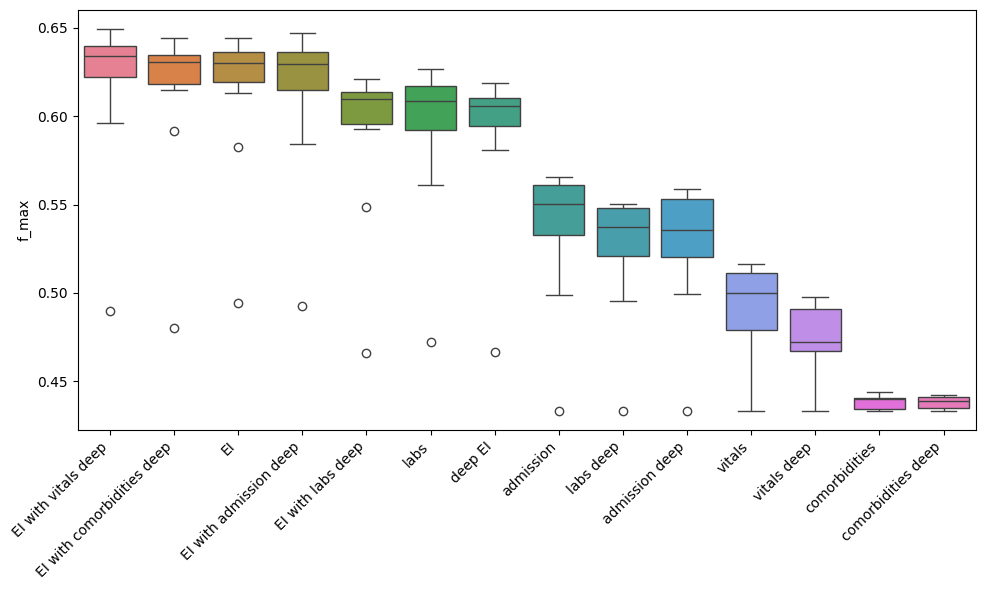

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Example dictionary with DataFrames
data_dict = performance_metrics

# Specify the row index for which you want to generate the boxplot
row_index = 'f_max'

# Create a list to store the data for the boxplot
data_list = []

# Iterate through the dictionary keys and extract the row data
for key, df in data_dict.items():
    if row_index in df.index:
        data_list.append(df.loc[row_index].values)

# Create a DataFrame for Seaborn
data_df = pd.DataFrame(data_list, index=data_dict.keys(), columns=df.columns)
# Box and Whiskers Plot using Seaborn
box_order = data_df.median(axis=1).sort_values(ascending=False).index
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_df.T[box_order])
plt.ylabel(row_index)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [31]:
data_df

,Mean,CES,S.ADAB,S.XGB,S.DT,S.RF,S.GB,S.KNN,S.LR,S.NB,S.MLP,S.SVM
admission,0.560352,0.555930,0.547589,0.518040,0.433344,0.537870,0.553556,0.498805,0.565269,0.565517,0.562311,0.544299
admission deep,0.533057,0.528471,0.551812,0.516657,0.433344,0.521717,0.553976,0.499220,0.557491,0.552803,0.558536,0.538204
EI with admission deep,0.617490,0.638703,0.616227,0.610159,0.492710,0.628873,0.639156,0.584284,0.646914,0.633057,0.635556,0.630637
comorbidities,0.443906,0.440304,0.439716,0.434681,0.433344,0.439519,0.440042,0.433344,0.444172,0.440584,0.441477,0.433372
comorbidities deep,0.441581,0.441962,0.438466,0.435294,0.433344,0.435249,0.439493,0.433344,0.441384,0.442284,0.441300,0.433486
EI with comorbidities deep,0.630415,0.644091,0.619048,0.614504,0.479910,0.634084,0.635800,0.591412,0.639679,0.633202,0.630579,0.630487
labs,0.601408,0.622404,0.608857,0.560843,0.472077,0.602240,0.615385,0.564248,0.626816,0.614815,0.621860,0.608403
labs deep,0.528818,0.540845,0.548252,0.522005,0.433344,0.534328,0.550103,0.495620,0.547808,0.544202,0.549209,0.517877
EI with labs deep,0.592477,0.611695,0.596309,0.607979,0.466188,0.613007,0.620781,0.548553,0.617185,0.601610,0.615055,0.611833
vitals,0.516584,0.511901,0.498753,0.471483,0.433344,0.485272,0.501759,0.455110,0.511246,0.512488,0.501977,0.481565


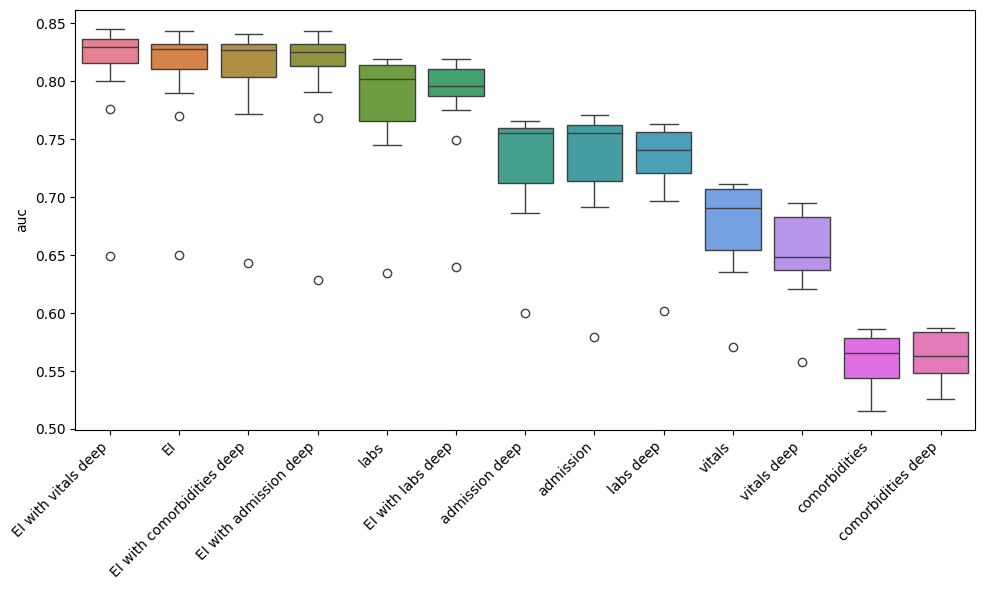

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Example dictionary with DataFrames
data_dict = performance_metrics

# Specify the row index for which you want to generate the boxplot
row_index = 'auc'

# Create a list to store the data for the boxplot
data_list = []

# Iterate through the dictionary keys and extract the row data
for key, df in data_dict.items():
    if row_index in df.index:
        data_list.append(df.loc[row_index].values)

# Create a DataFrame for Seaborn
data_df = pd.DataFrame(data_list, index=data_dict.keys(), columns=df.columns)
# Box and Whiskers Plot using Seaborn
box_order = data_df.median(axis=1).sort_values(ascending=False).index
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_df.T[box_order])
plt.ylabel(row_index)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [47]:
data_df

,Mean,CES,S.ADAB,S.XGB,S.DT,S.RF,S.GB,S.KNN,S.LR,S.NB,S.MLP,S.SVM
admission,0.761031,0.756862,0.753303,0.720673,0.579215,0.742814,0.757926,0.694064,0.771042,0.767125,0.768544,0.691569
admission deep,0.758686,0.756817,0.757589,0.718621,0.600080,0.727212,0.753798,0.692039,0.765665,0.763349,0.765115,0.686143
EI with admission deep,0.820425,0.831318,0.820023,0.821231,0.628347,0.833407,0.836920,0.768504,0.842949,0.829779,0.831289,0.791135
comorbidities,0.574928,0.578629,0.560100,0.545048,0.520165,0.564757,0.566738,0.515650,0.586549,0.579131,0.580880,0.540861
comorbidities deep,0.586698,0.585158,0.559046,0.550285,0.543325,0.553722,0.567415,0.539949,0.582112,0.586073,0.582955,0.525751
EI with comorbidities deep,0.828858,0.833790,0.815168,0.809345,0.643609,0.830391,0.832511,0.772042,0.840393,0.832534,0.824633,0.786573
labs,0.800824,0.814680,0.800297,0.772254,0.634260,0.802590,0.813261,0.745175,0.818885,0.808592,0.815694,0.745408
labs deep,0.727711,0.738029,0.754873,0.731089,0.601849,0.743190,0.759917,0.699607,0.761392,0.746572,0.762766,0.696607
EI with labs deep,0.793817,0.792709,0.791026,0.798665,0.639818,0.809430,0.814431,0.749557,0.819380,0.803626,0.814590,0.774809
vitals,0.707028,0.701276,0.689987,0.658910,0.570378,0.678990,0.691548,0.640203,0.711458,0.710038,0.707073,0.635415


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Data
data_fmax = {
    'admission': [0.5734265734265734, 0.5701078582434514, 0.5415617128463476, 0.5586776859504131, 0.580829756795422, 0.5531914893617021, 0.5505804311774462, 0.5929078014184397, 0.5783132530120483, 0.5763239875389408],
    'comorbidities': [0.4399293286219082, 0.44616709732988796, 0.45276292335115864, 0.4488330341113105, 0.448, 0.44665461121157324, 0.4446381865736704, 0.43453237410071943, 0.43996494303242767, 0.44786324786324794],
    'labs': [0.5371577574967406, 0.5903083700440529, 0.549237170596394, 0.4994663820704375, 0.5819209039548023, 0.5451851851851852, 0.5533834586466165, 0.5690140845070423, 0.56071964017991, 0.5757575757575758],
    'vitals': [0.5413333333333333, 0.5199306759098786, 0.5006016847172082, 0.5241157556270095, 0.5346534653465347, 0.5163120567375886, 0.5050215208034433, 0.5008130081300812, 0.5333333333333333, 0.5103857566765578],
    'EI': [0.623946037099494, 0.6388384754990926, 0.5924812030075187, 0.5745454545454546, 0.6459802538787024, 0.6376811594202898, 0.5988857938718662, 0.6324503311258278, 0.6088235294117648, 0.6319218241042345]
}

# Create a DataFrame from the data
df_fmax = pd.DataFrame(data_fmax)

# Melt the DataFrame to have 'variable' and 'value' columns
melted_df_fmax = pd.melt(df_fmax, var_name='Box', value_name='fmax')

# Order boxes by median value in descending order
box_order_fmax = melted_df_fmax.groupby('Box')['fmax'].median().sort_values(ascending=False).index

# Box and Whiskers Plot using Seaborn with sorted order
plt.figure(figsize=(10, 6))
sns.boxplot(x='Box', y='fmax', data=melted_df_fmax, order=box_order_fmax)
plt.title('fmax')
plt.ylabel('fmax values')
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# New Data
data_auc = {
    'admission': [0.7693368960628204, 0.7763605627658414, 0.7450430799432872, 0.7462754935107427, 0.770792889082779, 0.7577980150507143, 0.7505071436361654, 0.7867052023121386, 0.7761533427854729, 0.7670302104918748],
    'comorbidities': [0.5858681426545971, 0.6006898244083324, 0.5892790925946121, 0.6054913294797688, 0.6006434725706183, 0.6028792670956483, 0.5933962264150944, 0.5791389464499945, 0.5988330243210818, 0.5883438761042643],
    'labs': [0.745435707274512, 0.7772576071545426, 0.7408386956047552, 0.6439551750463519, 0.7786563420220307, 0.7274511942414658, 0.729921474533755, 0.7614570836514343, 0.7573890282473552, 0.790827789289999],
    'vitals': [0.723301341476715, 0.7141073181372014, 0.6892736394372342, 0.7114570836514342, 0.7110917221071, 0.7164358163376594, 0.6920111244410514, 0.6925019086050823, 0.7171011015377903, 0.7009870214854401],
    'EI': [0.8165612389573564, 0.8320809248554913, 0.7991220416621223, 0.7975079070781983, 0.8307449012978515, 0.8131911876976771, 0.8019413240266113, 0.8284109499400153, 0.8158905005998474, 0.8327952884720253]
}

# Create a DataFrame from the new data
df_auc = pd.DataFrame(data_auc)

# Melt the DataFrame to have 'variable' and 'value' columns
melted_df_auc = pd.melt(df_auc, var_name='Box', value_name='auc')

# Order boxes by median value in descending order
box_order = melted_df_auc.groupby('Box')['auc'].median().sort_values(ascending=False).index

# Box and Whiskers Plot using Seaborn with sorted order
plt.figure(figsize=(10, 6))
sns.boxplot(x='Box', y='auc', data=melted_df_auc, order=box_order)
plt.title('EI vs modalities')
plt.ylabel('AUC')
plt.show()

In [ ]:
EI = e.EnsembleIntegration(
                        k_outer=5,
                        k_inner=5,
                        n_samples=1,
                        sampling_strategy="undersampling",
                        sampling_aggregation=None,
                        n_jobs=-1,
                        metrics=metrics,
                        random_state=38,
                        project_name="diabetes",
                        model_building=True,
                        )

In [ ]:
for k,v in X_train.items():
    if k == "xgboost":
        EI.fit_base(v, y_train, modality_name=k, base_predictors=d_base_predictors)
    else:
        EI.fit_base(v, y_train, modality_name=k, base_predictors=base_predictors)

In [ ]:
EI.base_summary["metrics"]

In [ ]:
EI.fit_ensemble(ensemble_predictors=ensemble_predictors)

In [ ]:
EI.ensemble_summary["metrics"]

In [ ]:
preferred_ensemble_key = EI.ensemble_summary["metrics"].loc["auc"].idxmax()
print(preferred_ensemble_key)
y_pred = EI.predict(X_dict=X_test, ensemble_model_key=preferred_ensemble_key)
roc_auc_score(y_test, y_pred)

interpreter

In [ ]:
from eipy.interpretation import PermutationInterpreter

interpreter = PermutationInterpreter(EI=EI,
                                     metric=lambda y_test, y_pred: roc_auc_score(y_test, y_pred),
                                     ensemble_predictor_keys=preferred_ensemble_key,
                                     n_jobs=-1)

In [ ]:
EI.ensemble_predictors.keys()

In [ ]:
interpreter.rank_product_score(X_dict=X_test, y=y_test)